In [1]:
import os
os.environ['PATH']="D:/openslide-win64-20171122/bin"+';'+os.environ['PATH']
import openslide
import xml
import xml.etree.ElementTree as ET
import PIL
import PIL.ImageDraw as ImageDraw
import PIL.Image as Image
from shapely.geometry import Polygon, Point
import matplotlib.pyplot as plt
from skimage import measure
from skimage.transform import resize
import numpy as np


import torch
import torch.utils.data as data_utils
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import imageio

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [2]:
class Attention_92(nn.Module):
    def __init__(self):
        super(Attention_92,self).__init__()
        self.L = 500
        self.D = 128
        self.K = 1
        
        self.dropout = nn.Dropout(p=0.5)

        self.feature_extractor_part1 = nn.Sequential(
            nn.Conv2d(3,20,kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2,stride=2),
            nn.Conv2d(20,50,kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(50,60,kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)
        )
        self.feature_extractor_part2 = nn.Sequential(
            nn.Linear(60 * 8* 8, self.L),
            nn.ReLU()
        )
        self.attention = nn.Sequential(
            nn.Linear(self.L, self.D),
            nn.Tanh(),
            nn.Linear(self.D, self.K)
        )
        self.classifier = nn.Sequential(
            nn.Linear(self.L * self.K, 1),
            nn.Sigmoid()
        )
    def forward(self,x):
        x = x .squeeze(0)

        H = self.feature_extractor_part1(x)
        #print(H.shape)
        #H = H.view(-1, 60 * 8 * 8)
        H = torch.flatten(H, start_dim =1)
        #print(H.shape)
        H = self.dropout(H)
        #print(H.shape)
        H = self.feature_extractor_part2(H)

        A = self.attention(H)
        A = torch.transpose(A,1,0)
        #print(A)
        A = F.softmax(A,dim=1)
        #print(A)

        M = torch.mm(A,H)
        M = self.dropout(M)

        Y_prob = self.classifier(M)
        Y_hat = torch.ge(Y_prob,0.5).float()
        #print(Y_prob.shape, Y_hat.shape)

        return Y_prob, Y_hat, A

    def calculate_classification_error(self, X, Y):
        Y = Y.float()
        Y_prob, Y_hat,_ = self.forward(X)
        #print(Y, Y_hat, Y_hat.eq(Y))
        error = 1. - Y_hat.eq(Y).cpu().float().mean().data.item()

        return error, Y_hat, Y_prob
  
    def calculate_objective(self, X, Y):
        Y = Y.float()
        Y_prob, _, A = self.forward(X)
        Y_prob = torch.clamp(Y_prob, min=1e-5, max=1. - 1e-5)
        neg_log_likelihood =-1. * (Y * torch.log(Y_prob)+(1. - Y) * torch.log(1. - Y_prob))

        return neg_log_likelihood, A

### Non-overlapping apply

In [3]:
class TSDataset_apply_non_overlap(data_utils.Dataset):
    def __init__(self,slidedir, patch_shape, bag_length_2D,transform):
        self.slidedir = slidedir
        self.patch_shape = patch_shape
        self.bag_length_2D = bag_length_2D
        self.transform = transform

        self.bag_shape = (int(self.patch_shape[0]*self.bag_length_2D[0]), int(self.patch_shape[1]*self.bag_length_2D[1]))
        self.slide = openslide.OpenSlide(slidedir)
        self.slide_shape = self.slide.dimensions
        self.grid, self.grid_num = self.create_grid()
        print(self.slide_shape)
        #print(self.grid)
        
    
    def create_grid(self):
        grid = []
        num_grid_x = self.slide_shape[0] // self.bag_shape[0]
        num_grid_y = self.slide_shape[1] // self.bag_shape[1]
        print(num_grid_x,num_grid_y)
        for i in range(num_grid_x):
            for j in range(num_grid_y):
                upperLeft_bag_level = (int(i*self.patch_shape[0]), int(j*self.patch_shape[1]))
                upperLeft_instance_level = []
                for instance_i in range(self.bag_length_2D[0]):
                    for instance_j in range(self.bag_length_2D[1]):
                        upperLeft_instance_level.append((int(instance_i*self.patch_shape[0] + upperLeft_bag_level[0]), 
                                                         int(instance_j*self.patch_shape[1] + upperLeft_bag_level[1])))
                upperLeft={
                    'bag':upperLeft_bag_level,
                    'instance':upperLeft_instance_level
                }
                grid.append(upperLeft)
        return grid,(num_grid_x,num_grid_y)
    
    def pack_bag(self, upperLeft):
        instance_level = upperLeft['instance']
        Patches = []
        for upperLeft_patch in instance_level:
            #print(upperLeft_patch)
            patch = self.slide.read_region(upperLeft_patch,0,self.patch_shape)
            patch = np.array(patch)[:,:,:3]
            if self.transform is not None:
                patch = self.transform(patch)
            Patches.append(patch)
        bag = np.stack(Patches, axis=0)
        return bag
    
    def __len__(self):
        return len(self.grid)
    
    def __getitem__(self,idx):
        upperLeft = self.grid[idx]
        bag = self.pack_bag(upperLeft)
        return bag, upperLeft

### Overlapping apply

In [4]:
class TSDataset_apply_overlap(data_utils.Dataset):
    def __init__(self,slidedir, patch_shape, bag_length_2D,transform):
        self.slidedir = slidedir
        self.patch_shape = patch_shape
        self.bag_length_2D = bag_length_2D
        self.transform = transform

        self.bag_shape = (int(self.patch_shape[0]*self.bag_length_2D[0]), int(self.patch_shape[1]*self.bag_length_2D[1]))
        self.slide = openslide.OpenSlide(slidedir)
        self.slide_shape = self.slide.dimensions
        self.grid, self.grid_num = self.create_grid()
        print(self.slide_shape)
        #print(self.grid)
        
    
    def create_grid(self):
        grid = []
        num_grid_x = self.slide_shape[0] // self.patch_shape[0] - self.bag_length_2D[0]
        num_grid_y = self.slide_shape[1] // self.patch_shape[1] - self.bag_length_2D[1]
        print(num_grid_x,num_grid_y)
        for i in range(num_grid_x):
            for j in range(num_grid_y):
                upperLeft_bag_level = (int(i*self.patch_shape[0]), int(j*self.patch_shape[1]))
                upperLeft_instance_level = []
                for instance_i in range(self.bag_length_2D[0]):
                    for instance_j in range(self.bag_length_2D[1]):
                        upperLeft_instance_level.append((int(instance_i*self.patch_shape[0] + upperLeft_bag_level[0]), 
                                                         int(instance_j*self.patch_shape[1] + upperLeft_bag_level[1])))
                upperLeft={
                    'bag':upperLeft_bag_level,
                    'instance':upperLeft_instance_level
                }
                grid.append(upperLeft)
        return grid,(num_grid_x,num_grid_y)
    
    def pack_bag(self, upperLeft):
        instance_level = upperLeft['instance']
        Patches = []
        for upperLeft_patch in instance_level:
            #print(upperLeft_patch)
            patch = self.slide.read_region(upperLeft_patch,0,self.patch_shape)
            patch = np.array(patch)[:,:,:3]
            if self.transform is not None:
                patch = self.transform(patch)
            Patches.append(patch)
        bag = np.stack(Patches, axis=0)
        return bag
    
    def __len__(self):
        return len(self.grid)
    
    def __getitem__(self,idx):
        upperLeft = self.grid[idx]
        bag = self.pack_bag(upperLeft)
        return bag, upperLeft

In [5]:
class Args:
    def __init__(self):
        self.slidedir='D:/Ashel-slide/458599.svs'
        self.patch_shape = (92,92)
        self.model = Attention_92()
        self.model_path = "model_92_100.pth"
        self.bag_length_2D = (10,10)
        self.overlap = True
        
args = Args()

In [6]:
device = torch.device("cuda")
model = args.model
model.load_state_dict(torch.load(args.model_path))
model.to(device)

Attention_92(
  (dropout): Dropout(p=0.5, inplace=False)
  (feature_extractor_part1): Sequential(
    (0): Conv2d(3, 20, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(50, 60, kernel_size=(5, 5), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (feature_extractor_part2): Sequential(
    (0): Linear(in_features=3840, out_features=500, bias=True)
    (1): ReLU()
  )
  (attention): Sequential(
    (0): Linear(in_features=500, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=500, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

In [8]:
if not args.overlap:
    apply_set = TSDataset_apply_non_overlap( slidedir = args.slidedir,
                               patch_shape = args.patch_shape, 
                               bag_length_2D = args.bag_length_2D,
                               transform = transforms.Compose([transforms.ToTensor(),
                                                               transforms.Normalize((0.777, 0.778, 0.769),
                                                                                  (0.124,0.128,0.128))])
                              )

    apply_loader = data_utils.DataLoader(apply_set, batch_size = 1, shuffle = False)
    print(len(apply_loader))
    for bag_idx, (bag, upperLeft) in enumerate(apply_loader):
        if bag_idx > 2:
            break
        print(bag.shape)
    #print(upperLeft)
    
    hot_map_instance = np.zeros((args.bag_length_2D[1]* apply_set.grid_num[1], args.bag_length_2D[0]*apply_set.grid_num[0]))
    hot_map_bag = np.zeros((args.bag_length_2D[1]* apply_set.grid_num[1], args.bag_length_2D[0]*apply_set.grid_num[0]))
    print("Shape of hot map is ", hot_map_instance.shape)

    for batch_idx, (data, upperleft) in enumerate(apply_loader):
        data = data.cuda()
        data = Variable(data)
        Y_prob, predicted_label, attention_weights = model.forward(data)
        Y_prob = Y_prob.cpu().data.numpy()[0][0]
        predicted_label = predicted_label.cpu().numpy()[0][0]
        attention_weights = attention_weights.cpu().data.numpy()[0].tolist()
    
        print(batch_idx, Y_prob,predicted_label)
    
        instance_level = upperleft['instance'] 
        bag_level = upperleft['bag']
        instance_level = [(i[0]//args.patch_shape[0],i[1]//args.patch_shape[1]) for i in instance_level]
        (x_bag, y_bag) = (bag_level[0]//args.patch_shape[0], bag_level[1]//args.patch_shape[1])
    
        hot_map_bag[y_bag:y_bag + args.bag_length_2D[1], x_bag: x_bag+args.bag_length_2D[0]] = Y_prob
    
        for idx, (x, y) in enumerate(instance_level):
            hot_map_instance[y, x] = attention_weights[idx]

    print(np.max(hot_map_instance), np.min(hot_map_instance))
    print(np.max(hot_map_bag), np.min(hot_map_bag))

In [ ]:
if args.overlap:
    apply_set = TSDataset_apply_overlap( slidedir = args.slidedir,
                               patch_shape = args.patch_shape, 
                               bag_length_2D = args.bag_length_2D,
                               transform = transforms.Compose([transforms.ToTensor(),
                                                               transforms.Normalize((0.777, 0.778, 0.769),
                                                                                  (0.124,0.128,0.128))])
                              )

    apply_loader = data_utils.DataLoader(apply_set, batch_size = 1, shuffle = False)
    print(len(apply_loader))
    for bag_idx, (bag, upperLeft) in enumerate(apply_loader):
        if bag_idx > 2:
            break
        print(bag.shape)
    #print(upperLeft)
    
    hot_map_instance = np.zeros((args.bag_length_2D[1] + apply_set.grid_num[1], args.bag_length_2D[0] + apply_set.grid_num[0]))
    hot_map_bag = np.zeros((args.bag_length_2D[1] + apply_set.grid_num[1], args.bag_length_2D[0] + apply_set.grid_num[0]))
    hot_map_count = np.zeros((args.bag_length_2D[1] + apply_set.grid_num[1], args.bag_length_2D[0] + apply_set.grid_num[0]))
    print("Shape of hot map is ", hot_map_instance.shape)

    for batch_idx, (data, upperleft) in enumerate(apply_loader):
        data = data.cuda()
        data = Variable(data)
        Y_prob, predicted_label, attention_weights = model.forward(data)
        Y_prob = Y_prob.cpu().data.numpy()[0][0]
        predicted_label = predicted_label.cpu().numpy()[0][0]
        attention_weights = attention_weights.cpu().data.numpy()[0].tolist()
    
        print(batch_idx, Y_prob,predicted_label)
    
        instance_level = upperleft['instance'] 
        bag_level = upperleft['bag']
        instance_level = [(i[0]//args.patch_shape[0],i[1]//args.patch_shape[1]) for i in instance_level]
        (x_bag, y_bag) = (bag_level[0]//args.patch_shape[0], bag_level[1]//args.patch_shape[1])
    
        hot_map_bag[y_bag:y_bag + args.bag_length_2D[1], x_bag: x_bag+args.bag_length_2D[0]] += Y_prob
        hot_map_count[y_bag:y_bag + args.bag_length_2D[1], x_bag: x_bag+args.bag_length_2D[0]] += 1
    
        for idx, (x, y) in enumerate(instance_level):
            hot_map_instance[y, x] += attention_weights[idx]

    #print(np.max(hot_map_instance), np.min(hot_map_instance))
    #print(np.max(hot_map_bag), np.min(hot_map_bag))

423 280
(39839, 26746)
118440
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
Shape of hot map is  (290, 433)
0 0.13898018 0.0
1 0.12233109 0.0
2 0.15772583 0.0
3 0.080965884 0.0
4 0.118939586 0.0
5 0.097031906 0.0
6 0.12362813 0.0
7 0.06945297 0.0
8 0.13955136 0.0
9 0.13743748 0.0
10 0.12856586 0.0
11 0.0822229 0.0
12 0.14695437 0.0
13 0.15557817 0.0
14 0.12655394 0.0
15 0.13584687 0.0
16 0.12100058 0.0
17 0.122644514 0.0
18 0.1214867 0.0
19 0.11972238 0.0
20 0.12044914 0.0
21 0.12394479 0.0
22 0.15158123 0.0
23 0.18387207 0.0
24 0.12676919 0.0
25 0.1033787 0.0
26 0.09306307 0.0
27 0.12962368 0.0
28 0.124750756 0.0
29 0.11819721 0.0
30 0.15993163 0.0
31 0.106015846 0.0
32 0.14868976 0.0
33 0.11612313 0.0
34 0.09983241 0.0
35 0.13088559 0.0
36 0.12898208 0.0
37 0.09544115 0.0
38 0.11473264 0.0
39 0.12490878 0.0
40 0.12847684 0.0
41 0.14378987 0.0
42 0.16555455 0.0
43 0.11653509 0.0
44 0.117467485 0.0
45 0.11076569 0.0
46 0.10928006 0.0
47

430 0.128951 0.0
431 0.13107853 0.0
432 0.097317524 0.0
433 0.09221338 0.0
434 0.092895105 0.0
435 0.10762206 0.0
436 0.12509978 0.0
437 0.09356679 0.0
438 0.13953651 0.0
439 0.11287267 0.0
440 0.14312437 0.0
441 0.1208157 0.0
442 0.12031755 0.0
443 0.12837793 0.0
444 0.11628217 0.0
445 0.11952615 0.0
446 0.120618746 0.0
447 0.13076077 0.0
448 0.12079197 0.0
449 0.09129832 0.0
450 0.12693466 0.0
451 0.104640365 0.0
452 0.10844567 0.0
453 0.11595781 0.0
454 0.090178676 0.0
455 0.09158508 0.0
456 0.08872164 0.0
457 0.11693359 0.0
458 0.114294656 0.0
459 0.0892071 0.0
460 0.13123433 0.0
461 0.12001859 0.0
462 0.1063171 0.0
463 0.09458758 0.0
464 0.11353506 0.0
465 0.14015335 0.0
466 0.103052124 0.0
467 0.103635326 0.0
468 0.13409396 0.0
469 0.12229878 0.0
470 0.11616578 0.0
471 0.050365582 0.0
472 0.13198242 0.0
473 0.16681321 0.0
474 0.1060127 0.0
475 0.09351215 0.0
476 0.15446198 0.0
477 0.076143175 0.0
478 0.0885809 0.0
479 0.13555272 0.0
480 0.019954573 0.0
481 0.08892982 0.0
482 0.10

858 0.16684164 0.0
859 0.12726386 0.0
860 0.15699685 0.0
861 0.11302265 0.0
862 0.12176008 0.0
863 0.12380379 0.0
864 0.1448199 0.0
865 0.14281589 0.0
866 0.11263849 0.0
867 0.09619792 0.0
868 0.12423165 0.0
869 0.08681138 0.0
870 0.110888764 0.0
871 0.11754804 0.0
872 0.14757234 0.0
873 0.119525865 0.0
874 0.12144955 0.0
875 0.12911855 0.0
876 0.12964198 0.0
877 0.09665074 0.0
878 0.11008464 0.0
879 0.15613666 0.0
880 0.11900758 0.0
881 0.14650561 0.0
882 0.13591655 0.0
883 0.109216064 0.0
884 0.15231054 0.0
885 0.11882549 0.0
886 0.15062638 0.0
887 0.15739931 0.0
888 0.13510065 0.0
889 0.13752635 0.0
890 0.13423531 0.0
891 0.13854448 0.0
892 0.13548088 0.0
893 0.12640983 0.0
894 0.08595861 0.0
895 0.09956425 0.0
896 0.07965588 0.0
897 0.18011898 0.0
898 0.16880831 0.0
899 0.10203465 0.0
900 0.09662029 0.0
901 0.11004801 0.0
902 0.17543595 0.0
903 0.14954212 0.0
904 0.14068158 0.0
905 0.13216726 0.0
906 0.10654805 0.0
907 0.152383 0.0
908 0.09323471 0.0
909 0.09307809 0.0
910 0.079860

1274 0.12945852 0.0
1275 0.12495025 0.0
1276 0.15378644 0.0
1277 0.15867846 0.0
1278 0.07441921 0.0
1279 0.18351027 0.0
1280 0.093625166 0.0
1281 0.16690093 0.0
1282 0.1396222 0.0
1283 0.09632419 0.0
1284 0.171921 0.0
1285 0.11104555 0.0
1286 0.13627711 0.0
1287 0.06161597 0.0
1288 0.094969764 0.0
1289 0.10064857 0.0
1290 0.019059466 0.0
1291 6.689786e-07 0.0
1292 3.596841e-07 0.0
1293 6.62098e-06 0.0
1294 3.0514311e-06 0.0
1295 0.010298542 0.0
1296 2.9469627e-06 0.0
1297 0.00044921713 0.0
1298 6.3384755e-07 0.0
1299 5.1858437e-06 0.0
1300 0.1286487 0.0
1301 0.19280662 0.0
1302 0.111043125 0.0
1303 0.13477926 0.0
1304 0.1098345 0.0
1305 0.086153336 0.0
1306 0.114020444 0.0
1307 0.13976973 0.0
1308 0.08965802 0.0
1309 0.16792399 0.0
1310 0.13061026 0.0
1311 0.10729666 0.0
1312 0.082190566 0.0
1313 0.1365365 0.0
1314 0.0926459 0.0
1315 0.123848684 0.0
1316 0.055871997 0.0
1317 0.1478019 0.0
1318 0.14223391 0.0
1319 0.12225417 0.0
1320 0.12016704 0.0
1321 0.11794318 0.0
1322 0.10334712 0.

1681 0.122534044 0.0
1682 0.10249856 0.0
1683 0.14470124 0.0
1684 0.15590274 0.0
1685 0.110639885 0.0
1686 0.10830283 0.0
1687 0.12172097 0.0
1688 0.097497694 0.0
1689 0.109519996 0.0
1690 0.12656304 0.0
1691 0.1401914 0.0
1692 0.11443761 0.0
1693 0.097275086 0.0
1694 0.1107764 0.0
1695 0.08361697 0.0
1696 0.071342014 0.0
1697 0.14680238 0.0
1698 0.10870421 0.0
1699 0.10565285 0.0
1700 0.07820201 0.0
1701 0.13365787 0.0
1702 0.091178074 0.0
1703 0.09330195 0.0
1704 0.11437466 0.0
1705 0.14290386 0.0
1706 0.1317773 0.0
1707 0.0994655 0.0
1708 0.13372509 0.0
1709 0.10714313 0.0
1710 0.09102467 0.0
1711 0.11554518 0.0
1712 0.1332257 0.0
1713 0.11496629 0.0
1714 0.13003433 0.0
1715 0.1450846 0.0
1716 0.1115356 0.0
1717 0.10307487 0.0
1718 0.14139642 0.0
1719 0.10941891 0.0
1720 0.11761152 0.0
1721 0.06595116 0.0
1722 0.1162221 0.0
1723 0.123223394 0.0
1724 0.10322099 0.0
1725 0.14429209 0.0
1726 0.11441051 0.0
1727 0.11511386 0.0
1728 0.11805861 0.0
1729 0.1465785 0.0
1730 0.13133702 0.0
1

2091 0.10419581 0.0
2092 0.105774924 0.0
2093 0.09773476 0.0
2094 0.1228649 0.0
2095 0.124697454 0.0
2096 0.08280371 0.0
2097 0.112289175 0.0
2098 0.13224742 0.0
2099 0.12255807 0.0
2100 0.112805806 0.0
2101 0.13606787 0.0
2102 0.11562464 0.0
2103 0.14602378 0.0
2104 0.11853733 0.0
2105 0.1421914 0.0
2106 0.093864225 0.0
2107 0.11347297 0.0
2108 0.07614695 0.0
2109 0.14207436 0.0
2110 0.12802057 0.0
2111 0.15229492 0.0
2112 0.12472093 0.0
2113 0.12653421 0.0
2114 0.113916084 0.0
2115 0.10969106 0.0
2116 0.11286494 0.0
2117 0.11323313 0.0
2118 0.116393395 0.0
2119 0.10686238 0.0
2120 0.15979838 0.0
2121 0.12693448 0.0
2122 0.12189026 0.0
2123 0.18242064 0.0
2124 0.12598747 0.0
2125 0.18142591 0.0
2126 0.12182027 0.0
2127 0.08517234 0.0
2128 0.11419578 0.0
2129 0.089630835 0.0
2130 1.5698922e-07 0.0
2131 0.011199323 0.0
2132 2.7467854e-06 0.0
2133 5.934061e-06 0.0
2134 3.8503254e-06 0.0
2135 1.7127913e-05 0.0
2136 4.7163525e-05 0.0
2137 3.461405e-06 0.0
2138 0.00011931517 0.0
2139 0.0001

2504 0.15513659 0.0
2505 0.09380078 0.0
2506 0.16594891 0.0
2507 0.12336805 0.0
2508 0.16191398 0.0
2509 0.00087154954 0.0
2510 0.033637393 0.0
2511 0.005214993 0.0
2512 0.057448633 0.0
2513 0.017360123 0.0
2514 0.00046304456 0.0
2515 1.9137877e-05 0.0
2516 0.0002781508 0.0
2517 0.058473725 0.0
2518 0.012662107 0.0
2519 0.15191187 0.0
2520 0.10530616 0.0
2521 0.12500407 0.0
2522 0.13635582 0.0
2523 0.09027219 0.0
2524 0.07965598 0.0
2525 0.13941 0.0
2526 0.0885268 0.0
2527 0.1143467 0.0
2528 0.15476681 0.0
2529 0.20407715 0.0
2530 0.14046268 0.0
2531 0.08456247 0.0
2532 0.1429196 0.0
2533 0.099097095 0.0
2534 0.097374804 0.0
2535 0.11449595 0.0
2536 0.078749746 0.0
2537 0.10465777 0.0
2538 0.1686121 0.0
2539 0.10290294 0.0
2540 0.13836454 0.0
2541 0.121700354 0.0
2542 0.12789084 0.0
2543 0.1666736 0.0
2544 0.11595329 0.0
2545 0.095238075 0.0
2546 0.119508915 0.0
2547 0.10529199 0.0
2548 0.11586367 0.0
2549 0.13007297 0.0
2550 0.13579343 0.0
2551 0.087587275 0.0
2552 0.11214554 0.0
2553

2915 0.17579544 0.0
2916 0.11584687 0.0
2917 0.13815625 0.0
2918 0.109796 0.0
2919 0.11322319 0.0
2920 0.16369645 0.0
2921 0.16020645 0.0
2922 0.15716578 0.0
2923 0.109224536 0.0
2924 0.12930162 0.0
2925 0.123168275 0.0
2926 0.17964947 0.0
2927 0.09647633 0.0
2928 0.085525334 0.0
2929 0.0774066 0.0
2930 0.1122888 0.0
2931 0.12704709 0.0
2932 0.09548719 0.0
2933 0.117322795 0.0
2934 0.11652061 0.0
2935 0.14151576 0.0
2936 0.1847157 0.0
2937 0.101110965 0.0
2938 0.13685226 0.0
2939 0.15906955 0.0
2940 0.10413367 0.0
2941 0.10742145 0.0
2942 0.149325 0.0
2943 0.15037788 0.0
2944 0.13092507 0.0
2945 0.17597866 0.0
2946 0.11897752 0.0
2947 0.14399256 0.0
2948 0.18463448 0.0
2949 0.13837615 0.0
2950 0.19010243 0.0
2951 0.1125561 0.0
2952 0.07470718 0.0
2953 0.08308628 0.0
2954 0.10833509 0.0
2955 0.14117275 0.0
2956 0.11835768 0.0
2957 0.12800074 0.0
2958 0.17386001 0.0
2959 0.11080583 0.0
2960 0.10165612 0.0
2961 0.13301292 0.0
2962 0.080090314 0.0
2963 0.12001922 0.0
2964 0.085637935 0.0
2

3324 0.10147806 0.0
3325 0.12898941 0.0
3326 0.10233115 0.0
3327 0.13743663 0.0
3328 0.090101086 0.0
3329 0.114406414 0.0
3330 0.1292915 0.0
3331 0.12771171 0.0
3332 0.09238564 0.0
3333 0.1079213 0.0
3334 0.08684254 0.0
3335 0.124150634 0.0
3336 0.09939095 0.0
3337 0.10010684 0.0
3338 0.14749052 0.0
3339 0.15728682 0.0
3340 0.1723141 0.0
3341 0.11730751 0.0
3342 0.12652963 0.0
3343 0.113436855 0.0
3344 0.10556954 0.0
3345 0.10555134 0.0
3346 0.11618609 0.0
3347 0.19069721 0.0
3348 0.12727728 0.0
3349 0.06759439 0.0
3350 0.030637084 0.0
3351 0.030815687 0.0
3352 4.762028e-06 0.0
3353 0.09340424 0.0
3354 0.007016817 0.0
3355 0.113521025 0.0
3356 0.0064813634 0.0
3357 0.00023098127 0.0
3358 0.0041180626 0.0
3359 0.12511665 0.0
3360 0.09160997 0.0
3361 0.098035924 0.0
3362 0.108576484 0.0
3363 0.13403825 0.0
3364 0.09491779 0.0
3365 0.115959726 0.0
3366 0.16880018 0.0
3367 0.13020296 0.0
3368 0.11049145 0.0
3369 0.106024645 0.0
3370 0.10629208 0.0
3371 0.13061519 0.0
3372 0.13910808 0.0
33

3731 0.122236185 0.0
3732 0.123817414 0.0
3733 0.16237137 0.0
3734 0.1311427 0.0
3735 0.14846942 0.0
3736 0.113645144 0.0
3737 0.1550316 0.0
3738 0.12556334 0.0
3739 0.098969206 0.0
3740 0.07368874 0.0
3741 0.11172367 0.0
3742 0.15843041 0.0
3743 0.16111329 0.0
3744 0.15290786 0.0
3745 0.12677541 0.0
3746 0.12232768 0.0
3747 0.10524358 0.0
3748 0.1085257 0.0
3749 0.12444857 0.0
3750 0.1288364 0.0
3751 0.1416387 0.0
3752 0.14653292 0.0
3753 0.09300731 0.0
3754 0.108239844 0.0
3755 0.10185243 0.0
3756 0.09112966 0.0
3757 0.16633636 0.0
3758 0.12453116 0.0
3759 0.11624444 0.0
3760 0.102197014 0.0
3761 0.14816417 0.0
3762 0.13743046 0.0
3763 0.12834711 0.0
3764 0.0864406 0.0
3765 0.1480702 0.0
3766 0.15173207 0.0
3767 0.1568912 0.0
3768 0.101352096 0.0
3769 0.1191465 0.0
3770 0.1548207 0.0
3771 0.09839374 0.0
3772 0.11790365 0.0
3773 0.19207636 0.0
3774 0.15008971 0.0
3775 0.14510305 0.0
3776 0.091838315 0.0
3777 0.097047076 0.0
3778 0.12487617 0.0
3779 0.08308081 0.0
3780 0.0999031 0.0
37

4139 0.99115807 1.0
4140 0.94372314 1.0
4141 0.9959727 1.0
4142 0.0066873366 0.0
4143 0.18375137 0.0
4144 0.10043766 0.0
4145 0.5689953 1.0
4146 0.63367563 1.0
4147 0.9998141 1.0
4148 0.99384177 1.0
4149 1.0021316e-06 0.0
4150 0.00020369152 0.0
4151 1.4534106e-11 0.0
4152 0.0035177025 0.0
4153 0.06824399 0.0
4154 0.0673 0.0
4155 0.039161883 0.0
4156 0.14554992 0.0
4157 0.09970387 0.0
4158 0.12638791 0.0
4159 0.12706695 0.0
4160 0.09557181 0.0
4161 0.12030586 0.0
4162 0.1181101 0.0
4163 0.13283178 0.0
4164 0.12553522 0.0
4165 0.15576693 0.0
4166 0.13069494 0.0
4167 0.11072413 0.0
4168 0.126384 0.0
4169 0.12508266 0.0
4170 0.11829544 0.0
4171 0.10366619 0.0
4172 0.10522384 0.0
4173 0.098184556 0.0
4174 0.11399499 0.0
4175 0.13856336 0.0
4176 0.13793607 0.0
4177 0.10437578 0.0
4178 0.13547724 0.0
4179 0.10618914 0.0
4180 0.1630472 0.0
4181 0.13820183 0.0
4182 0.08330551 0.0
4183 0.13702889 0.0
4184 0.11023951 0.0
4185 0.17231272 0.0
4186 0.097399615 0.0
4187 0.15363121 0.0
4188 0.0749002 

4546 0.13338555 0.0
4547 0.082887374 0.0
4548 0.12016785 0.0
4549 0.09672764 0.0
4550 0.12443929 0.0
4551 0.13134181 0.0
4552 0.13046953 0.0
4553 0.12145687 0.0
4554 0.16408081 0.0
4555 0.1608652 0.0
4556 0.16025518 0.0
4557 0.10919394 0.0
4558 0.11277077 0.0
4559 0.11707359 0.0
4560 0.13397023 0.0
4561 0.13055716 0.0
4562 0.1293218 0.0
4563 0.1387796 0.0
4564 0.14995244 0.0
4565 0.105081014 0.0
4566 0.11328836 0.0
4567 0.08177393 0.0
4568 0.13837127 0.0
4569 0.16103937 0.0
4570 0.120931625 0.0
4571 0.1637555 0.0
4572 0.104611196 0.0
4573 0.14192636 0.0
4574 0.15781254 0.0
4575 0.09562489 0.0
4576 0.123600215 0.0
4577 0.11476461 0.0
4578 0.097528264 0.0
4579 0.110386945 0.0
4580 0.1366394 0.0
4581 0.10746391 0.0
4582 0.14891106 0.0
4583 0.07081524 0.0
4584 0.08099174 0.0
4585 0.11436493 0.0
4586 0.1078623 0.0
4587 0.13024491 0.0
4588 0.11862828 0.0
4589 0.14664651 0.0
4590 0.11013237 0.0
4591 0.124320336 0.0
4592 0.14390834 0.0
4593 0.12597945 0.0
4594 0.09921481 0.0
4595 0.14142275 0.

4954 0.09505275 0.0
4955 0.12675947 0.0
4956 0.1169345 0.0
4957 0.15426503 0.0
4958 0.120261386 0.0
4959 0.1480003 0.0
4960 0.14742039 0.0
4961 0.11707394 0.0
4962 0.14109175 0.0
4963 0.10694358 0.0
4964 0.13000272 0.0
4965 0.13054271 0.0
4966 0.14451876 0.0
4967 0.002762983 0.0
4968 0.014518786 0.0
4969 0.015965946 0.0
4970 0.016255211 0.0
4971 0.0012372355 0.0
4972 0.0014270099 0.0
4973 0.17188993 0.0
4974 0.077486105 0.0
4975 0.00064994005 0.0
4976 6.532159e-06 0.0
4977 1.0121918e-06 0.0
4978 3.4438457e-05 0.0
4979 5.821111e-05 0.0
4980 3.730662e-05 0.0
4981 5.436536e-06 0.0
4982 1.6274508e-06 0.0
4983 3.2733176e-08 0.0
4984 1.0133141e-06 0.0
4985 5.7100057e-11 0.0
4986 2.5295494e-08 0.0
4987 6.385454e-07 0.0
4988 1.3131642e-08 0.0
4989 1.0103286e-06 0.0
4990 3.214362e-08 0.0
4991 7.2729393e-13 0.0
4992 7.862591e-06 0.0
4993 0.03397479 0.0
4994 0.12838583 0.0
4995 0.09881099 0.0
4996 0.12700415 0.0
4997 0.13954532 0.0
4998 0.10312315 0.0
4999 0.16327523 0.0
5000 0.14348759 0.0
5001 

5359 0.1438279 0.0
5360 0.107577205 0.0
5361 0.12738866 0.0
5362 0.09263584 0.0
5363 0.13677207 0.0
5364 0.120551474 0.0
5365 0.08265442 0.0
5366 0.10529245 0.0
5367 0.15284291 0.0
5368 0.12537122 0.0
5369 0.12748861 0.0
5370 0.12838723 0.0
5371 0.11438622 0.0
5372 0.10263082 0.0
5373 0.09227547 0.0
5374 0.090515874 0.0
5375 0.12942722 0.0
5376 0.10221003 0.0
5377 0.111477286 0.0
5378 0.118612796 0.0
5379 0.15293106 0.0
5380 0.13233939 0.0
5381 0.11948823 0.0
5382 0.12484156 0.0
5383 0.09788642 0.0
5384 0.1081172 0.0
5385 0.10932585 0.0
5386 0.13148104 0.0
5387 0.1531549 0.0
5388 0.14280802 0.0
5389 0.11423362 0.0
5390 0.09875306 0.0
5391 0.10316772 0.0
5392 0.10679753 0.0
5393 0.088427395 0.0
5394 0.15823147 0.0
5395 0.11447566 0.0
5396 0.09873675 0.0
5397 0.16093495 0.0
5398 0.11828546 0.0
5399 0.09208037 0.0
5400 0.11391285 0.0
5401 0.1308507 0.0
5402 0.14216053 0.0
5403 0.15064798 0.0
5404 0.10398361 0.0
5405 0.11155754 0.0
5406 0.097321734 0.0
5407 0.12266618 0.0
5408 0.12479643 0

5766 0.08045483 0.0
5767 0.120527804 0.0
5768 0.11388363 0.0
5769 0.10239772 0.0
5770 0.101315096 0.0
5771 0.10885559 0.0
5772 0.15630224 0.0
5773 0.15114698 0.0
5774 0.114136904 0.0
5775 0.12257875 0.0
5776 0.1155637 0.0
5777 0.08374132 0.0
5778 0.13270365 0.0
5779 0.08990521 0.0
5780 0.16609383 0.0
5781 0.11021023 0.0
5782 0.10969688 0.0
5783 0.10188001 0.0
5784 0.060650628 0.0
5785 0.0918452 0.0
5786 0.11537844 0.0
5787 0.118761644 0.0
5788 0.11029477 0.0
5789 0.1238081 0.0
5790 0.090838395 0.0
5791 0.10886252 0.0
5792 0.12112341 0.0
5793 0.07486665 0.0
5794 0.13500741 0.0
5795 0.16656938 0.0
5796 0.09972157 0.0
5797 0.10136108 0.0
5798 0.11439293 0.0
5799 0.15530849 0.0
5800 0.122760125 0.0
5801 0.12658112 0.0
5802 0.16415027 0.0
5803 0.11166008 0.0
5804 0.13407277 0.0
5805 0.09826594 0.0
5806 0.13907236 0.0
5807 0.0008197962 0.0
5808 0.0008549209 0.0
5809 0.00043740319 0.0
5810 0.024958992 0.0
5811 2.3472509e-07 0.0
5812 0.22944753 0.0
5813 0.40538222 0.0
5814 0.0002955373 0.0
581

6170 0.10297309 0.0
6171 0.07596291 0.0
6172 0.12913407 0.0
6173 0.1254179 0.0
6174 0.10259199 0.0
6175 0.17089923 0.0
6176 0.1384384 0.0
6177 0.11970104 0.0
6178 0.15498292 0.0
6179 0.15140527 0.0
6180 0.09565979 0.0
6181 0.09726738 0.0
6182 0.1712125 0.0
6183 0.13142534 0.0
6184 0.09078481 0.0
6185 0.11690217 0.0
6186 0.12984273 0.0
6187 0.12571314 0.0
6188 0.0970485 0.0
6189 0.11423867 0.0
6190 0.1231531 0.0
6191 0.11826417 0.0
6192 0.15107933 0.0
6193 0.13307686 0.0
6194 0.10964105 0.0
6195 0.15899709 0.0
6196 0.14463677 0.0
6197 0.15098515 0.0
6198 0.13119519 0.0
6199 0.10604903 0.0
6200 0.14670295 0.0
6201 0.10473599 0.0
6202 0.09169749 0.0
6203 0.09629178 0.0
6204 0.13400742 0.0
6205 0.12748438 0.0
6206 0.098166816 0.0
6207 0.09904154 0.0
6208 0.09615821 0.0
6209 0.11209922 0.0
6210 0.12772018 0.0
6211 0.1017644 0.0
6212 0.11043768 0.0
6213 0.15743996 0.0
6214 0.13287109 0.0
6215 0.18078317 0.0
6216 0.11488941 0.0
6217 0.18523228 0.0
6218 0.15041853 0.0
6219 0.1818305 0.0
6220 0

6575 0.14037691 0.0
6576 0.09939274 0.0
6577 0.1473652 0.0
6578 0.12865162 0.0
6579 0.087561324 0.0
6580 0.098138854 0.0
6581 0.14365023 0.0
6582 0.075638816 0.0
6583 0.1540601 0.0
6584 0.096673235 0.0
6585 0.10584953 0.0
6586 0.14209755 0.0
6587 0.088552885 0.0
6588 0.09676558 0.0
6589 0.10002264 0.0
6590 0.09136645 0.0
6591 0.09902535 0.0
6592 0.104600094 0.0
6593 0.13055187 0.0
6594 0.12640616 0.0
6595 0.093834214 0.0
6596 0.105356604 0.0
6597 0.14725968 0.0
6598 0.12903209 0.0
6599 0.10580114 0.0
6600 0.08925875 0.0
6601 0.1292199 0.0
6602 0.11702524 0.0
6603 0.17556925 0.0
6604 0.13567746 0.0
6605 0.11377124 0.0
6606 0.110184096 0.0
6607 0.08791075 0.0
6608 0.15474318 0.0
6609 0.096898325 0.0
6610 0.1280774 0.0
6611 0.105784506 0.0
6612 0.17074008 0.0
6613 0.15480633 0.0
6614 0.093612805 0.0
6615 0.16143988 0.0
6616 0.0723683 0.0
6617 0.13092567 0.0
6618 0.108453296 0.0
6619 0.08107672 0.0
6620 0.107196726 0.0
6621 0.07230226 0.0
6622 0.121604286 0.0
6623 0.12015336 0.0
6624 0.021

6979 0.0030215916 0.0
6980 0.001389391 0.0
6981 0.020833418 0.0
6982 0.0018400729 0.0
6983 0.009954495 0.0
6984 0.012105289 0.0
6985 0.14520451 0.0
6986 0.15728648 0.0
6987 0.12949784 0.0
6988 0.11669708 0.0
6989 0.11588614 0.0
6990 0.15924644 0.0
6991 0.095705695 0.0
6992 0.13577658 0.0
6993 0.08644778 0.0
6994 0.15352821 0.0
6995 0.12831174 0.0
6996 0.10852974 0.0
6997 0.13276446 0.0
6998 0.13311593 0.0
6999 0.00019821861 0.0
7000 0.14422159 0.0
7001 0.10976592 0.0
7002 0.14971066 0.0
7003 0.12693326 0.0
7004 0.18970914 0.0
7005 0.11345622 0.0
7006 0.14570458 0.0
7007 0.14850476 0.0
7008 0.09351405 0.0
7009 0.112350814 0.0
7010 0.10617126 0.0
7011 0.111593805 0.0
7012 0.15226045 0.0
7013 0.117381506 0.0
7014 0.07802446 0.0
7015 0.12121652 0.0
7016 0.12564956 0.0
7017 0.12933218 0.0
7018 0.12287775 0.0
7019 0.15174346 0.0
7020 0.1463611 0.0
7021 0.18131463 0.0
7022 0.11471726 0.0
7023 0.12720685 0.0
7024 0.13976674 0.0
7025 0.10901336 0.0
7026 0.15411055 0.0
7027 0.11645573 0.0
7028 0

7387 0.10427082 0.0
7388 0.10710493 0.0
7389 0.15132095 0.0
7390 0.13110076 0.0
7391 0.09844947 0.0
7392 0.20402586 0.0
7393 0.11592844 0.0
7394 0.17518924 0.0
7395 0.123433344 0.0
7396 0.121056974 0.0
7397 0.0982536 0.0
7398 0.102919534 0.0
7399 0.0938701 0.0
7400 0.119433396 0.0
7401 0.07736662 0.0
7402 0.110643096 0.0
7403 0.14587937 0.0
7404 0.1378361 0.0
7405 0.17533633 0.0
7406 0.12426045 0.0
7407 0.1556492 0.0
7408 0.1314776 0.0
7409 0.14059322 0.0
7410 0.17796707 0.0
7411 0.1379341 0.0
7412 0.1263037 0.0
7413 0.13604358 0.0
7414 0.13983136 0.0
7415 0.13553084 0.0
7416 0.10537537 0.0
7417 0.12300598 0.0
7418 0.10940372 0.0
7419 0.12855038 0.0
7420 0.12936726 0.0
7421 0.08126923 0.0
7422 0.13235947 0.0
7423 0.09739706 0.0
7424 0.16367479 0.0
7425 0.10214806 0.0
7426 0.13817775 0.0
7427 0.12883146 0.0
7428 0.10030126 0.0
7429 0.13279495 0.0
7430 0.12941207 0.0
7431 0.14865784 0.0
7432 0.10916941 0.0
7433 0.09523651 0.0
7434 0.0935321 0.0
7435 0.16848424 0.0
7436 0.1552672 0.0
7437

7794 5.838582e-12 0.0
7795 5.55788e-05 0.0
7796 0.10550194 0.0
7797 0.13256533 0.0
7798 0.12005291 0.0
7799 0.12346664 0.0
7800 0.08790344 0.0
7801 0.12633124 0.0
7802 0.16641438 0.0
7803 0.1160369 0.0
7804 0.095770404 0.0
7805 0.11712503 0.0
7806 0.17795858 0.0
7807 0.11123401 0.0
7808 0.009252282 0.0
7809 0.001521174 0.0
7810 0.007058229 0.0
7811 0.065404646 0.0
7812 0.0014401472 0.0
7813 0.01487932 0.0
7814 0.009058457 0.0
7815 0.006229027 0.0
7816 0.002823891 0.0
7817 0.016589459 0.0
7818 0.009606303 0.0
7819 0.008832448 0.0
7820 3.97029e-05 0.0
7821 0.05712175 0.0
7822 0.018061465 0.0
7823 0.0010992902 0.0
7824 0.043012995 0.0
7825 0.14870909 0.0
7826 0.08517361 0.0
7827 0.10216475 0.0
7828 0.11405887 0.0
7829 0.15640718 0.0
7830 0.17504287 0.0
7831 0.113831386 0.0
7832 0.080056354 0.0
7833 0.12843373 0.0
7834 0.12417705 0.0
7835 0.14742984 0.0
7836 0.135438 0.0
7837 0.1172626 0.0
7838 0.12243648 0.0
7839 0.0013160638 0.0
7840 0.12934312 0.0
7841 0.14566305 0.0
7842 0.14113688 0.0

8198 0.14023161 0.0
8199 0.106952555 0.0
8200 0.112369835 0.0
8201 0.11416856 0.0
8202 0.11487203 0.0
8203 0.090846516 0.0
8204 0.120198734 0.0
8205 0.087188415 0.0
8206 0.13077457 0.0
8207 0.13519265 0.0
8208 0.11193224 0.0
8209 0.1681773 0.0
8210 0.13700102 0.0
8211 0.08241889 0.0
8212 0.1384051 0.0
8213 0.10857803 0.0
8214 0.14565612 0.0
8215 0.11832585 0.0
8216 0.1543906 0.0
8217 0.14997756 0.0
8218 0.13636841 0.0
8219 0.116749026 0.0
8220 0.099501535 0.0
8221 0.10288595 0.0
8222 0.105685085 0.0
8223 0.116548106 0.0
8224 0.10216715 0.0
8225 0.13363062 0.0
8226 0.10087691 0.0
8227 0.16060886 0.0
8228 0.14041823 0.0
8229 0.13207096 0.0
8230 0.13646314 0.0
8231 0.11074808 0.0
8232 0.11116097 0.0
8233 0.12951612 0.0
8234 0.11517531 0.0
8235 0.088826075 0.0
8236 0.1102039 0.0
8237 0.101469435 0.0
8238 0.09290258 0.0
8239 0.14268349 0.0
8240 0.11870961 0.0
8241 0.10798188 0.0
8242 0.108238906 0.0
8243 0.14992286 0.0
8244 0.14016674 0.0
8245 0.1283653 0.0
8246 0.10310463 0.0
8247 0.125226

8602 0.07347625 0.0
8603 0.10654582 0.0
8604 0.086136594 0.0
8605 0.13717471 0.0
8606 0.07836596 0.0
8607 1.265575e-06 0.0
8608 0.991339 1.0
8609 0.9995547 1.0
8610 0.9999914 1.0
8611 0.99968827 1.0
8612 0.85665244 1.0
8613 0.00823018 0.0
8614 0.89392734 1.0
8615 0.03168696 0.0
8616 0.0040762387 0.0
8617 0.036278952 0.0
8618 0.007869079 0.0
8619 0.00012014473 0.0
8620 4.1725826e-08 0.0
8621 5.0318953e-08 0.0
8622 1.3954199e-10 0.0
8623 2.309122e-13 0.0
8624 1.6250732e-13 0.0
8625 3.0549678e-09 0.0
8626 2.925125e-12 0.0
8627 4.143256e-15 0.0
8628 1.04971445e-13 0.0
8629 1.0449576e-14 0.0
8630 8.226483e-12 0.0
8631 3.6421528e-13 0.0
8632 1.20056285e-08 0.0
8633 1.7598416e-11 0.0
8634 1.7108844e-11 0.0
8635 8.667432e-15 0.0
8636 0.001417923 0.0
8637 0.10515928 0.0
8638 0.13497552 0.0
8639 0.12768486 0.0
8640 0.15073872 0.0
8641 0.12577593 0.0
8642 0.11955723 0.0
8643 0.11874365 0.0
8644 0.0862102 0.0
8645 0.12174297 0.0
8646 0.12427601 0.0
8647 0.16383858 0.0
8648 0.1707417 0.0
8649 0.113

9005 0.15372925 0.0
9006 0.11268074 0.0
9007 0.15994963 0.0
9008 0.113264866 0.0
9009 0.09544345 0.0
9010 0.13143013 0.0
9011 0.10969861 0.0
9012 0.14894998 0.0
9013 0.11409597 0.0
9014 0.14012904 0.0
9015 0.12328745 0.0
9016 0.10178843 0.0
9017 0.12682416 0.0
9018 0.07284248 0.0
9019 0.13011114 0.0
9020 0.09559309 0.0
9021 0.13694546 0.0
9022 0.11629207 0.0
9023 0.13014558 0.0
9024 0.122228496 0.0
9025 0.16488254 0.0
9026 0.09418042 0.0
9027 0.12354284 0.0
9028 0.10826896 0.0
9029 0.11951224 0.0
9030 0.16608186 0.0
9031 0.118915804 0.0
9032 0.15103756 0.0
9033 0.15704152 0.0
9034 0.10198977 0.0
9035 0.12239473 0.0
9036 0.15035808 0.0
9037 0.12414061 0.0
9038 0.15473448 0.0
9039 0.1465795 0.0
9040 0.1133456 0.0
9041 0.082595326 0.0
9042 0.08767805 0.0
9043 0.12525378 0.0
9044 0.081914835 0.0
9045 0.11751342 0.0
9046 0.13337126 0.0
9047 0.10064638 0.0
9048 0.12952639 0.0
9049 0.095851414 0.0
9050 0.16961989 0.0
9051 0.16219188 0.0
9052 0.07550975 0.0
9053 0.11147532 0.0
9054 0.09153097 

9409 3.916942e-10 0.0
9410 4.8233026e-09 0.0
9411 2.2302138e-11 0.0
9412 3.8673635e-12 0.0
9413 1.2893196e-14 0.0
9414 0.14070517 0.0
9415 0.12246549 0.0
9416 0.1455651 0.0
9417 0.10780659 0.0
9418 6.1312626e-06 0.0
9419 5.277976e-05 0.0
9420 0.0011349045 0.0
9421 0.03191728 0.0
9422 0.0005281898 0.0
9423 0.00077463477 0.0
9424 0.004482436 0.0
9425 0.0010564292 0.0
9426 0.00052622805 0.0
9427 0.011761117 0.0
9428 0.105251506 0.0
9429 0.11968023 0.0
9430 0.1541727 0.0
9431 0.13634415 0.0
9432 0.10655075 0.0
9433 0.08484245 0.0
9434 0.1426736 0.0
9435 0.15358938 0.0
9436 0.096446715 0.0
9437 0.13485229 0.0
9438 0.46916983 0.0
9439 0.15652016 0.0
9440 0.9147192 1.0
9441 0.74724287 1.0
9442 0.07999729 0.0
9443 0.03210341 0.0
9444 0.06761285 0.0
9445 0.017535103 0.0
9446 0.07494769 0.0
9447 3.9964334e-06 0.0
9448 0.99981207 1.0
9449 1.0 1.0
9450 0.9980173 1.0
9451 0.9989574 1.0
9452 0.9756776 1.0
9453 0.99942505 1.0
9454 0.99976605 1.0
9455 0.9970523 1.0
9456 0.88002455 1.0
9457 0.7792389 1

9809 0.050612386 0.0
9810 0.0012188235 0.0
9811 0.066357486 0.0
9812 0.019001119 0.0
9813 0.05767169 0.0
9814 0.031104796 0.0
9815 0.031034773 0.0
9816 0.016054936 0.0
9817 0.043002438 0.0
9818 0.11784157 0.0
9819 0.11201726 0.0
9820 0.1452063 0.0
9821 0.1192247 0.0
9822 0.10338755 0.0
9823 0.10969556 0.0
9824 0.11777165 0.0
9825 0.121238135 0.0
9826 0.1315273 0.0
9827 0.1271997 0.0
9828 0.1340494 0.0
9829 0.102548756 0.0
9830 0.09509746 0.0
9831 0.10605076 0.0
9832 0.13779452 0.0
9833 0.120822646 0.0
9834 0.09490539 0.0
9835 0.11283431 0.0
9836 0.17387617 0.0
9837 0.13504376 0.0
9838 0.12492039 0.0
9839 0.10828759 0.0
9840 0.16403611 0.0
9841 0.13270015 0.0
9842 0.10563841 0.0
9843 0.10474801 0.0
9844 0.13732378 0.0
9845 0.13245735 0.0
9846 0.12354252 0.0
9847 0.09130022 0.0
9848 0.1411877 0.0
9849 0.14681152 0.0
9850 0.12377579 0.0
9851 0.14822957 0.0
9852 0.14459346 0.0
9853 0.108104676 0.0
9854 0.113831654 0.0
9855 0.12675531 0.0
9856 0.11034235 0.0
9857 0.12800512 0.0
9858 0.09836

10204 0.18094143 0.0
10205 0.13348563 0.0
10206 0.14677681 0.0
10207 0.1252338 0.0
10208 0.08876139 0.0
10209 0.14873585 0.0
10210 0.10841187 0.0
10211 0.11986203 0.0
10212 0.18716386 0.0
10213 0.16930287 0.0
10214 0.10474037 0.0
10215 0.119310014 0.0
10216 0.11026576 0.0
10217 0.096524425 0.0
10218 0.104175694 0.0
10219 0.12451433 0.0
10220 0.08908424 0.0
10221 0.14808448 0.0
10222 0.10095857 0.0
10223 0.12955457 0.0
10224 0.13166226 0.0
10225 0.10029949 0.0
10226 0.13276121 0.0
10227 0.103253625 0.0
10228 0.12181953 0.0
10229 0.1375909 0.0
10230 0.15948917 0.0
10231 0.13865693 0.0
10232 0.100878835 0.0
10233 0.14205442 0.0
10234 0.100011624 0.0
10235 0.13734543 0.0
10236 0.11417965 0.0
10237 0.13060491 0.0
10238 0.11849642 0.0
10239 0.12266372 0.0
10240 0.10209417 0.0
10241 0.10167245 0.0
10242 0.102329865 0.0
10243 0.15012091 0.0
10244 9.541204e-10 0.0
10245 3.0303945e-10 0.0
10246 2.7783278e-10 0.0
10247 9.857025e-09 0.0
10248 1.0497772e-08 0.0
10249 5.5781085e-10 0.0
10250 8.75269

10585 2.0584878e-11 0.0
10586 1.5764403e-12 0.0
10587 1.2667952e-11 0.0
10588 7.0738994e-14 0.0
10589 4.5432205e-14 0.0
10590 8.9495707e-13 0.0
10591 3.662556e-10 0.0
10592 1.4252481e-10 0.0
10593 3.390073e-16 0.0
10594 3.5810147e-15 0.0
10595 1.3088861e-15 0.0
10596 6.355133e-10 0.0
10597 0.167309 0.0
10598 0.11165062 0.0
10599 0.1493922 0.0
10600 0.12568727 0.0
10601 0.11507281 0.0
10602 0.10828477 0.0
10603 0.14538778 0.0
10604 0.089576036 0.0
10605 0.13768296 0.0
10606 0.14379862 0.0
10607 0.15684865 0.0
10608 0.13765639 0.0
10609 0.112566754 0.0
10610 0.1411337 0.0
10611 0.07807273 0.0
10612 0.1831604 0.0
10613 0.11512319 0.0
10614 0.13253188 0.0
10615 0.17415917 0.0
10616 0.13387775 0.0
10617 0.113127016 0.0
10618 0.12585728 0.0
10619 0.10964706 0.0
10620 0.10082531 0.0
10621 0.13192116 0.0
10622 0.12965982 0.0
10623 0.15398176 0.0
10624 0.11262542 0.0
10625 0.041738268 0.0
10626 0.11279187 0.0
10627 0.064431936 0.0
10628 0.08400276 0.0
10629 0.10034642 0.0
10630 0.11933961 0.0
1

10971 0.109338924 0.0
10972 0.12204632 0.0
10973 0.11361532 0.0
10974 0.13025133 0.0
10975 0.12888551 0.0
10976 0.13815543 0.0
10977 0.13482572 0.0
10978 0.10050107 0.0
10979 0.1364783 0.0
10980 0.09885034 0.0
10981 0.12587623 0.0
10982 0.15150547 0.0
10983 0.11716293 0.0
10984 0.10498392 0.0
10985 0.09139804 0.0
10986 0.07201714 0.0
10987 0.08167303 0.0
10988 0.10721098 0.0
10989 0.10250306 0.0
10990 0.13110165 0.0
10991 0.13068432 0.0
10992 0.12521721 0.0
10993 0.12117237 0.0
10994 0.14281079 0.0
10995 0.13281846 0.0
10996 0.15795827 0.0
10997 0.111703865 0.0
10998 0.115435585 0.0
10999 0.103302404 0.0
11000 0.13831489 0.0
11001 0.13239329 0.0
11002 0.11347267 0.0
11003 0.09741308 0.0
11004 0.1452573 0.0
11005 0.10249286 0.0
11006 0.12760203 0.0
11007 0.0962319 0.0
11008 0.11047499 0.0
11009 0.118040584 0.0
11010 0.11495996 0.0
11011 0.117916696 0.0
11012 0.1528058 0.0
11013 0.19173537 0.0
11014 0.18223958 0.0
11015 0.10228831 0.0
11016 0.116448924 0.0
11017 0.119544774 0.0
11018 0.1

11357 0.120700285 0.0
11358 0.1744846 0.0
11359 0.102057725 0.0
11360 0.116455056 0.0
11361 0.14215659 0.0
11362 0.12760974 0.0
11363 0.14821805 0.0
11364 0.07115528 0.0
11365 0.110911 0.0
11366 0.09724473 0.0
11367 0.090004064 0.0
11368 0.10844405 0.0
11369 0.13689232 0.0
11370 0.13918763 0.0
11371 0.16105948 0.0
11372 0.1557554 0.0
11373 0.13762255 0.0
11374 0.14638276 0.0
11375 0.099832594 0.0
11376 0.11441453 0.0
11377 0.12336875 0.0
11378 0.00031508165 0.0
11379 8.068708e-05 0.0
11380 2.9654059e-06 0.0
11381 0.0005559601 0.0
11382 0.0004222574 0.0
11383 1.0073788e-05 0.0
11384 0.039851155 0.0
11385 0.00075604435 0.0
11386 0.0050259028 0.0
11387 0.0022645893 0.0
11388 0.09543071 0.0
11389 0.1713279 0.0
11390 0.102686346 0.0
11391 0.10205113 0.0
11392 0.1266016 0.0
11393 0.1594095 0.0
11394 0.12943393 0.0
11395 0.095502086 0.0
11396 0.11496547 0.0
11397 0.10155071 0.0
11398 0.11085479 0.0
11399 0.11013538 0.0
11400 0.11132522 0.0
11401 0.12996194 0.0
11402 0.11267986 0.0
11403 0.147

11740 0.115146175 0.0
11741 0.08501834 0.0
11742 0.08573479 0.0
11743 0.16312656 0.0
11744 0.10230029 0.0
11745 0.14560768 0.0
11746 0.13330318 0.0
11747 0.14630562 0.0
11748 0.12380179 0.0
11749 0.13150436 0.0
11750 0.1282254 0.0
11751 0.11645033 0.0
11752 0.10658014 0.0
11753 0.12226759 0.0
11754 0.17796998 0.0
11755 0.10773408 0.0
11756 0.1540569 0.0
11757 0.17249545 0.0
11758 0.12113259 0.0
11759 0.09306501 0.0
11760 0.12223941 0.0
11761 0.11264439 0.0
11762 0.117180884 0.0
11763 0.114952244 0.0
11764 0.15161599 0.0
11765 0.108107775 0.0
11766 0.15551569 0.0
11767 0.13465872 0.0
11768 0.13750921 0.0
11769 0.12326713 0.0
11770 0.0908207 0.0
11771 0.12781367 0.0
11772 0.12375937 0.0
11773 0.11580163 0.0
11774 0.11903041 0.0
11775 0.1443938 0.0
11776 0.14806132 0.0
11777 0.12675759 0.0
11778 0.087222256 0.0
11779 0.14021637 0.0
11780 0.115262486 0.0
11781 0.13425985 0.0
11782 0.10778884 0.0
11783 0.13886048 0.0
11784 0.15867661 0.0
11785 0.08578389 0.0
11786 0.07358917 0.0
11787 0.128

12127 0.13793483 0.0
12128 0.14627318 0.0
12129 0.11173711 0.0
12130 0.11683711 0.0
12131 0.10521961 0.0
12132 0.1173945 0.0
12133 0.09617894 0.0
12134 0.12784739 0.0
12135 0.16555388 0.0
12136 0.15037921 0.0
12137 0.11400953 0.0
12138 0.12580383 0.0
12139 0.1720207 0.0
12140 0.124464475 0.0
12141 0.15202636 0.0
12142 0.14397782 0.0
12143 0.11193008 0.0
12144 0.11848914 0.0
12145 0.12989299 0.0
12146 0.12821119 0.0
12147 0.119659916 0.0
12148 0.115081586 0.0
12149 0.103904 0.0
12150 0.14562203 0.0
12151 0.076666854 0.0
12152 0.11904361 0.0
12153 0.15763792 0.0
12154 0.10824862 0.0
12155 0.121302955 0.0
12156 0.12901302 0.0
12157 0.12610796 0.0
12158 0.14882688 0.0
12159 0.12156151 0.0
12160 0.12443052 0.0
12161 0.0761674 0.0
12162 0.13039026 0.0
12163 0.124401204 0.0
12164 0.1290088 0.0
12165 0.12670134 0.0
12166 0.16210338 0.0
12167 0.12640376 0.0
12168 0.14173667 0.0
12169 0.13011649 0.0
12170 0.11231116 0.0
12171 0.12152753 0.0
12172 0.14529994 0.0
12173 0.13195892 0.0
12174 0.11938

12513 0.19795746 0.0
12514 0.18763551 0.0
12515 0.102482684 0.0
12516 0.09735567 0.0
12517 0.14910106 0.0
12518 0.13389134 0.0
12519 0.11229246 0.0
12520 0.07403263 0.0
12521 0.13352376 0.0
12522 0.15010409 0.0
12523 0.09386131 0.0
12524 0.025533421 0.0
12525 0.00444083 0.0
12526 1.4236882e-06 0.0
12527 0.003541201 0.0
12528 0.00042198136 0.0
12529 0.0015974835 0.0
12530 0.0001893482 0.0
12531 0.00032776358 0.0
12532 0.0004897469 0.0
12533 0.00067243003 0.0
12534 6.9184156e-05 0.0
12535 0.0068214084 0.0
12536 0.001533117 0.0
12537 2.865639e-08 0.0
12538 8.135342e-08 0.0
12539 1.10214225e-11 0.0
12540 5.5709265e-12 0.0
12541 2.0415416e-11 0.0
12542 4.2891486e-09 0.0
12543 4.252979e-09 0.0
12544 3.217348e-09 0.0
12545 7.84569e-09 0.0
12546 4.6137144e-12 0.0
12547 3.349375e-09 0.0
12548 3.4178157e-08 0.0
12549 8.786814e-11 0.0
12550 2.347951e-10 0.0
12551 4.448089e-13 0.0
12552 4.1630095e-09 0.0
12553 6.245014e-11 0.0
12554 5.0853816e-10 0.0
12555 2.0524728e-12 0.0
12556 2.506913e-07 0.0


12898 0.13023484 0.0
12899 0.1186573 0.0
12900 0.15181717 0.0
12901 0.1517075 0.0
12902 0.13767284 0.0
12903 0.10116587 0.0
12904 0.118823685 0.0
12905 0.095042855 0.0
12906 0.15388232 0.0
12907 0.15686773 0.0
12908 0.10841492 0.0
12909 0.10160566 0.0
12910 0.13944417 0.0
12911 0.11405137 0.0
12912 0.09491294 0.0
12913 0.09139765 0.0
12914 0.17625187 0.0
12915 0.1451138 0.0
12916 0.11081044 0.0
12917 0.13994235 0.0
12918 0.14110477 0.0
12919 0.1365954 0.0
12920 0.14849736 0.0
12921 0.13315393 0.0
12922 0.1542118 0.0
12923 0.106567115 0.0
12924 0.14109017 0.0
12925 0.11507315 0.0
12926 0.110428706 0.0
12927 0.13844572 0.0
12928 0.09492695 0.0
12929 0.13514292 0.0
12930 0.107345164 0.0
12931 0.10388653 0.0
12932 0.11056359 0.0
12933 0.10860406 0.0
12934 0.1318784 0.0
12935 0.18000789 0.0
12936 0.11329233 0.0
12937 0.111093946 0.0
12938 0.15741263 0.0
12939 0.09439338 0.0
12940 0.11066955 0.0
12941 0.124858774 0.0
12942 0.09269947 0.0
12943 0.10769659 0.0
12944 0.12360846 0.0
12945 0.1184

13284 0.13121228 0.0
13285 0.1319797 0.0
13286 0.13692987 0.0
13287 0.09602141 0.0
13288 0.14116798 0.0
13289 0.122853905 0.0
13290 0.10874663 0.0
13291 0.1058649 0.0
13292 0.13478033 0.0
13293 0.11182127 0.0
13294 0.100328065 0.0
13295 0.1563337 0.0
13296 0.11348273 0.0
13297 0.13166589 0.0
13298 0.13931847 0.0
13299 0.13247357 0.0
13300 0.14630617 0.0
13301 0.092614904 0.0
13302 0.14413345 0.0
13303 0.11414098 0.0
13304 0.11810338 0.0
13305 0.119312204 0.0
13306 0.13404119 0.0
13307 0.13919877 0.0
13308 0.087312706 0.0
13309 0.043407675 0.0
13310 0.00019292452 0.0
13311 0.0037262265 0.0
13312 0.001816171 0.0
13313 0.005144524 0.0
13314 0.03433926 0.0
13315 9.371587e-05 0.0
13316 0.009272963 0.0
13317 0.00085374946 0.0
13318 0.041923273 0.0
13319 0.09970082 0.0
13320 0.12116044 0.0
13321 0.0933005 0.0
13322 0.14312652 0.0
13323 0.127795 0.0
13324 0.09900878 0.0
13325 0.15386276 0.0
13326 0.111808404 0.0
13327 0.10388086 0.0
13328 0.19731477 0.0
13329 0.15272221 0.0
13330 0.12725507 0.

13666 2.1141535e-09 0.0
13667 1.0461314e-08 0.0
13668 1.6668952e-09 0.0
13669 9.513401e-10 0.0
13670 4.4626358e-10 0.0
13671 1.6145411e-09 0.0
13672 1.0794554e-10 0.0
13673 2.4057636e-10 0.0
13674 6.3280683e-12 0.0
13675 5.0944324e-09 0.0
13676 7.7183515e-10 0.0
13677 1.7222666e-09 0.0
13678 0.014736448 0.0
13679 0.11662953 0.0
13680 0.11522866 0.0
13681 0.14354752 0.0
13682 0.11842019 0.0
13683 0.13956791 0.0
13684 0.12267568 0.0
13685 0.1091418 0.0
13686 0.10846642 0.0
13687 0.14765583 0.0
13688 0.2009279 0.0
13689 0.12950562 0.0
13690 0.10346237 0.0
13691 0.1251672 0.0
13692 0.116870485 0.0
13693 0.09642471 0.0
13694 0.13753328 0.0
13695 0.071220726 0.0
13696 0.09329866 0.0
13697 0.07052008 0.0
13698 0.09801837 0.0
13699 0.14008258 0.0
13700 0.11292209 0.0
13701 0.103246965 0.0
13702 0.113932185 0.0
13703 0.14315982 0.0
13704 0.10611568 0.0
13705 0.11208441 0.0
13706 0.07325739 0.0
13707 0.11682641 0.0
13708 0.13995646 0.0
13709 0.14495519 0.0
13710 0.10509899 0.0
13711 0.076403864 

14050 0.12422594 0.0
14051 0.12489691 0.0
14052 0.09048327 0.0
14053 0.10581291 0.0
14054 0.091656394 0.0
14055 0.110656485 0.0
14056 0.11413325 0.0
14057 0.10543899 0.0
14058 0.13277039 0.0
14059 0.12448072 0.0
14060 0.1329362 0.0
14061 0.12149506 0.0
14062 0.09557576 0.0
14063 0.13763827 0.0
14064 0.120303005 0.0
14065 0.104981616 0.0
14066 0.13589785 0.0
14067 0.17375797 0.0
14068 0.12074387 0.0
14069 0.16116914 0.0
14070 0.10521769 0.0
14071 0.19655946 0.0
14072 0.18952273 0.0
14073 0.12571746 0.0
14074 0.14024282 0.0
14075 0.10450126 0.0
14076 0.11335904 0.0
14077 0.16797808 0.0
14078 0.15864027 0.0
14079 0.12137527 0.0
14080 0.122382075 0.0
14081 0.07699395 0.0
14082 0.1520811 0.0
14083 0.07938127 0.0
14084 0.10273339 0.0
14085 0.107035704 0.0
14086 0.1367839 0.0
14087 0.16611496 0.0
14088 0.15361673 0.0
14089 0.1499879 0.0
14090 0.072067216 0.0
14091 0.1277937 0.0
14092 0.097911775 0.0
14093 0.10849579 0.0
14094 0.11262531 0.0
14095 0.14355004 0.0
14096 0.10994728 0.0
14097 0.13

14437 6.3572734e-05 0.0
14438 0.00027592474 0.0
14439 0.09398423 0.0
14440 0.07910431 0.0
14441 0.12890111 0.0
14442 0.109691486 0.0
14443 0.1232098 0.0
14444 0.09872135 0.0
14445 0.12458288 0.0
14446 0.12722959 0.0
14447 0.10438789 0.0
14448 0.082303956 0.0
14449 0.11918616 0.0
14450 0.06761718 0.0
14451 0.13866445 0.0
14452 0.13893339 0.0
14453 0.10285326 0.0
14454 0.15103656 0.0
14455 0.10353511 0.0
14456 0.08944441 0.0
14457 0.11298458 0.0
14458 0.09493882 0.0
14459 0.08918947 0.0
14460 0.117654316 0.0
14461 0.10179446 0.0
14462 0.11525672 0.0
14463 0.16497137 0.0
14464 0.16499254 0.0
14465 0.14144519 0.0
14466 0.13071828 0.0
14467 0.14435454 0.0
14468 0.12776087 0.0
14469 0.13150558 0.0
14470 0.15486258 0.0
14471 0.11972487 0.0
14472 0.14340164 0.0
14473 0.11479471 0.0
14474 0.11285265 0.0
14475 0.21170053 0.0
14476 0.08589069 0.0
14477 0.078481875 0.0
14478 0.13927527 0.0
14479 0.13474125 0.0
14480 0.116871186 0.0
14481 0.11279629 0.0
14482 0.12878978 0.0
14483 0.13116612 0.0
144

14819 0.10589931 0.0
14820 0.09992228 0.0
14821 0.07878275 0.0
14822 0.1061568 0.0
14823 0.08651028 0.0
14824 0.13535173 0.0
14825 0.081613794 0.0
14826 0.091129825 0.0
14827 0.123759106 0.0
14828 0.06942827 0.0
14829 0.13698678 0.0
14830 0.08932341 0.0
14831 0.06525465 0.0
14832 0.13845225 0.0
14833 0.13332771 0.0
14834 0.10741137 0.0
14835 0.117479794 0.0
14836 0.124789834 0.0
14837 0.12100295 0.0
14838 0.15613145 0.0
14839 0.13226548 0.0
14840 0.124517106 0.0
14841 0.1273318 0.0
14842 0.13333735 0.0
14843 0.11806095 0.0
14844 0.11572058 0.0
14845 0.11694929 0.0
14846 0.078693286 0.0
14847 0.1293557 0.0
14848 0.0922467 0.0
14849 0.10751744 0.0
14850 0.13938467 0.0
14851 0.10709219 0.0
14852 0.14229058 0.0
14853 0.109676935 0.0
14854 0.15548417 0.0
14855 0.11096028 0.0
14856 0.09011399 0.0
14857 0.11182983 0.0
14858 0.12439284 0.0
14859 0.12817693 0.0
14860 0.14739448 0.0
14861 0.10432003 0.0
14862 0.12414699 0.0
14863 0.12162897 0.0
14864 0.10155098 0.0
14865 0.09666534 0.0
14866 0.1

15204 0.12095982 0.0
15205 0.086404465 0.0
15206 0.09683795 0.0
15207 0.07882069 0.0
15208 0.14007917 0.0
15209 0.107511915 0.0
15210 0.0842837 0.0
15211 0.13966478 0.0
15212 0.09549723 0.0
15213 0.10804809 0.0
15214 0.10714003 0.0
15215 0.11087691 0.0
15216 0.16089277 0.0
15217 0.109884396 0.0
15218 0.15555175 0.0
15219 0.13861254 0.0
15220 0.1371464 0.0
15221 0.116963536 0.0
15222 0.122112915 0.0
15223 0.11099902 0.0
15224 0.15200424 0.0
15225 0.13295075 0.0
15226 0.10342541 0.0
15227 0.10681637 0.0
15228 0.1008863 0.0
15229 0.14481282 0.0
15230 0.16505885 0.0
15231 0.07938335 0.0
15232 0.13964412 0.0
15233 0.12535289 0.0
15234 0.09187764 0.0
15235 0.11286314 0.0
15236 0.11533113 0.0
15237 0.15016925 0.0
15238 0.13217224 0.0
15239 0.10289169 0.0
15240 0.09674898 0.0
15241 0.091338255 0.0
15242 0.14403239 0.0
15243 0.12848859 0.0
15244 0.13236065 0.0
15245 0.09752039 0.0
15246 0.065966204 0.0
15247 0.16403355 0.0
15248 0.107258454 0.0
15249 0.12379368 0.0
15250 0.1078643 0.0
15251 0.1

15590 0.1371849 0.0
15591 0.11554215 0.0
15592 0.11993842 0.0
15593 0.109673254 0.0
15594 0.12602837 0.0
15595 0.10561701 0.0
15596 0.12895358 0.0
15597 0.10314289 0.0
15598 0.15476754 0.0
15599 0.1196757 0.0
15600 0.16788766 0.0
15601 0.11932051 0.0
15602 0.13274439 0.0
15603 0.08028269 0.0
15604 0.07161583 0.0
15605 0.124976106 0.0
15606 1.0979957e-06 0.0
15607 0.9148093 1.0
15608 0.90938675 1.0
15609 0.9947259 1.0
15610 0.593339 1.0
15611 0.999619 1.0
15612 0.0830502 0.0
15613 0.99614763 1.0
15614 0.99950325 1.0
15615 0.87996244 1.0
15616 0.0010984506 0.0
15617 5.1862907e-07 0.0
15618 7.287447e-10 0.0
15619 3.4430736e-11 0.0
15620 1.1621959e-10 0.0
15621 5.738207e-11 0.0
15622 2.4943718e-09 0.0
15623 6.2331202e-09 0.0
15624 4.44478e-10 0.0
15625 1.5410733e-09 0.0
15626 9.170477e-09 0.0
15627 2.7550637e-05 0.0
15628 3.149125e-05 0.0
15629 0.058594488 0.0
15630 0.09661942 0.0
15631 0.9077456 1.0
15632 0.826124 1.0
15633 0.017166907 0.0
15634 0.10318491 0.0
15635 0.99707663 1.0
15636 0

15978 0.120647736 0.0
15979 0.13905385 0.0
15980 0.11321649 0.0
15981 0.112206206 0.0
15982 0.15914927 0.0
15983 0.0827006 0.0
15984 0.12362257 0.0
15985 0.107423246 0.0
15986 0.09523557 0.0
15987 0.11430161 0.0
15988 0.1085973 0.0
15989 0.11505474 0.0
15990 0.110070504 0.0
15991 0.10740929 0.0
15992 0.11770691 0.0
15993 0.1843944 0.0
15994 0.10804469 0.0
15995 0.09017816 0.0
15996 0.10265639 0.0
15997 0.12398168 0.0
15998 0.10769203 0.0
15999 0.119540006 0.0
16000 0.18287228 0.0
16001 0.09974104 0.0
16002 0.10176163 0.0
16003 0.13737819 0.0
16004 0.10433964 0.0
16005 0.16433707 0.0
16006 0.07583558 0.0
16007 0.13516323 0.0
16008 0.08180544 0.0
16009 0.1625435 0.0
16010 0.111729085 0.0
16011 0.124506876 0.0
16012 0.1114827 0.0
16013 0.119223766 0.0
16014 0.14064802 0.0
16015 0.099525414 0.0
16016 0.11767954 0.0
16017 0.1320511 0.0
16018 0.10106906 0.0
16019 0.11391817 0.0
16020 0.09408226 0.0
16021 0.107990175 0.0
16022 0.10774464 0.0
16023 0.15431331 0.0
16024 0.16353698 0.0
16025 0.1

16366 0.12656981 0.0
16367 0.12481277 0.0
16368 0.14005424 0.0
16369 0.115275584 0.0
16370 0.0953571 0.0
16371 0.15423009 0.0
16372 0.18033141 0.0
16373 0.08640608 0.0
16374 0.1061078 0.0
16375 0.14863464 0.0
16376 0.14086726 0.0
16377 0.08899508 0.0
16378 0.13391161 0.0
16379 0.09236318 0.0
16380 0.1231416 0.0
16381 0.12781318 0.0
16382 0.14443073 0.0
16383 0.1431764 0.0
16384 0.13899307 0.0
16385 0.12541889 0.0
16386 0.13348494 0.0
16387 0.115595065 0.0
16388 0.11913855 0.0
16389 0.11575005 0.0
16390 0.1395959 0.0
16391 0.12444086 0.0
16392 0.16500688 0.0
16393 0.10151418 0.0
16394 0.13002428 0.0
16395 0.087266326 0.0
16396 0.09006464 0.0
16397 0.07692336 0.0
16398 0.037319034 0.0
16399 0.10894794 0.0
16400 0.05977422 0.0
16401 0.097901925 0.0
16402 0.0762808 0.0
16403 0.0983465 0.0
16404 0.12470985 0.0
16405 0.12504046 0.0
16406 0.13790435 0.0
16407 0.09468198 0.0
16408 0.120278366 0.0
16409 0.12448021 0.0
16410 0.106672876 0.0
16411 0.1243298 0.0
16412 0.12060279 0.0
16413 0.093227

16755 0.50240326 1.0
16756 0.9016744 1.0
16757 0.34015602 0.0
16758 0.09619224 0.0
16759 0.05865414 0.0
16760 2.5467063e-08 0.0
16761 0.00033336238 0.0
16762 0.08642517 0.0
16763 0.16015945 0.0
16764 0.15732747 0.0
16765 0.11681935 0.0
16766 0.12562932 0.0
16767 0.10833772 0.0
16768 0.13280931 0.0
16769 0.09960302 0.0
16770 0.13613796 0.0
16771 0.16544634 0.0
16772 0.12942988 0.0
16773 0.16072792 0.0
16774 0.097454526 0.0
16775 0.09725067 0.0
16776 0.11864095 0.0
16777 0.1462211 0.0
16778 0.1215025 0.0
16779 0.15741043 0.0
16780 0.09827283 0.0
16781 0.12759295 0.0
16782 0.12499948 0.0
16783 0.10850218 0.0
16784 0.12792604 0.0
16785 0.14910051 0.0
16786 0.09641904 0.0
16787 0.15339668 0.0
16788 0.16114797 0.0
16789 0.109063186 0.0
16790 0.098141916 0.0
16791 0.05344934 0.0
16792 0.050579645 0.0
16793 0.057582878 0.0
16794 0.11862863 0.0
16795 0.11620437 0.0
16796 0.13844071 0.0
16797 0.038846314 0.0
16798 0.09531318 0.0
16799 0.08800165 0.0
16800 0.08959418 0.0
16801 0.14958574 0.0
1680

17145 0.11887803 0.0
17146 0.11781288 0.0
17147 0.14715154 0.0
17148 0.090293296 0.0
17149 0.12382674 0.0
17150 0.16915233 0.0
17151 0.14174928 0.0
17152 0.12684903 0.0
17153 0.14290373 0.0
17154 0.12934232 0.0
17155 0.1006339 0.0
17156 0.11310729 0.0
17157 0.16199684 0.0
17158 0.11570072 0.0
17159 0.122131415 0.0
17160 0.11093138 0.0
17161 0.15123707 0.0
17162 0.12044075 0.0
17163 0.1286711 0.0
17164 0.114786014 0.0
17165 0.16432028 0.0
17166 0.11040456 0.0
17167 0.13117686 0.0
17168 0.1194231 0.0
17169 0.13227578 0.0
17170 0.1567397 0.0
17171 0.1307229 0.0
17172 0.112129726 0.0
17173 0.1797822 0.0
17174 0.13563721 0.0
17175 0.14162813 0.0
17176 0.103348464 0.0
17177 0.09724412 0.0
17178 0.1141771 0.0
17179 0.10277555 0.0
17180 0.098722726 0.0
17181 0.15900536 0.0
17182 0.10699419 0.0
17183 0.13758244 0.0
17184 0.13309932 0.0
17185 0.1541166 0.0
17186 0.119586974 0.0
17187 0.12168365 0.0
17188 0.11982633 0.0
17189 0.1286276 0.0
17190 0.13228643 0.0
17191 0.08994372 0.0
17192 0.1107681

17535 0.10996221 0.0
17536 0.09461349 0.0
17537 0.11276686 0.0
17538 0.1721951 0.0
17539 0.10509506 0.0
17540 0.12717992 0.0
17541 0.11695344 0.0
17542 0.096759126 0.0
17543 0.10968133 0.0
17544 0.15187159 0.0
17545 0.14050238 0.0
17546 0.13678138 0.0
17547 0.1477882 0.0
17548 0.10767047 0.0
17549 0.12648064 0.0
17550 0.08733786 0.0
17551 0.107533924 0.0
17552 0.1004219 0.0
17553 0.13998613 0.0
17554 0.11468791 0.0
17555 0.14737801 0.0
17556 0.1271114 0.0
17557 0.17456646 0.0
17558 0.09434574 0.0
17559 0.12290816 0.0
17560 0.084424816 0.0
17561 0.12894432 0.0
17562 0.15560089 0.0
17563 0.13036956 0.0
17564 3.8467135e-08 0.0
17565 1.0 1.0
17566 0.91686404 1.0
17567 0.98049384 1.0
17568 0.5964835 1.0
17569 0.9997923 1.0
17570 0.9996147 1.0
17571 0.77491677 1.0
17572 0.9898567 1.0
17573 0.5040338 1.0
17574 0.36376086 0.0
17575 0.00016067139 0.0
17576 0.0010179922 0.0
17577 2.6205056e-05 0.0
17578 8.600166e-14 0.0
17579 1.3296593e-13 0.0
17580 3.3871794e-11 0.0
17581 1.2936952e-13 0.0
1758

17923 0.11767777 0.0
17924 0.13405994 0.0
17925 0.11487895 0.0
17926 0.15764008 0.0
17927 0.10609576 0.0
17928 0.108561695 0.0
17929 0.11264355 0.0
17930 0.13116808 0.0
17931 0.109152146 0.0
17932 0.103294544 0.0
17933 0.09588503 0.0
17934 0.0788625 0.0
17935 0.08395313 0.0
17936 0.10578544 0.0
17937 0.09023141 0.0
17938 0.11517481 0.0
17939 0.09728403 0.0
17940 0.12184487 0.0
17941 0.1053673 0.0
17942 0.10034802 0.0
17943 0.13103032 0.0
17944 0.08585487 0.0
17945 0.14264217 0.0
17946 0.10477366 0.0
17947 0.12576313 0.0
17948 0.107059516 0.0
17949 0.12828076 0.0
17950 0.12449858 0.0
17951 0.09971981 0.0
17952 0.08866917 0.0
17953 0.1457405 0.0
17954 0.115167335 0.0
17955 0.13886552 0.0
17956 0.10259622 0.0
17957 0.14728916 0.0
17958 0.09154539 0.0
17959 0.14227317 0.0
17960 0.163434 0.0
17961 0.11079821 0.0
17962 0.1585607 0.0
17963 0.18492524 0.0
17964 0.1220664 0.0
17965 0.1376359 0.0
17966 0.13689072 0.0
17967 0.14116691 0.0
17968 0.12721671 0.0
17969 0.14523399 0.0
17970 0.08713827

18311 0.09845997 0.0
18312 0.100110695 0.0
18313 0.13514276 0.0
18314 0.1952751 0.0
18315 0.13154945 0.0
18316 0.14358963 0.0
18317 0.10423144 0.0
18318 0.14147197 0.0
18319 0.12593335 0.0
18320 0.12658615 0.0
18321 0.13930386 0.0
18322 0.15149553 0.0
18323 0.10577729 0.0
18324 0.11362992 0.0
18325 0.1554128 0.0
18326 0.14674999 0.0
18327 0.14178497 0.0
18328 0.14349747 0.0
18329 0.10585152 0.0
18330 0.12598121 0.0
18331 0.09113221 0.0
18332 0.12409111 0.0
18333 0.089493394 0.0
18334 0.116715886 0.0
18335 0.13320222 0.0
18336 0.121050864 0.0
18337 0.1083447 0.0
18338 0.126476 0.0
18339 0.109797984 0.0
18340 0.0928045 0.0
18341 0.14102297 0.0
18342 0.12886578 0.0
18343 0.08747847 0.0
18344 0.10843679 0.0
18345 0.102355786 0.0
18346 0.10232179 0.0
18347 0.1053638 0.0
18348 0.1522962 0.0
18349 0.13002342 0.0
18350 0.1275622 0.0
18351 0.13847727 0.0
18352 0.15616772 0.0
18353 0.101475455 0.0
18354 0.16278026 0.0
18355 0.12725218 0.0
18356 0.113752104 0.0
18357 0.13321999 0.0
18358 0.123473

18697 6.2156064e-10 0.0
18698 2.9882444e-12 0.0
18699 1.2725698e-13 0.0
18700 5.892376e-14 0.0
18701 7.570973e-13 0.0
18702 1.3718855e-13 0.0
18703 1.2679114e-12 0.0
18704 6.908735e-12 0.0
18705 2.0676592e-16 0.0
18706 7.738072e-14 0.0
18707 2.6134685e-11 0.0
18708 7.088953e-12 0.0
18709 6.2235926e-13 0.0
18710 4.6568034e-13 0.0
18711 2.1740416e-16 0.0
18712 1.688148e-15 0.0
18713 4.1973825e-12 0.0
18714 1.7800987e-13 0.0
18715 7.643907e-15 0.0
18716 1.1317641e-11 0.0
18717 1.3036627e-13 0.0
18718 4.227877e-15 0.0
18719 1.5797832e-05 0.0
18720 9.459303e-06 0.0
18721 7.402822e-08 0.0
18722 0.12714405 0.0
18723 0.13633928 0.0
18724 0.13750216 0.0
18725 0.14332609 0.0
18726 0.17215139 0.0
18727 0.14466101 0.0
18728 0.11483829 0.0
18729 0.16011183 0.0
18730 0.12073457 0.0
18731 0.15564615 0.0
18732 0.129606 0.0
18733 0.1248289 0.0
18734 0.12813807 0.0
18735 0.109658115 0.0
18736 0.10780145 0.0
18737 0.16246194 0.0
18738 0.09987809 0.0
18739 0.11683627 0.0
18740 0.1298463 0.0
18741 0.091104

19081 0.10543881 0.0
19082 0.1229486 0.0
19083 0.09319882 0.0
19084 0.09899655 0.0
19085 0.11730526 0.0
19086 0.17409918 0.0
19087 0.112288326 0.0
19088 0.14529032 0.0
19089 0.108095706 0.0
19090 0.13726974 0.0
19091 0.07283366 0.0
19092 0.12508558 0.0
19093 0.09497934 0.0
19094 0.06556727 0.0
19095 0.060572695 0.0
19096 0.09036433 0.0
19097 0.08121399 0.0
19098 0.07569633 0.0
19099 0.06874492 0.0
19100 0.050702866 0.0
19101 0.12812221 0.0
19102 0.1399474 0.0
19103 0.09882836 0.0
19104 0.124529384 0.0
19105 0.087340884 0.0
19106 0.11458632 0.0
19107 0.112554796 0.0
19108 0.12867104 0.0
19109 0.13877732 0.0
19110 0.12081663 0.0
19111 0.09600531 0.0
19112 0.13239075 0.0
19113 0.18608062 0.0
19114 0.08026299 0.0
19115 0.10305353 0.0
19116 0.103576414 0.0
19117 0.097673364 0.0
19118 0.10813199 0.0
19119 0.15902935 0.0
19120 0.12872371 0.0
19121 0.09019091 0.0
19122 0.1505854 0.0
19123 0.11693505 0.0
19124 0.11022887 0.0
19125 0.13651773 0.0
19126 0.12626581 0.0
19127 0.102250725 0.0
19128 

19467 0.11959412 0.0
19468 0.10361061 0.0
19469 0.11979913 0.0
19470 0.115859 0.0
19471 0.14862984 0.0
19472 0.14384615 0.0
19473 0.12235143 0.0
19474 0.13545102 0.0
19475 0.07955757 0.0
19476 0.14074415 0.0
19477 0.13917828 0.0
19478 0.12044821 0.0
19479 0.15289609 0.0
19480 0.12865314 0.0
19481 0.10292507 0.0
19482 0.14579494 0.0
19483 0.1081606 0.0
19484 0.13623585 0.0
19485 0.12817146 0.0
19486 0.14580265 0.0
19487 0.1289913 0.0
19488 0.11867206 0.0
19489 0.10468823 0.0
19490 0.15492645 0.0
19491 0.16857293 0.0
19492 0.0858028 0.0
19493 0.16558287 0.0
19494 0.11718908 0.0
19495 0.17893079 0.0
19496 0.12556607 0.0
19497 0.090535186 0.0
19498 0.11217772 0.0
19499 0.12150035 0.0
19500 0.13027096 0.0
19501 0.13296983 0.0
19502 0.16355346 0.0
19503 0.11966977 0.0
19504 0.14217645 0.0
19505 0.094974436 0.0
19506 0.21589595 0.0
19507 0.10355974 0.0
19508 0.14246866 0.0
19509 0.14664909 0.0
19510 0.11610456 0.0
19511 0.15753001 0.0
19512 0.1159508 0.0
19513 0.109491006 0.0
19514 0.1317096 

19850 7.950388e-06 0.0
19851 2.937837e-06 0.0
19852 3.4937057e-05 0.0
19853 0.16427435 0.0
19854 0.14486179 0.0
19855 0.13408573 0.0
19856 0.122948155 0.0
19857 0.15645176 0.0
19858 0.12684909 0.0
19859 0.13020748 0.0
19860 0.12959464 0.0
19861 0.15944645 0.0
19862 0.13506055 0.0
19863 0.14356597 0.0
19864 0.11711644 0.0
19865 0.1337977 0.0
19866 0.19710883 0.0
19867 0.10626898 0.0
19868 0.12872322 0.0
19869 0.1580522 0.0
19870 0.11821112 0.0
19871 0.13956334 0.0
19872 0.16455097 0.0
19873 0.101014145 0.0
19874 0.095529035 0.0
19875 0.14544404 0.0
19876 0.11173283 0.0
19877 0.13412213 0.0
19878 0.10277539 0.0
19879 0.11055672 0.0
19880 0.10320183 0.0
19881 0.10433473 0.0
19882 0.14980069 0.0
19883 0.1451231 0.0
19884 0.09376192 0.0
19885 0.11300221 0.0
19886 0.10509314 0.0
19887 0.11316292 0.0
19888 0.081624284 0.0
19889 0.1370338 0.0
19890 0.12744084 0.0
19891 0.102194056 0.0
19892 0.113031045 0.0
19893 0.13407342 0.0
19894 0.11151853 0.0
19895 0.11968767 0.0
19896 0.10397919 0.0
1989

20233 0.113303274 0.0
20234 0.095387354 0.0
20235 0.11036819 0.0
20236 0.13885342 0.0
20237 0.11662411 0.0
20238 0.08098146 0.0
20239 0.13834015 0.0
20240 0.13342269 0.0
20241 0.10777382 0.0
20242 0.1343088 0.0
20243 0.14133216 0.0
20244 0.11423297 0.0
20245 0.10840764 0.0
20246 0.12463341 0.0
20247 0.10197107 0.0
20248 0.12119657 0.0
20249 0.1537995 0.0
20250 0.13351764 0.0
20251 0.12372669 0.0
20252 0.088734135 0.0
20253 0.124222115 0.0
20254 0.15762271 0.0
20255 0.14823791 0.0
20256 0.10267066 0.0
20257 0.12955004 0.0
20258 0.095241204 0.0
20259 0.09609905 0.0
20260 0.13275945 0.0
20261 0.12866461 0.0
20262 0.13630742 0.0
20263 0.09337572 0.0
20264 0.104970016 0.0
20265 0.1302318 0.0
20266 0.10617563 0.0
20267 0.102452144 0.0
20268 0.07769165 0.0
20269 0.11874524 0.0
20270 0.08496391 0.0
20271 0.17514572 0.0
20272 0.07617802 0.0
20273 0.17476143 0.0
20274 0.13059323 0.0
20275 0.15558873 0.0
20276 0.13040979 0.0
20277 0.12560448 0.0
20278 0.12367842 0.0
20279 0.11240664 0.0
20280 0.1

20617 0.13008314 0.0
20618 0.11536891 0.0
20619 0.13721411 0.0
20620 0.11667186 0.0
20621 0.14443664 0.0
20622 0.12834555 0.0
20623 0.10171239 0.0
20624 0.12889963 0.0
20625 0.13119279 0.0
20626 0.13748829 0.0
20627 0.14692886 0.0
20628 0.12187937 0.0
20629 0.12006828 0.0
20630 0.1128288 0.0
20631 0.119370826 0.0
20632 0.111404404 0.0
20633 0.13104327 0.0
20634 0.10518202 0.0
20635 0.1315697 0.0
20636 0.1463384 0.0
20637 0.19157077 0.0
20638 0.13673553 0.0
20639 0.15506475 0.0
20640 0.10835389 0.0
20641 0.101222984 0.0
20642 0.000513005 0.0
20643 0.0019643363 0.0
20644 0.00024401938 0.0
20645 4.0051164e-05 0.0
20646 2.758638e-07 0.0
20647 3.0688986e-07 0.0
20648 1.8011538e-06 0.0
20649 1.8942565e-07 0.0
20650 1.6629094e-05 0.0
20651 2.1464242e-05 0.0
20652 0.000482286 0.0
20653 0.0012933859 0.0
20654 0.0013510669 0.0
20655 0.0028184096 0.0
20656 0.0035323447 0.0
20657 1.0523047e-05 0.0
20658 2.5975507e-05 0.0
20659 0.00036398022 0.0
20660 1.8158123e-07 0.0
20661 2.4009253e-08 0.0
20662

20997 0.16054733 0.0
20998 0.18774232 0.0
20999 0.14415109 0.0
21000 0.110914215 0.0
21001 0.11934164 0.0
21002 0.10123862 0.0
21003 0.1095971 0.0
21004 0.12306132 0.0
21005 0.095143326 0.0
21006 0.12218039 0.0
21007 0.1280229 0.0
21008 0.100300804 0.0
21009 0.087103084 0.0
21010 0.101554856 0.0
21011 0.13104823 0.0
21012 0.12156774 0.0
21013 0.13930157 0.0
21014 0.10201201 0.0
21015 0.1163875 0.0
21016 0.11529551 0.0
21017 0.14713916 0.0
21018 0.16882764 0.0
21019 0.14723422 0.0
21020 0.083238594 0.0
21021 0.15367337 0.0
21022 0.09451055 0.0
21023 0.12993024 0.0
21024 0.09834268 0.0
21025 0.11614131 0.0
21026 0.08677397 0.0
21027 0.14345777 0.0
21028 0.10040481 0.0
21029 0.11911408 0.0
21030 0.11536985 0.0
21031 0.11274197 0.0
21032 0.115076914 0.0
21033 0.120675586 0.0
21034 0.10852868 0.0
21035 0.11110697 0.0
21036 0.12907302 0.0
21037 0.12704596 0.0
21038 0.12757292 0.0
21039 0.13122644 0.0
21040 0.11252194 0.0
21041 0.12060216 0.0
21042 0.13717425 0.0
21043 0.094480276 0.0
21044 0

21379 0.10250631 0.0
21380 0.11744228 0.0
21381 0.118922465 0.0
21382 0.11722765 0.0
21383 0.10969669 0.0
21384 0.12658827 0.0
21385 0.11284679 0.0
21386 0.06810945 0.0
21387 0.14544772 0.0
21388 0.13784459 0.0
21389 0.1065551 0.0
21390 0.09173338 0.0
21391 0.09065727 0.0
21392 0.12674221 0.0
21393 0.12443938 0.0
21394 0.098975696 0.0
21395 0.123129964 0.0
21396 0.096019655 0.0
21397 0.13093081 0.0
21398 0.14965297 0.0
21399 0.09974614 0.0
21400 0.13246863 0.0
21401 0.121055156 0.0
21402 0.10227345 0.0
21403 0.0944952 0.0
21404 0.14338341 0.0
21405 0.13996729 0.0
21406 0.095016725 0.0
21407 0.1302984 0.0
21408 0.122664295 0.0
21409 0.108207844 0.0
21410 0.11494108 0.0
21411 0.122921534 0.0
21412 0.12918153 0.0
21413 0.1428473 0.0
21414 0.116629586 0.0
21415 0.11281603 0.0
21416 0.16635579 0.0
21417 0.098056786 0.0
21418 0.08117573 0.0
21419 0.14566483 0.0
21420 0.10616456 0.0
21421 0.11909554 0.0
21422 0.14696272 0.0
21423 0.09926065 0.0
21424 0.09156399 0.0
21425 0.16276829 0.0
21426 

21764 0.5783218 1.0
21765 0.9910233 1.0
21766 0.06709337 0.0
21767 0.002509684 0.0
21768 0.0057445485 0.0
21769 0.0023776484 0.0
21770 0.0019267879 0.0
21771 0.026064964 0.0
21772 0.009337333 0.0
21773 0.0874289 0.0
21774 0.0005965107 0.0
21775 5.4700165e-05 0.0
21776 0.00027183746 0.0
21777 0.0044257906 0.0
21778 2.3797857e-05 0.0
21779 0.00021475521 0.0
21780 1.3314204e-07 0.0
21781 4.7221216e-10 0.0
21782 8.770686e-08 0.0
21783 1.3279326e-10 0.0
21784 9.459554e-10 0.0
21785 3.3996195e-11 0.0
21786 9.066551e-11 0.0
21787 2.3226387e-09 0.0
21788 1.7367554e-12 0.0
21789 5.076882e-10 0.0
21790 8.5416556e-11 0.0
21791 1.1575799e-08 0.0
21792 1.5710125e-09 0.0
21793 3.800571e-12 0.0
21794 5.378756e-06 0.0
21795 1.4149839e-08 0.0
21796 1.243538e-11 0.0
21797 6.337188e-07 0.0
21798 1.0334862e-08 0.0
21799 1.04344366e-07 0.0
21800 1.5437429e-11 0.0
21801 7.718673e-18 0.0
21802 0.0014614591 0.0
21803 0.12163165 0.0
21804 0.14212835 0.0
21805 0.11704524 0.0
21806 0.09535125 0.0
21807 0.0910407

22147 0.09749733 0.0
22148 0.100472264 0.0
22149 0.15005071 0.0
22150 0.102875784 0.0
22151 0.12038553 0.0
22152 0.13677514 0.0
22153 0.11377354 0.0
22154 0.105399154 0.0
22155 0.2017128 0.0
22156 0.15377563 0.0
22157 0.12007794 0.0
22158 0.17462213 0.0
22159 0.09622275 0.0
22160 0.13083518 0.0
22161 0.10423574 0.0
22162 0.08889719 0.0
22163 0.15866522 0.0
22164 0.106773056 0.0
22165 0.095779575 0.0
22166 0.11030322 0.0
22167 0.11331358 0.0
22168 0.09687537 0.0
22169 0.09968219 0.0
22170 0.12302667 0.0
22171 0.113600545 0.0
22172 0.17831813 0.0
22173 0.0990512 0.0
22174 0.13248406 0.0
22175 0.12884201 0.0
22176 0.107176386 0.0
22177 0.10232564 0.0
22178 0.1545484 0.0
22179 0.11122588 0.0
22180 0.11004958 0.0
22181 0.13802008 0.0
22182 0.115457185 0.0
22183 0.120689295 0.0
22184 0.10962172 0.0
22185 0.093449414 0.0
22186 0.11355807 0.0
22187 0.13153692 0.0
22188 0.12602489 0.0
22189 0.11111398 0.0
22190 0.078754224 0.0
22191 0.13559994 0.0
22192 0.15146947 0.0
22193 0.08556058 0.0
22194

22537 0.09546489 0.0
22538 0.162879 0.0
22539 0.13141996 0.0
22540 0.11356371 0.0
22541 0.11501302 0.0
22542 0.17122816 0.0
22543 0.12588164 0.0
22544 0.12971352 0.0
22545 0.11122029 0.0
22546 0.15450045 0.0
22547 0.12032046 0.0
22548 0.10767658 0.0
22549 0.14045961 0.0
22550 0.18903166 0.0
22551 0.105883785 0.0
22552 0.10238847 0.0
22553 0.14322226 0.0
22554 0.15430556 0.0
22555 0.14446561 0.0
22556 0.14549428 0.0
22557 0.093265146 0.0
22558 0.14629671 0.0
22559 0.10681297 0.0
22560 0.15588455 0.0
22561 0.12471104 0.0
22562 0.11826809 0.0
22563 0.12684754 0.0
22564 0.15830514 0.0
22565 0.12926626 0.0
22566 0.118758254 0.0
22567 0.13228032 0.0
22568 0.13128173 0.0
22569 0.07963346 0.0
22570 0.16679356 0.0
22571 0.17674497 0.0
22572 0.07362004 0.0
22573 0.099298626 0.0
22574 0.14033808 0.0
22575 0.090815164 0.0
22576 0.0705452 0.0
22577 0.09249343 0.0
22578 0.11407104 0.0
22579 0.07148692 0.0
22580 0.14932816 0.0
22581 0.1065113 0.0
22582 0.11023292 0.0
22583 0.10501603 0.0
22584 0.0732

22926 0.12065084 0.0
22927 0.13440067 0.0
22928 0.12542742 0.0
22929 0.12316909 0.0
22930 0.18671444 0.0
22931 0.1342009 0.0
22932 0.13116886 0.0
22933 0.10653801 0.0
22934 0.13143155 0.0
22935 0.16711788 0.0
22936 0.11674848 0.0
22937 0.14772323 0.0
22938 0.117569864 0.0
22939 0.16230492 0.0
22940 0.13101722 0.0
22941 0.091673724 0.0
22942 0.13624854 0.0
22943 0.14398512 0.0
22944 0.15371713 0.0
22945 0.14121582 0.0
22946 0.11387178 0.0
22947 0.15682487 0.0
22948 0.12370832 0.0
22949 0.08386011 0.0
22950 0.10748845 0.0
22951 0.10008563 0.0
22952 0.09780553 0.0
22953 0.14508893 0.0
22954 0.13515477 0.0
22955 0.14772989 0.0
22956 0.1354312 0.0
22957 0.13662264 0.0
22958 0.11777235 0.0
22959 0.15901567 0.0
22960 0.094442174 0.0
22961 0.14973246 0.0
22962 0.18775554 0.0
22963 0.08932282 0.0
22964 0.13094576 0.0
22965 0.09921664 0.0
22966 0.100105636 0.0
22967 0.11984854 0.0
22968 0.12637967 0.0
22969 0.09337483 0.0
22970 0.14985014 0.0
22971 0.113290355 0.0
22972 0.12607828 0.0
22973 0.14

23316 0.10860215 0.0
23317 0.08501247 0.0
23318 0.19080317 0.0
23319 0.15545535 0.0
23320 0.1563887 0.0
23321 0.11499985 0.0
23322 0.10630464 0.0
23323 0.085326545 0.0
23324 0.09874764 0.0
23325 0.13848442 0.0
23326 0.13308862 0.0
23327 0.14751086 0.0
23328 0.098063044 0.0
23329 0.15057997 0.0
23330 0.12324696 0.0
23331 0.08511493 0.0
23332 0.07207514 0.0
23333 0.100170314 0.0
23334 0.119715706 0.0
23335 0.111800194 0.0
23336 0.11456076 0.0
23337 0.08799513 0.0
23338 0.12005896 0.0
23339 0.13284098 0.0
23340 0.11043864 0.0
23341 0.16739973 0.0
23342 0.13724428 0.0
23343 0.15654725 0.0
23344 0.09559957 0.0
23345 0.09112781 0.0
23346 0.10400372 0.0
23347 0.13969794 0.0
23348 0.17536671 0.0
23349 0.15721542 0.0
23350 0.089294136 0.0
23351 0.15395358 0.0
23352 0.08390804 0.0
23353 0.08943293 0.0
23354 0.11808373 0.0
23355 0.100700915 0.0
23356 0.13452286 0.0
23357 0.116930515 0.0
23358 0.11731253 0.0
23359 0.10101572 0.0
23360 7.8148885e-05 0.0
23361 0.00071454776 0.0
23362 4.6211757e-05 0

23707 0.13842396 0.0
23708 0.14485992 0.0
23709 0.15382336 0.0
23710 1.473537e-05 0.0
23711 2.1621325e-05 0.0
23712 0.0002537046 0.0
23713 6.262958e-05 0.0
23714 0.96806806 1.0
23715 0.9998223 1.0
23716 0.9999981 1.0
23717 1.0 1.0
23718 0.9999999 1.0
23719 1.0 1.0
23720 1.0 1.0
23721 1.0 1.0
23722 1.0 1.0
23723 1.0 1.0
23724 1.0 1.0
23725 1.0 1.0
23726 1.0 1.0
23727 1.0 1.0
23728 1.0 1.0
23729 0.9998673 1.0
23730 0.016458115 0.0
23731 0.05006719 0.0
23732 0.001852973 0.0
23733 0.004178504 0.0
23734 0.27233788 0.0
23735 0.017175082 0.0
23736 0.019273072 0.0
23737 7.977153e-05 0.0
23738 0.00032488993 0.0
23739 0.00025605795 0.0
23740 7.037497e-05 0.0
23741 6.6654593e-07 0.0
23742 2.3618524e-10 0.0
23743 1.3012705e-09 0.0
23744 1.3667717e-09 0.0
23745 2.3919047e-10 0.0
23746 4.397465e-10 0.0
23747 3.941655e-12 0.0
23748 7.961303e-11 0.0
23749 9.076187e-15 0.0
23750 2.407518e-13 0.0
23751 7.1437885e-16 0.0
23752 2.8383066e-14 0.0
23753 5.5685845e-10 0.0
23754 9.947545e-10 0.0
23755 3.27045

24098 0.13985816 0.0
24099 0.08869386 0.0
24100 0.10351825 0.0
24101 0.120501265 0.0
24102 0.09687773 0.0
24103 0.13608615 0.0
24104 0.12883155 0.0
24105 0.116583705 0.0
24106 0.10743393 0.0
24107 0.13066754 0.0
24108 0.10523563 0.0
24109 0.13455284 0.0
24110 0.09832625 0.0
24111 0.12885725 0.0
24112 0.11458283 0.0
24113 0.13017577 0.0
24114 0.11767745 0.0
24115 0.11748019 0.0
24116 0.14183022 0.0
24117 0.13957821 0.0
24118 0.116667606 0.0
24119 0.120543905 0.0
24120 0.121925175 0.0
24121 0.12719925 0.0
24122 0.14932483 0.0
24123 0.15105106 0.0
24124 0.14173874 0.0
24125 0.14888074 0.0
24126 0.09849699 0.0
24127 0.12978198 0.0
24128 0.10545428 0.0
24129 0.109380856 0.0
24130 0.14396109 0.0
24131 0.16347213 0.0
24132 0.10701248 0.0
24133 0.09680179 0.0
24134 0.062448736 0.0
24135 0.0991206 0.0
24136 0.111353144 0.0
24137 0.117896184 0.0
24138 0.15044072 0.0
24139 0.094195135 0.0
24140 0.12589921 0.0
24141 0.10647424 0.0
24142 0.17530267 0.0
24143 0.08579724 0.0
24144 0.11064912 0.0
2414

24486 0.00040789088 0.0
24487 0.0005093012 0.0
24488 0.00074349664 0.0
24489 0.00026426656 0.0
24490 0.065683186 0.0
24491 0.14017259 0.0
24492 0.13632184 0.0
24493 0.16644673 0.0
24494 0.12923513 0.0
24495 0.12412774 0.0
24496 0.08258182 0.0
24497 0.11911678 0.0
24498 0.12929738 0.0
24499 0.18371797 0.0
24500 0.13753194 0.0
24501 0.11287309 0.0
24502 0.107356496 0.0
24503 0.09368555 0.0
24504 0.13129534 0.0
24505 0.12988237 0.0
24506 0.10214282 0.0
24507 0.11350973 0.0
24508 0.1214594 0.0
24509 0.1277674 0.0
24510 0.15143722 0.0
24511 0.1297958 0.0
24512 0.15442714 0.0
24513 0.15314937 0.0
24514 0.0928199 0.0
24515 0.11785377 0.0
24516 0.12891588 0.0
24517 0.08353953 0.0
24518 0.09597024 0.0
24519 0.11731104 0.0
24520 0.17948508 0.0
24521 0.10377019 0.0
24522 0.10574369 0.0
24523 0.09034356 0.0
24524 0.08356677 0.0
24525 0.12877828 0.0
24526 0.16726659 0.0
24527 0.12618753 0.0
24528 0.13456176 0.0
24529 0.12575181 0.0
24530 0.1476706 0.0
24531 0.08357318 0.0
24532 0.10927286 0.0
24533

24876 4.5522813e-12 0.0
24877 1.4431731e-07 0.0
24878 9.505483e-08 0.0
24879 5.0897927e-07 0.0
24880 1.09094e-08 0.0
24881 0.0040184264 0.0
24882 0.0013894717 0.0
24883 0.116341986 0.0
24884 0.10759309 0.0
24885 0.14992711 0.0
24886 0.10578182 0.0
24887 0.124996215 0.0
24888 0.13979852 0.0
24889 0.14400384 0.0
24890 0.12509072 0.0
24891 0.13684963 0.0
24892 0.10025714 0.0
24893 0.114462666 0.0
24894 0.124686256 0.0
24895 0.15373558 0.0
24896 0.14325589 0.0
24897 0.12992959 0.0
24898 0.1372177 0.0
24899 0.13373771 0.0
24900 0.13430403 0.0
24901 0.14128235 0.0
24902 0.1379024 0.0
24903 0.16419888 0.0
24904 0.103181094 0.0
24905 0.11222437 0.0
24906 0.20862442 0.0
24907 0.1348546 0.0
24908 0.1638335 0.0
24909 0.12243412 0.0
24910 0.17738716 0.0
24911 0.13927364 0.0
24912 0.11146687 0.0
24913 0.12632234 0.0
24914 0.13176578 0.0
24915 0.13149068 0.0
24916 0.1151543 0.0
24917 0.114240214 0.0
24918 0.14529309 0.0
24919 0.087045506 0.0
24920 0.11602971 0.0
24921 0.15874943 0.0
24922 0.13708353

25265 0.13377458 0.0
25266 0.11284932 0.0
25267 0.11084553 0.0
25268 0.13886325 0.0
25269 0.10914394 0.0
25270 0.13898455 0.0
25271 0.12883633 0.0
25272 0.101422235 0.0
25273 0.1507758 0.0
25274 0.15903874 0.0
25275 0.12527941 0.0
25276 0.13075736 0.0
25277 0.1742916 0.0
25278 0.08983185 0.0
25279 0.12215505 0.0
25280 0.13850556 0.0
25281 0.082563296 0.0
25282 0.10355091 0.0
25283 0.09069 0.0
25284 0.11950167 0.0
25285 0.15610504 0.0
25286 0.10269889 0.0
25287 0.109243974 0.0
25288 0.11726699 0.0
25289 0.08700801 0.0
25290 0.10645217 0.0
25291 0.14211816 0.0
25292 0.116799675 0.0
25293 0.12345397 0.0
25294 0.109100565 0.0
25295 0.095741704 0.0
25296 0.13342418 0.0
25297 0.13295501 0.0
25298 0.14928575 0.0
25299 0.08851905 0.0
25300 0.14810786 0.0
25301 0.15746714 0.0
25302 0.14125362 0.0
25303 0.13659923 0.0
25304 0.14685808 0.0
25305 0.10113452 0.0
25306 0.13995025 0.0
25307 0.13012727 0.0
25308 0.12482616 0.0
25309 0.14809184 0.0
25310 0.13706225 0.0
25311 0.14387009 0.0
25312 0.1524

25658 0.09493991 0.0
25659 0.14080355 0.0
25660 0.03944838 0.0
25661 0.031622496 0.0
25662 0.05373988 0.0
25663 4.835911e-06 0.0
25664 0.98717564 1.0
25665 0.99881554 1.0
25666 0.9957704 1.0
25667 1.0 1.0
25668 1.0 1.0
25669 0.9999573 1.0
25670 0.99994147 1.0
25671 0.95404214 1.0
25672 0.15170965 0.0
25673 0.6862265 1.0
25674 0.11337502 0.0
25675 0.012514184 0.0
25676 0.97781336 1.0
25677 0.9167789 1.0
25678 0.014232358 0.0
25679 0.99866474 1.0
25680 0.99999917 1.0
25681 0.9999975 1.0
25682 1.0 1.0
25683 1.0 1.0
25684 1.0 1.0
25685 1.0 1.0
25686 1.0 1.0
25687 1.0 1.0
25688 1.0 1.0
25689 0.61668235 1.0
25690 3.8989974e-06 0.0
25691 9.9723366e-05 0.0
25692 6.25914e-06 0.0
25693 1.0603643e-06 0.0
25694 5.042728e-07 0.0
25695 1.280781e-09 0.0
25696 2.1511893e-07 0.0
25697 6.355164e-08 0.0
25698 2.1265016e-08 0.0
25699 1.0017818e-06 0.0
25700 4.773608e-08 0.0
25701 2.2605798e-13 0.0
25702 6.6801725e-10 0.0
25703 3.0017162e-11 0.0
25704 8.077195e-11 0.0
25705 1.5538518e-11 0.0
25706 4.405158

26043 0.09833979 0.0
26044 0.12866253 0.0
26045 0.12301413 0.0
26046 0.10544673 0.0
26047 0.10378847 0.0
26048 0.14562577 0.0
26049 0.181016 0.0
26050 0.12801278 0.0
26051 0.12481819 0.0
26052 0.1223033 0.0
26053 0.109990306 0.0
26054 0.1489145 0.0
26055 0.118627526 0.0
26056 0.13132639 0.0
26057 0.120488115 0.0
26058 0.11228676 0.0
26059 0.12535985 0.0
26060 0.117371336 0.0
26061 0.05701732 0.0
26062 0.039831042 0.0
26063 0.18779247 0.0
26064 0.10452887 0.0
26065 0.042483546 0.0
26066 0.037234504 0.0
26067 0.042334188 0.0
26068 0.068691686 0.0
26069 0.04564929 0.0
26070 0.082563765 0.0
26071 0.08671212 0.0
26072 0.15700462 0.0
26073 0.13093655 0.0
26074 0.10110611 0.0
26075 0.07427103 0.0
26076 0.119708575 0.0
26077 0.042130608 0.0
26078 0.053218435 0.0
26079 0.099932574 0.0
26080 0.08302858 0.0
26081 0.13740475 0.0
26082 0.13880774 0.0
26083 0.11141542 0.0
26084 0.10657237 0.0
26085 0.11950235 0.0
26086 0.12616499 0.0
26087 0.1021036 0.0
26088 0.08419335 0.0
26089 0.1710987 0.0
26090

26427 0.18543443 0.0
26428 0.14315234 0.0
26429 0.102350526 0.0
26430 0.07347067 0.0
26431 0.1179577 0.0
26432 0.10587636 0.0
26433 0.14735831 0.0
26434 0.09438164 0.0
26435 0.14870739 0.0
26436 0.14991353 0.0
26437 0.087879695 0.0
26438 0.1465865 0.0
26439 0.10416618 0.0
26440 0.10485012 0.0
26441 0.103925355 0.0
26442 0.13109113 0.0
26443 0.13552831 0.0
26444 0.08154836 0.0
26445 0.1089186 0.0
26446 0.124281995 0.0
26447 0.12276691 0.0
26448 0.11697567 0.0
26449 0.093462504 0.0
26450 0.12259152 0.0
26451 0.16326009 0.0
26452 0.109399796 0.0
26453 0.11342914 0.0
26454 0.11058042 0.0
26455 0.09219564 0.0
26456 0.11549337 0.0
26457 0.11686861 0.0
26458 0.14153263 0.0
26459 0.12803225 0.0
26460 0.08215561 0.0
26461 0.12283531 0.0
26462 0.09728951 0.0
26463 0.08448903 0.0
26464 0.14773944 0.0
26465 0.11537471 0.0
26466 0.13992009 0.0
26467 0.14583126 0.0
26468 0.13024087 0.0
26469 0.16367507 0.0
26470 0.13816696 0.0
26471 0.10481215 0.0
26472 0.09779985 0.0
26473 0.1318405 0.0
26474 0.138

26810 0.0039304704 0.0
26811 8.3412436e-07 0.0
26812 0.33091962 0.0
26813 0.1281878 0.0
26814 0.7507504 1.0
26815 0.24383135 0.0
26816 0.061774313 0.0
26817 0.1917373 0.0
26818 0.012747925 0.0
26819 0.001990459 0.0
26820 0.08157515 0.0
26821 0.00034997085 0.0
26822 4.972522e-06 0.0
26823 1.215319e-09 0.0
26824 3.6811254e-08 0.0
26825 2.2958258e-08 0.0
26826 1.4137685e-10 0.0
26827 2.7534307e-08 0.0
26828 2.6126323e-10 0.0
26829 7.31291e-11 0.0
26830 6.211103e-10 0.0
26831 9.59129e-10 0.0
26832 1.7926868e-11 0.0
26833 3.3974693e-10 0.0
26834 5.6103006e-10 0.0
26835 7.610996e-12 0.0
26836 2.8281477e-10 0.0
26837 7.841938e-12 0.0
26838 4.266011e-16 0.0
26839 2.8678844e-13 0.0
26840 1.7916238e-11 0.0
26841 2.8383178e-14 0.0
26842 0.08435239 0.0
26843 0.1356964 0.0
26844 0.13542122 0.0
26845 0.12347225 0.0
26846 0.14718321 0.0
26847 0.12735277 0.0
26848 0.14055128 0.0
26849 0.11841632 0.0
26850 0.11152729 0.0
26851 0.07938967 0.0
26852 0.1596526 0.0
26853 0.14828187 0.0
26854 0.09362409 0.0

27194 0.158439 0.0
27195 0.098286584 0.0
27196 0.11886835 0.0
27197 0.11815588 0.0
27198 0.12078153 0.0
27199 0.11568949 0.0
27200 0.136389 0.0
27201 0.10311495 0.0
27202 0.21294613 0.0
27203 0.17037791 0.0
27204 0.12394887 0.0
27205 0.15837257 0.0
27206 0.13606079 0.0
27207 0.129192 0.0
27208 0.1289881 0.0
27209 0.13498563 0.0
27210 0.09497261 0.0
27211 0.12370672 0.0
27212 0.119273424 0.0
27213 0.1282723 0.0
27214 0.15381818 0.0
27215 0.13727647 0.0
27216 0.10408581 0.0
27217 0.08643189 0.0
27218 0.12643106 0.0
27219 0.10452293 0.0
27220 0.11548182 0.0
27221 0.11334001 0.0
27222 0.11042335 0.0
27223 0.11648308 0.0
27224 0.12425677 0.0
27225 0.11662079 0.0
27226 0.090799116 0.0
27227 0.13387494 0.0
27228 0.110025905 0.0
27229 0.13976488 0.0
27230 0.09675627 0.0
27231 0.17384008 0.0
27232 0.15916888 0.0
27233 0.117201485 0.0
27234 0.12037559 0.0
27235 0.12112915 0.0
27236 0.14787742 0.0
27237 0.08890187 0.0
27238 0.09981717 0.0
27239 0.12888898 0.0
27240 0.12130635 0.0
27241 0.12813555

27579 0.14399259 0.0
27580 0.15926106 0.0
27581 0.08602764 0.0
27582 0.13852885 0.0
27583 0.12322503 0.0
27584 0.10886286 0.0
27585 0.12329494 0.0
27586 0.13939342 0.0
27587 0.13073832 0.0
27588 0.07910272 0.0
27589 0.11276145 0.0
27590 0.1253423 0.0
27591 0.100911885 0.0
27592 0.16622363 0.0
27593 0.16833402 0.0
27594 0.07852799 0.0
27595 0.148071 0.0
27596 0.13328214 0.0
27597 0.10341176 0.0
27598 0.13148935 0.0
27599 0.10925202 0.0
27600 0.10006478 0.0
27601 0.11804104 0.0
27602 0.12549673 0.0
27603 0.11274247 0.0
27604 0.117099196 0.0
27605 0.10323864 0.0
27606 0.10030321 0.0
27607 0.004495733 0.0
27608 0.011443885 0.0
27609 0.037221413 0.0
27610 0.17587146 0.0
27611 0.0025447903 0.0
27612 0.025208674 0.0
27613 0.000271029 0.0
27614 0.07411889 0.0
27615 0.007997938 0.0
27616 4.7201087e-08 0.0
27617 9.742488e-12 0.0
27618 2.204664e-11 0.0
27619 5.4959713e-12 0.0
27620 1.8481656e-10 0.0
27621 3.305664e-10 0.0
27622 5.480398e-06 0.0
27623 1.8093322e-05 0.0
27624 0.6374849 1.0
27625 0.

27959 9.535118e-12 0.0
27960 2.5845706e-09 0.0
27961 3.8084884e-06 0.0
27962 0.04486617 0.0
27963 0.13640974 0.0
27964 0.14553326 0.0
27965 0.14483419 0.0
27966 0.11047657 0.0
27967 0.09535191 0.0
27968 0.11921261 0.0
27969 0.12197209 0.0
27970 0.16190036 0.0
27971 0.17208803 0.0
27972 0.12586056 0.0
27973 0.1824451 0.0
27974 0.12346742 0.0
27975 0.10678686 0.0
27976 0.09641621 0.0
27977 0.1391065 0.0
27978 0.13513368 0.0
27979 0.11170972 0.0
27980 0.104127936 0.0
27981 0.1507292 0.0
27982 0.10903743 0.0
27983 0.13603722 0.0
27984 0.13663882 0.0
27985 0.13269702 0.0
27986 0.1376127 0.0
27987 0.13989769 0.0
27988 0.10082642 0.0
27989 0.125957 0.0
27990 0.10558377 0.0
27991 0.15114641 0.0
27992 0.14442484 0.0
27993 0.14080784 0.0
27994 0.10129528 0.0
27995 0.05739402 0.0
27996 0.061520092 0.0
27997 0.057799418 0.0
27998 0.021777006 0.0
27999 0.041151036 0.0
28000 0.09467835 0.0
28001 0.12755147 0.0
28002 0.14732634 0.0
28003 0.17323512 0.0
28004 0.13804212 0.0
28005 0.15794504 0.0
28006 

28346 0.11233558 0.0
28347 0.080797374 0.0
28348 0.14818059 0.0
28349 0.104788534 0.0
28350 0.15325424 0.0
28351 0.12228967 0.0
28352 0.08677631 0.0
28353 0.1263288 0.0
28354 0.10783544 0.0
28355 0.10600451 0.0
28356 0.11451996 0.0
28357 0.10082176 0.0
28358 0.10047011 0.0
28359 0.16965763 0.0
28360 0.121649064 0.0
28361 0.12936054 0.0
28362 0.15673749 0.0
28363 0.091327146 0.0
28364 0.1390392 0.0
28365 0.123162664 0.0
28366 0.1201014 0.0
28367 0.16106784 0.0
28368 0.10942518 0.0
28369 0.14533168 0.0
28370 0.09016322 0.0
28371 0.14360945 0.0
28372 0.11651458 0.0
28373 0.182167 0.0
28374 0.11554984 0.0
28375 0.12095831 0.0
28376 0.15497401 0.0
28377 0.15095672 0.0
28378 0.16535306 0.0
28379 0.16133007 0.0
28380 0.09969677 0.0
28381 0.11238062 0.0
28382 0.07667902 0.0
28383 0.09604567 0.0
28384 0.10661874 0.0
28385 0.10929889 0.0
28386 0.101686694 0.0
28387 0.11540764 0.0
28388 0.16502267 0.0
28389 0.11558046 0.0
28390 0.09571259 0.0
28391 0.1922965 0.0
28392 0.09573138 0.0
28393 0.09960

28735 1.0 1.0
28736 1.0 1.0
28737 1.0 1.0
28738 0.9999999 1.0
28739 9.1673165e-08 0.0
28740 3.0377773e-11 0.0
28741 4.771512e-09 0.0
28742 2.335104e-12 0.0
28743 3.5098255e-10 0.0
28744 9.159865e-09 0.0
28745 1.4709592e-05 0.0
28746 2.7393393e-05 0.0
28747 0.0008833943 0.0
28748 2.3597052e-07 0.0
28749 5.4724746e-06 0.0
28750 1.6257243e-06 0.0
28751 0.09353763 0.0
28752 0.00016136076 0.0
28753 1.6474609e-05 0.0
28754 5.7389178e-05 0.0
28755 4.580936e-05 0.0
28756 1.289994e-05 0.0
28757 1.0107188e-05 0.0
28758 1.8537492e-08 0.0
28759 2.2353112e-07 0.0
28760 3.3375327e-09 0.0
28761 1.03783435e-07 0.0
28762 5.269696e-10 0.0
28763 8.044071e-09 0.0
28764 1.8684913e-08 0.0
28765 2.7005902e-09 0.0
28766 1.2621166e-07 0.0
28767 4.4049697e-10 0.0
28768 4.0853014e-09 0.0
28769 5.0843107e-07 0.0
28770 1.4564424e-07 0.0
28771 1.5150441e-09 0.0
28772 6.772253e-08 0.0
28773 0.00010869782 0.0
28774 0.9999759 1.0
28775 0.9981871 1.0
28776 0.99998724 1.0
28777 0.9993857 1.0
28778 0.9997503 1.0
28779 0.

29116 0.027895933 0.0
29117 0.1092028 0.0
29118 0.04016431 0.0
29119 0.055417225 0.0
29120 0.10179031 0.0
29121 0.108108886 0.0
29122 0.12798648 0.0
29123 0.10603183 0.0
29124 0.11767275 0.0
29125 0.10964753 0.0
29126 0.09984771 0.0
29127 0.12166332 0.0
29128 0.1038629 0.0
29129 0.084654376 0.0
29130 0.10435232 0.0
29131 0.1213054 0.0
29132 0.102732025 0.0
29133 0.09734657 0.0
29134 0.081349045 0.0
29135 0.1634654 0.0
29136 0.11065743 0.0
29137 0.1805404 0.0
29138 0.107293956 0.0
29139 0.11894089 0.0
29140 0.13479452 0.0
29141 0.10741222 0.0
29142 0.0745916 0.0
29143 0.11419063 0.0
29144 0.08921675 0.0
29145 0.1900063 0.0
29146 0.13569608 0.0
29147 0.099947184 0.0
29148 0.12900022 0.0
29149 0.12804712 0.0
29150 0.09898228 0.0
29151 0.13583711 0.0
29152 0.13766776 0.0
29153 0.096846506 0.0
29154 0.08853353 0.0
29155 0.11783637 0.0
29156 0.12007464 0.0
29157 0.093927845 0.0
29158 0.11193817 0.0
29159 0.1489784 0.0
29160 0.08593133 0.0
29161 0.1054371 0.0
29162 0.103988014 0.0
29163 0.095

29507 0.115783125 0.0
29508 0.11048642 0.0
29509 0.16990143 0.0
29510 0.0985315 0.0
29511 0.1013582 0.0
29512 0.15995942 0.0
29513 0.128472 0.0
29514 0.1741438 0.0
29515 0.16265355 0.0
29516 0.115687065 0.0
29517 0.08985126 0.0
29518 0.0997565 0.0
29519 0.1771511 0.0
29520 0.10340212 0.0
29521 0.103078134 0.0
29522 0.12041954 0.0
29523 0.102533005 0.0
29524 0.15162228 0.0
29525 0.13384688 0.0
29526 0.11913175 0.0
29527 0.11192058 0.0
29528 0.1537196 0.0
29529 0.11941033 0.0
29530 0.11813868 0.0
29531 0.12254088 0.0
29532 0.09188506 0.0
29533 0.07737705 0.0
29534 0.13295253 0.0
29535 0.09545771 0.0
29536 0.11563588 0.0
29537 0.14382438 0.0
29538 0.11543803 0.0
29539 0.095533535 0.0
29540 0.17792408 0.0
29541 0.11734254 0.0
29542 0.14176573 0.0
29543 0.13546385 0.0
29544 0.11677956 0.0
29545 0.1280395 0.0
29546 0.122058496 0.0
29547 0.12960914 0.0
29548 0.09638096 0.0
29549 0.15717953 0.0
29550 0.108660534 0.0
29551 0.1214529 0.0
29552 0.0857924 0.0
29553 0.11181178 0.0
29554 0.16611919 

29894 3.8025654e-08 0.0
29895 1.6082957e-09 0.0
29896 9.471026e-08 0.0
29897 0.000103417704 0.0
29898 0.00027282877 0.0
29899 4.2868676e-05 0.0
29900 6.894452e-07 0.0
29901 0.0013400012 0.0
29902 7.362637e-06 0.0
29903 2.6990831e-08 0.0
29904 3.3259482e-09 0.0
29905 2.4036975e-08 0.0
29906 1.4392368e-11 0.0
29907 2.9917578e-06 0.0
29908 5.530495e-08 0.0
29909 4.3438003e-08 0.0
29910 6.517718e-09 0.0
29911 1.1572372e-09 0.0
29912 3.635433e-10 0.0
29913 8.293436e-09 0.0
29914 4.459158e-06 0.0
29915 6.3433574e-05 0.0
29916 5.2985758e-08 0.0
29917 7.0854056e-10 0.0
29918 3.5899946e-11 0.0
29919 1.6077711e-09 0.0
29920 2.8860905e-10 0.0
29921 0.11774163 0.0
29922 0.11555506 0.0
29923 0.11628623 0.0
29924 0.1479112 0.0
29925 0.13990489 0.0
29926 0.20043908 0.0
29927 0.10985213 0.0
29928 0.14746529 0.0
29929 0.12369939 0.0
29930 0.14123546 0.0
29931 0.12686713 0.0
29932 0.11172906 0.0
29933 0.0941896 0.0
29934 0.13298999 0.0
29935 0.121300966 0.0
29936 0.1675236 0.0
29937 0.13122742 0.0
29938

30279 0.14245676 0.0
30280 0.14009139 0.0
30281 0.13027284 0.0
30282 0.12848455 0.0
30283 0.12576085 0.0
30284 0.12511177 0.0
30285 0.09708981 0.0
30286 0.10884506 0.0
30287 0.132661 0.0
30288 0.12300341 0.0
30289 0.112786695 0.0
30290 0.12775703 0.0
30291 0.13324074 0.0
30292 0.1265297 0.0
30293 0.13127103 0.0
30294 0.1268317 0.0
30295 0.13079561 0.0
30296 0.122539684 0.0
30297 0.11447575 0.0
30298 0.14055239 0.0
30299 0.120540924 0.0
30300 0.109343536 0.0
30301 0.14112243 0.0
30302 0.106075756 0.0
30303 0.11993501 0.0
30304 0.08280775 0.0
30305 0.19985096 0.0
30306 0.13249938 0.0
30307 0.14366925 0.0
30308 0.18226372 0.0
30309 0.16144662 0.0
30310 0.1652736 0.0
30311 0.15339148 0.0
30312 0.12456086 0.0
30313 0.11769696 0.0
30314 0.12964736 0.0
30315 0.1280678 0.0
30316 0.16508897 0.0
30317 0.115050055 0.0
30318 0.09770357 0.0
30319 0.10780836 0.0
30320 0.117178865 0.0
30321 0.09179957 0.0
30322 0.10391583 0.0
30323 0.11621553 0.0
30324 0.105671644 0.0
30325 0.12716773 0.0
30326 0.085

30667 0.14882547 0.0
30668 0.14099604 0.0
30669 0.13079827 0.0
30670 0.11006994 0.0
30671 0.13064457 0.0
30672 0.12081043 0.0
30673 0.13247651 0.0
30674 0.08379611 0.0
30675 0.14902548 0.0
30676 0.1501308 0.0
30677 0.09415413 0.0
30678 0.10115184 0.0
30679 0.12698033 0.0
30680 0.105996445 0.0
30681 0.012502545 0.0
30682 0.020693352 0.0
30683 0.057147004 0.0
30684 0.005483969 0.0
30685 0.99996316 1.0
30686 0.9999844 1.0
30687 0.9995271 1.0
30688 0.99999654 1.0
30689 1.0 1.0
30690 0.99998164 1.0
30691 0.99999833 1.0
30692 0.9999652 1.0
30693 0.9998474 1.0
30694 0.99999917 1.0
30695 0.9999989 1.0
30696 0.99988306 1.0
30697 0.999894 1.0
30698 0.99936587 1.0
30699 0.9998348 1.0
30700 0.9999987 1.0
30701 0.99999976 1.0
30702 0.9999993 1.0
30703 0.9999993 1.0
30704 0.9999989 1.0
30705 0.99991906 1.0
30706 0.9999856 1.0
30707 0.99998856 1.0
30708 0.99997365 1.0
30709 0.9994899 1.0
30710 0.78128463 1.0
30711 0.98567605 1.0
30712 0.8977729 1.0
30713 0.992922 1.0
30714 0.9976907 1.0
30715 0.99263

31053 0.1682946 0.0
31054 0.104508 0.0
31055 0.12637259 0.0
31056 0.10647862 0.0
31057 0.115205646 0.0
31058 0.11709457 0.0
31059 0.13576363 0.0
31060 0.10869081 0.0
31061 0.15479136 0.0
31062 0.16629803 0.0
31063 0.12063286 0.0
31064 0.14245063 0.0
31065 0.14635593 0.0
31066 0.10273815 0.0
31067 0.1593649 0.0
31068 0.13490489 0.0
31069 0.1529975 0.0
31070 0.11435596 0.0
31071 0.13754578 0.0
31072 0.13999951 0.0
31073 0.14282884 0.0
31074 0.13045336 0.0
31075 0.12086259 0.0
31076 0.1693825 0.0
31077 0.1267148 0.0
31078 0.09729165 0.0
31079 0.11345747 0.0
31080 0.1099595 0.0
31081 0.10493482 0.0
31082 0.13321407 0.0
31083 0.08490699 0.0
31084 0.13075903 0.0
31085 0.13920683 0.0
31086 0.12622821 0.0
31087 0.15923536 0.0
31088 0.12499672 0.0
31089 0.09175579 0.0
31090 0.09253156 0.0
31091 0.12141788 0.0
31092 0.116918854 0.0
31093 0.12516175 0.0
31094 0.17233312 0.0
31095 0.12206816 0.0
31096 0.12813237 0.0
31097 0.08975838 0.0
31098 0.11460388 0.0
31099 0.1570522 0.0
31100 0.14302364 0.0

31442 0.09702884 0.0
31443 0.15022294 0.0
31444 0.14408635 0.0
31445 0.12703404 0.0
31446 0.1397957 0.0
31447 0.14516826 0.0
31448 0.08190168 0.0
31449 0.1511534 0.0
31450 0.124435514 0.0
31451 0.10902173 0.0
31452 0.112017654 0.0
31453 0.12087279 0.0
31454 0.12921906 0.0
31455 0.08773625 0.0
31456 0.116927855 0.0
31457 0.13293783 0.0
31458 0.11232934 0.0
31459 0.13079979 0.0
31460 0.1121583 0.0
31461 0.13967916 0.0
31462 0.16653877 0.0
31463 0.10555128 0.0
31464 0.1270312 0.0
31465 0.14826933 0.0
31466 0.113383755 0.0
31467 0.09673127 0.0
31468 0.11672896 0.0
31469 0.13483103 0.0
31470 0.14948495 0.0
31471 0.11160886 0.0
31472 0.07288624 0.0
31473 0.13354358 0.0
31474 0.094941676 0.0
31475 0.100034736 0.0
31476 0.12941653 0.0
31477 0.13471264 0.0
31478 0.10676389 0.0
31479 0.15885657 0.0
31480 0.15718065 0.0
31481 0.12757164 0.0
31482 0.12026526 0.0
31483 0.11189817 0.0
31484 0.11211372 0.0
31485 0.089157164 0.0
31486 0.120300114 0.0
31487 0.1247577 0.0
31488 0.1359374 0.0
31489 0.146

31830 0.99634486 1.0
31831 0.99994147 1.0
31832 0.9998023 1.0
31833 0.999943 1.0
31834 0.9998666 1.0
31835 0.9998814 1.0
31836 0.9995383 1.0
31837 0.9999453 1.0
31838 0.9999908 1.0
31839 0.9999995 1.0
31840 0.999602 1.0
31841 0.9975345 1.0
31842 0.01013619 0.0
31843 0.0001898334 0.0
31844 1.6253957e-06 0.0
31845 1.1397788e-06 0.0
31846 0.25300694 0.0
31847 0.9999993 1.0
31848 0.9995859 1.0
31849 0.99999976 1.0
31850 0.99980694 1.0
31851 0.9999995 1.0
31852 1.0 1.0
31853 1.0 1.0
31854 1.0 1.0
31855 1.0 1.0
31856 1.0 1.0
31857 0.106424056 0.0
31858 0.10879079 0.0
31859 0.1304001 0.0
31860 0.15951943 0.0
31861 0.12377367 0.0
31862 0.10026363 0.0
31863 1.8359468e-09 0.0
31864 4.549701e-09 0.0
31865 0.12712766 0.0
31866 8.231675e-06 0.0
31867 3.746467e-05 0.0
31868 0.00018814836 0.0
31869 1.6626778e-05 0.0
31870 7.103773e-06 0.0
31871 0.00013498466 0.0
31872 3.7195025e-06 0.0
31873 5.51001e-07 0.0
31874 0.022377018 0.0
31875 4.3027666e-09 0.0
31876 6.962968e-10 0.0
31877 2.673868e-06 0.0
31

32223 0.10995514 0.0
32224 0.10979443 0.0
32225 0.14072134 0.0
32226 0.13545585 0.0
32227 0.13029854 0.0
32228 0.14158128 0.0
32229 0.11428173 0.0
32230 0.12098857 0.0
32231 0.13547406 0.0
32232 0.15177333 0.0
32233 0.14312965 0.0
32234 0.11449683 0.0
32235 0.13858385 0.0
32236 0.134076 0.0
32237 0.12332912 0.0
32238 0.1533186 0.0
32239 0.1258624 0.0
32240 0.15448186 0.0
32241 0.11462839 0.0
32242 0.15901244 0.0
32243 0.09221587 0.0
32244 0.09525287 0.0
32245 0.12876646 0.0
32246 0.12066017 0.0
32247 0.15135883 0.0
32248 0.13273394 0.0
32249 0.13930538 0.0
32250 0.11017339 0.0
32251 0.14367992 0.0
32252 0.10793831 0.0
32253 0.110888 0.0
32254 0.15213415 0.0
32255 0.11870433 0.0
32256 0.13928781 0.0
32257 0.1051681 0.0
32258 0.12551549 0.0
32259 0.16999651 0.0
32260 0.0022333825 0.0
32261 0.003757591 0.0
32262 0.00031627616 0.0
32263 0.037475504 0.0
32264 0.0021771113 0.0
32265 3.5129844e-06 0.0
32266 0.020499688 0.0
32267 0.022184255 0.0
32268 0.001765956 0.0
32269 0.06490642 0.0
32270

32619 0.10595339 0.0
32620 0.15364932 0.0
32621 0.1575077 0.0
32622 0.1436284 0.0
32623 0.12275104 0.0
32624 0.10858269 0.0
32625 0.15243615 0.0
32626 0.14865263 0.0
32627 0.11470913 0.0
32628 0.121854864 0.0
32629 0.12826447 0.0
32630 0.12809978 0.0
32631 0.1406603 0.0
32632 0.148275 0.0
32633 0.094504975 0.0
32634 0.114429854 0.0
32635 0.12672868 0.0
32636 0.108686574 0.0
32637 0.10893694 0.0
32638 0.08435502 0.0
32639 0.096154936 0.0
32640 0.04657204 0.0
32641 0.018023664 0.0
32642 0.9791285 1.0
32643 0.9999056 1.0
32644 0.99993324 1.0
32645 0.99998224 1.0
32646 0.9998265 1.0
32647 1.0 1.0
32648 0.9999534 1.0
32649 0.9999962 1.0
32650 0.99981564 1.0
32651 0.99994636 1.0
32652 0.99999225 1.0
32653 0.9999001 1.0
32654 0.9998092 1.0
32655 0.99997306 1.0
32656 0.96924746 1.0
32657 0.9967007 1.0
32658 0.9780813 1.0
32659 0.9989619 1.0
32660 0.98496985 1.0
32661 0.9997538 1.0
32662 0.999464 1.0
32663 0.9992949 1.0
32664 0.99837816 1.0
32665 0.9999126 1.0
32666 0.99997556 1.0
32667 0.99985

33020 0.11658311 0.0
33021 0.11106358 0.0
33022 0.1246444 0.0
33023 0.13609616 0.0
33024 0.189745 0.0
33025 0.1274582 0.0
33026 0.12257584 0.0
33027 0.101739824 0.0
33028 0.13743915 0.0
33029 0.12480027 0.0
33030 0.17782338 0.0
33031 0.12585905 0.0
33032 0.1324582 0.0
33033 0.14094266 0.0
33034 0.14490685 0.0
33035 0.12993027 0.0
33036 0.12025816 0.0
33037 0.110958874 0.0
33038 0.12774502 0.0
33039 0.13129497 0.0
33040 0.12092199 0.0
33041 0.124974854 0.0
33042 0.1400398 0.0
33043 0.18970817 0.0
33044 0.13538888 0.0
33045 0.18545172 0.0
33046 0.18369658 0.0
33047 0.18011223 0.0
33048 0.19658323 0.0
33049 0.15310904 0.0
33050 0.19681916 0.0
33051 0.1637599 0.0
33052 0.16101928 0.0
33053 0.11959199 0.0
33054 0.12108012 0.0
33055 0.088271014 0.0
33056 0.18084781 0.0
33057 0.11486924 0.0
33058 0.17012331 0.0
33059 0.12091281 0.0
33060 0.101531915 0.0
33061 0.11462358 0.0
33062 0.12954333 0.0
33063 0.14796345 0.0
33064 0.14942405 0.0
33065 0.11601983 0.0
33066 0.11128358 0.0
33067 0.1147098

33413 0.10735927 0.0
33414 0.13101912 0.0
33415 0.17279875 0.0
33416 0.14609453 0.0
33417 0.11318269 0.0
33418 0.11330516 0.0
33419 0.11509913 0.0
33420 0.1707068 0.0
33421 0.13179813 0.0
33422 0.11651865 0.0
33423 0.102933206 0.0
33424 0.12744261 0.0
33425 0.14723766 0.0
33426 0.08959295 0.0
33427 0.13950646 0.0
33428 0.13239586 0.0
33429 0.10691285 0.0
33430 0.10851819 0.0
33431 0.13805415 0.0
33432 0.13831748 0.0
33433 0.11160007 0.0
33434 0.14480785 0.0
33435 0.098476544 0.0
33436 0.12328524 0.0
33437 0.13928252 0.0
33438 0.1581878 0.0
33439 0.10249036 0.0
33440 0.11336486 0.0
33441 0.09898141 0.0
33442 0.1189698 0.0
33443 0.07711751 0.0
33444 0.10549118 0.0
33445 0.10048073 0.0
33446 0.087992184 0.0
33447 0.18442166 0.0
33448 0.10578579 0.0
33449 0.10250277 0.0
33450 0.11222677 0.0
33451 0.142488 0.0
33452 0.1256426 0.0
33453 0.10553788 0.0
33454 0.09427967 0.0
33455 0.11921402 0.0
33456 0.1214278 0.0
33457 0.12706988 0.0
33458 0.14555176 0.0
33459 0.09251835 0.0
33460 0.15110622 

33808 0.9999999 1.0
33809 0.9999002 1.0
33810 0.9998926 1.0
33811 0.9999912 1.0
33812 1.0 1.0
33813 1.0 1.0
33814 0.9999318 1.0
33815 1.0 1.0
33816 1.0 1.0
33817 0.004313881 0.0
33818 0.0081859585 0.0
33819 0.003858214 0.0
33820 2.7488582e-07 0.0
33821 1.7143026e-07 0.0
33822 3.101099e-05 0.0
33823 1.6215621e-07 0.0
33824 0.0038560596 0.0
33825 0.21901488 0.0
33826 0.0005070932 0.0
33827 2.2975436e-07 0.0
33828 1.7728353e-05 0.0
33829 0.00019612019 0.0
33830 1.1084653e-05 0.0
33831 2.9057185e-06 0.0
33832 0.001568095 0.0
33833 0.015730707 0.0
33834 7.806159e-06 0.0
33835 3.0366777e-05 0.0
33836 0.043923065 0.0
33837 0.98753023 1.0
33838 0.03007517 0.0
33839 0.77983093 1.0
33840 0.30233014 0.0
33841 0.1544564 0.0
33842 0.13839245 0.0
33843 0.10918696 0.0
33844 0.15059038 0.0
33845 0.112213194 0.0
33846 0.1217422 0.0
33847 0.110022336 0.0
33848 0.09195913 0.0
33849 0.13474393 0.0
33850 0.14571367 0.0
33851 0.10932107 0.0
33852 0.096210755 0.0
33853 0.10638932 0.0
33854 0.13691638 0.0
338

34199 0.18714999 0.0
34200 0.10456364 0.0
34201 0.13024668 0.0
34202 0.12211306 0.0
34203 0.1328596 0.0
34204 0.15643059 0.0
34205 0.15347874 0.0
34206 0.12069617 0.0
34207 0.12732707 0.0
34208 0.11976151 0.0
34209 0.114527136 0.0
34210 0.10183471 0.0
34211 0.104555644 0.0
34212 0.13137113 0.0
34213 0.14692956 0.0
34214 0.17638223 0.0
34215 0.106978275 0.0
34216 0.14072247 0.0
34217 0.13999522 0.0
34218 0.11006354 0.0
34219 0.14575812 0.0
34220 0.0093820505 0.0
34221 0.000768836 0.0
34222 0.00010241669 0.0
34223 1.2942552e-05 0.0
34224 0.007675689 0.0
34225 0.00021882883 0.0
34226 0.0058582807 0.0
34227 0.01903975 0.0
34228 0.0023646364 0.0
34229 0.00012756928 0.0
34230 0.003179694 0.0
34231 0.116834335 0.0
34232 0.16841614 0.0
34233 0.13467796 0.0
34234 0.10781004 0.0
34235 0.115645654 0.0
34236 0.11971437 0.0
34237 0.13103355 0.0
34238 0.11501564 0.0
34239 0.12922499 0.0
34240 0.10975054 0.0
34241 0.13045047 0.0
34242 0.12821504 0.0
34243 0.13527367 0.0
34244 0.12731686 0.0
34245 0.1

34591 0.16231751 0.0
34592 0.13892193 0.0
34593 0.12212622 0.0
34594 0.085987955 0.0
34595 0.1592915 0.0
34596 0.1491124 0.0
34597 0.17993821 0.0
34598 0.1639268 0.0
34599 0.09887493 0.0
34600 0.0005201624 0.0
34601 0.0013399235 0.0
34602 0.8928163 1.0
34603 0.8300724 1.0
34604 0.9996123 1.0
34605 0.9935349 1.0
34606 0.92195374 1.0
34607 0.998309 1.0
34608 0.94711566 1.0
34609 0.9712493 1.0
34610 0.99916303 1.0
34611 0.9996717 1.0
34612 0.97805244 1.0
34613 0.88237107 1.0
34614 0.1151085 0.0
34615 0.22749744 0.0
34616 0.26654154 0.0
34617 0.89790535 1.0
34618 0.98464125 1.0
34619 0.9996891 1.0
34620 0.9272894 1.0
34621 0.9985482 1.0
34622 0.999479 1.0
34623 0.99948955 1.0
34624 0.99958354 1.0
34625 0.99902916 1.0
34626 0.99998295 1.0
34627 0.99993646 1.0
34628 0.9999801 1.0
34629 0.976318 1.0
34630 0.99973685 1.0
34631 0.9638644 1.0
34632 0.99125427 1.0
34633 0.9952864 1.0
34634 0.9870206 1.0
34635 0.9929871 1.0
34636 0.8512121 1.0
34637 0.9997627 1.0
34638 1.0 1.0
34639 1.0 1.0
34640 

34985 0.09796901 0.0
34986 0.11779728 0.0
34987 0.13172321 0.0
34988 0.13376139 0.0
34989 0.114965945 0.0
34990 0.110239536 0.0
34991 0.11322745 0.0
34992 0.105048366 0.0
34993 0.0809035 0.0
34994 0.13237329 0.0
34995 0.10575769 0.0
34996 0.13985674 0.0
34997 0.10943657 0.0
34998 0.1333344 0.0
34999 0.11425272 0.0
35000 0.18391414 0.0
35001 0.16912164 0.0
35002 0.18531749 0.0
35003 0.1882016 0.0
35004 0.16264768 0.0
35005 0.1950425 0.0
35006 0.18258347 0.0
35007 0.20795102 0.0
35008 0.16297404 0.0
35009 0.15989074 0.0
35010 0.15187834 0.0
35011 0.1866876 0.0
35012 0.109145045 0.0
35013 0.10600717 0.0
35014 0.10512914 0.0
35015 0.109403834 0.0
35016 0.12039679 0.0
35017 0.14006844 0.0
35018 0.12978354 0.0
35019 0.096208885 0.0
35020 0.16657406 0.0
35021 0.13356283 0.0
35022 0.12020832 0.0
35023 0.13821682 0.0
35024 0.17252707 0.0
35025 0.083938554 0.0
35026 0.13447568 0.0
35027 0.08526465 0.0
35028 0.10639923 0.0
35029 0.20603558 0.0
35030 0.12540403 0.0
35031 0.081082046 0.0
35032 0.15

35374 0.10496647 0.0
35375 0.12694804 0.0
35376 0.18208393 0.0
35377 0.12811193 0.0
35378 0.1590739 0.0
35379 0.09252516 0.0
35380 0.12352051 0.0
35381 0.086683854 0.0
35382 0.17698495 0.0
35383 0.060063686 0.0
35384 0.113529555 0.0
35385 0.14083286 0.0
35386 0.107159525 0.0
35387 0.138358 0.0
35388 0.16731542 0.0
35389 0.128939 0.0
35390 0.0906868 0.0
35391 0.18981177 0.0
35392 0.11761771 0.0
35393 0.14707543 0.0
35394 0.16917749 0.0
35395 0.07427942 0.0
35396 0.08549319 0.0
35397 0.13159741 0.0
35398 0.08924759 0.0
35399 0.12921122 0.0
35400 0.15958075 0.0
35401 0.106748976 0.0
35402 0.1324636 0.0
35403 0.13465038 0.0
35404 0.13965687 0.0
35405 0.095908746 0.0
35406 0.09662204 0.0
35407 0.10082892 0.0
35408 0.12022821 0.0
35409 0.13443677 0.0
35410 0.09377418 0.0
35411 0.11389835 0.0
35412 0.094553836 0.0
35413 0.12950711 0.0
35414 0.16130826 0.0
35415 0.12962323 0.0
35416 0.11863558 0.0
35417 0.09251746 0.0
35418 0.1293189 0.0
35419 0.12899475 0.0
35420 0.099351436 0.0
35421 0.09918

35765 0.99481624 1.0
35766 0.99765116 1.0
35767 0.9935393 1.0
35768 0.74704057 1.0
35769 0.20528941 0.0
35770 0.008730553 0.0
35771 0.0049412316 0.0
35772 0.0008865446 0.0
35773 0.6403472 1.0
35774 0.16266753 0.0
35775 3.9426177e-06 0.0
35776 2.1094205e-07 0.0
35777 8.549579e-07 0.0
35778 8.042823e-06 0.0
35779 1.9749019e-05 0.0
35780 1.3751082e-06 0.0
35781 7.789607e-06 0.0
35782 0.0012081595 0.0
35783 0.00014966805 0.0
35784 0.10756892 0.0
35785 0.1265934 0.0
35786 3.040133e-07 0.0
35787 2.5602787e-09 0.0
35788 0.27237466 0.0
35789 0.006128207 0.0
35790 0.98605746 1.0
35791 0.9995413 1.0
35792 0.95140153 1.0
35793 0.76974136 1.0
35794 0.99884427 1.0
35795 0.999688 1.0
35796 0.8794267 1.0
35797 0.99880874 1.0
35798 0.99940944 1.0
35799 0.9995061 1.0
35800 0.7182197 1.0
35801 0.07646901 0.0
35802 0.08865146 0.0
35803 0.1269244 0.0
35804 0.11641048 0.0
35805 0.09686153 0.0
35806 0.20512953 0.0
35807 0.15542854 0.0
35808 0.1601697 0.0
35809 0.11278045 0.0
35810 0.10767354 0.0
35811 0.124

36156 0.12807854 0.0
36157 0.11997639 0.0
36158 0.12741679 0.0
36159 0.08141735 0.0
36160 0.12766074 0.0
36161 0.09926561 0.0
36162 0.09271531 0.0
36163 0.117642544 0.0
36164 0.110384844 0.0
36165 0.12420862 0.0
36166 0.15206315 0.0
36167 0.12066859 0.0
36168 0.10913528 0.0
36169 0.11600743 0.0
36170 0.14552927 0.0
36171 0.1148835 0.0
36172 0.0908283 0.0
36173 0.067985125 0.0
36174 0.087142795 0.0
36175 0.10871984 0.0
36176 0.087450095 0.0
36177 0.091079496 0.0
36178 0.009265098 0.0
36179 0.009241614 0.0
36180 0.1108791 0.0
36181 0.0055011967 0.0
36182 0.0055461396 0.0
36183 0.028979281 0.0
36184 0.0068390574 0.0
36185 0.013120839 0.0
36186 0.013423757 0.0
36187 0.0104338955 0.0
36188 0.050471947 0.0
36189 0.034151137 0.0
36190 0.061568595 0.0
36191 0.14263709 0.0
36192 0.13511758 0.0
36193 0.11601494 0.0
36194 0.100283146 0.0
36195 0.10993459 0.0
36196 0.10918232 0.0
36197 0.08330951 0.0
36198 0.033595026 0.0
36199 0.06137782 0.0
36200 0.067432396 0.0
36201 0.15741657 0.0
36202 0.0554

36548 0.10836232 0.0
36549 0.14509156 0.0
36550 0.08838125 0.0
36551 0.13592389 0.0
36552 0.14376515 0.0
36553 0.110662036 0.0
36554 0.0832586 0.0
36555 0.13353662 0.0
36556 0.14334594 0.0
36557 0.13555965 0.0
36558 0.09933756 0.0
36559 1.0119857e-09 0.0
36560 0.0004769117 0.0
36561 9.358306e-06 0.0
36562 6.4032036e-05 0.0
36563 0.0011738898 0.0
36564 0.0069347885 0.0
36565 6.420893e-05 0.0
36566 0.00010134048 0.0
36567 1.3918726e-05 0.0
36568 0.37289134 0.0
36569 1.0 1.0
36570 1.0 1.0
36571 0.9999999 1.0
36572 0.9999995 1.0
36573 0.9999968 1.0
36574 0.99999416 1.0
36575 0.9999958 1.0
36576 0.9999975 1.0
36577 0.99999964 1.0
36578 0.9999995 1.0
36579 0.99922824 1.0
36580 0.99652135 1.0
36581 0.8814754 1.0
36582 0.96278685 1.0
36583 0.5608094 1.0
36584 0.6020219 1.0
36585 0.82978046 1.0
36586 0.09506208 0.0
36587 0.5897111 1.0
36588 0.039079994 0.0
36589 0.5088291 1.0
36590 0.5541933 1.0
36591 0.13749224 0.0
36592 0.41514218 0.0
36593 0.99964726 1.0
36594 0.98325366 1.0
36595 0.9999931 

36939 0.12570351 0.0
36940 0.11522697 0.0
36941 0.11183089 0.0
36942 0.15600915 0.0
36943 0.105932906 0.0
36944 0.12632181 0.0
36945 0.147072 0.0
36946 0.13078524 0.0
36947 0.10331522 0.0
36948 0.08989512 0.0
36949 0.1160234 0.0
36950 0.11772993 0.0
36951 0.11332906 0.0
36952 0.12291266 0.0
36953 0.1083936 0.0
36954 0.17387377 0.0
36955 0.12620595 0.0
36956 0.11563559 0.0
36957 0.12664342 0.0
36958 0.09424848 0.0
36959 0.16316709 0.0
36960 0.157894 0.0
36961 0.107840404 0.0
36962 0.14297825 0.0
36963 0.11668471 0.0
36964 0.10632601 0.0
36965 0.12897176 0.0
36966 0.12308565 0.0
36967 0.04015002 0.0
36968 0.03466813 0.0
36969 0.024550037 0.0
36970 0.11270173 0.0
36971 0.08840145 0.0
36972 0.08024804 0.0
36973 0.0762975 0.0
36974 0.027544497 0.0
36975 0.06944229 0.0
36976 0.09106647 0.0
36977 0.15691006 0.0
36978 0.11412156 0.0
36979 0.10422072 0.0
36980 0.103607535 0.0
36981 0.09410179 0.0
36982 0.1457376 0.0
36983 0.13283424 0.0
36984 0.10373851 0.0
36985 0.09199329 0.0
36986 0.12590034

37332 0.14692001 0.0
37333 0.10262507 0.0
37334 0.109663196 0.0
37335 0.112404816 0.0
37336 0.10638083 0.0
37337 0.18212062 0.0
37338 0.08308622 0.0
37339 0.08905565 0.0
37340 0.11344797 0.0
37341 0.10385014 0.0
37342 0.12490176 0.0
37343 0.10028342 0.0
37344 0.12192565 0.0
37345 0.1239462 0.0
37346 0.096397586 0.0
37347 0.122003734 0.0
37348 0.14884979 0.0
37349 0.13579361 0.0
37350 0.09733571 0.0
37351 0.14854847 0.0
37352 0.13324416 0.0
37353 0.12170755 0.0
37354 0.15176083 0.0
37355 0.101770334 0.0
37356 0.13106224 0.0
37357 0.094819084 0.0
37358 0.109364316 0.0
37359 0.10787813 0.0
37360 0.16424659 0.0
37361 0.11280316 0.0
37362 0.1209618 0.0
37363 0.084958 0.0
37364 0.0865049 0.0
37365 0.08944944 0.0
37366 0.1577184 0.0
37367 0.19138521 0.0
37368 0.10793418 0.0
37369 0.16575329 0.0
37370 0.11741159 0.0
37371 0.0931957 0.0
37372 0.14222385 0.0
37373 0.10161874 0.0
37374 0.083039284 0.0
37375 0.07911491 0.0
37376 0.09946362 0.0
37377 0.10560809 0.0
37378 0.12918729 0.0
37379 0.0925

37728 0.99993217 1.0
37729 0.9979802 1.0
37730 0.988155 1.0
37731 0.9751452 1.0
37732 0.99279803 1.0
37733 0.9988802 1.0
37734 0.062390927 0.0
37735 0.31013814 0.0
37736 5.1146613e-05 0.0
37737 2.212719e-05 0.0
37738 0.85452694 1.0
37739 0.9371847 1.0
37740 0.5536153 1.0
37741 0.99972504 1.0
37742 0.0006581048 0.0
37743 0.04278791 0.0
37744 0.0004754048 0.0
37745 0.13396142 0.0
37746 0.10718569 0.0
37747 0.09995083 0.0
37748 1.3880259e-08 0.0
37749 1.2248042e-07 0.0
37750 1.4274171e-09 0.0
37751 5.296611e-10 0.0
37752 1.2343554e-14 0.0
37753 5.0555697e-12 0.0
37754 1.2986521e-13 0.0
37755 5.2431497e-13 0.0
37756 1.6407375e-11 0.0
37757 3.60089e-12 0.0
37758 2.721197e-15 0.0
37759 7.550549e-14 0.0
37760 1.7247403e-11 0.0
37761 0.053031128 0.0
37762 0.12722062 0.0
37763 0.09757032 0.0
37764 0.11853807 0.0
37765 0.13561234 0.0
37766 0.12778938 0.0
37767 0.16647857 0.0
37768 0.11449641 0.0
37769 0.11927304 0.0
37770 0.15187134 0.0
37771 0.12546563 0.0
37772 0.14167109 0.0
37773 0.12107714 

38120 0.14004259 0.0
38121 0.10767102 0.0
38122 0.12891638 0.0
38123 0.12834018 0.0
38124 0.09530155 0.0
38125 0.09062768 0.0
38126 0.12252166 0.0
38127 0.09312562 0.0
38128 0.1325754 0.0
38129 0.13592108 0.0
38130 0.11917559 0.0
38131 0.09429143 0.0
38132 0.09869833 0.0
38133 0.08977464 0.0
38134 0.108154014 0.0
38135 0.12839954 0.0
38136 0.08609453 0.0
38137 0.12424107 0.0
38138 0.12213512 0.0
38139 0.132763 0.0
38140 0.1327907 0.0
38141 0.103534356 0.0
38142 0.16534841 0.0
38143 0.14345375 0.0
38144 0.118012875 0.0
38145 0.118089795 0.0
38146 0.11786102 0.0
38147 0.10525929 0.0
38148 0.1266781 0.0
38149 0.084048405 0.0
38150 0.12630212 0.0
38151 0.070869654 0.0
38152 0.11204064 0.0
38153 0.13352667 0.0
38154 0.13128133 0.0
38155 0.16214462 0.0
38156 0.16336717 0.0
38157 0.09236281 0.0
38158 0.094082646 0.0
38159 0.12198458 0.0
38160 0.12333014 0.0
38161 0.13515796 0.0
38162 0.13378428 0.0
38163 0.08316276 0.0
38164 0.18718682 0.0
38165 0.16823561 0.0
38166 0.112579376 0.0
38167 0.07

38511 0.14256285 0.0
38512 0.11391122 0.0
38513 0.11835021 0.0
38514 0.18210381 0.0
38515 0.080633 0.0
38516 0.12757145 0.0
38517 0.01115821 0.0
38518 0.99998677 1.0
38519 0.99341655 1.0
38520 0.96355194 1.0
38521 0.99834263 1.0
38522 0.50775903 1.0
38523 0.99824345 1.0
38524 0.9999846 1.0
38525 0.99998486 1.0
38526 0.99993455 1.0
38527 0.9999968 1.0
38528 0.9977812 1.0
38529 0.99999976 1.0
38530 0.9999708 1.0
38531 0.99999976 1.0
38532 0.9999887 1.0
38533 0.99983895 1.0
38534 0.99996567 1.0
38535 0.9999449 1.0
38536 0.9999554 1.0
38537 0.99967873 1.0
38538 0.9999231 1.0
38539 0.99903995 1.0
38540 0.9957535 1.0
38541 0.9839124 1.0
38542 0.9850702 1.0
38543 0.96874255 1.0
38544 0.12090412 0.0
38545 0.039439306 0.0
38546 0.0003550283 0.0
38547 0.85000944 1.0
38548 0.9668328 1.0
38549 0.9997321 1.0
38550 0.9998165 1.0
38551 0.9999949 1.0
38552 0.9999994 1.0
38553 1.0 1.0
38554 1.0 1.0
38555 1.0 1.0
38556 1.0 1.0
38557 1.0 1.0
38558 1.0 1.0
38559 0.99998057 1.0
38560 0.9999995 1.0
38561 0.

38904 0.12666364 0.0
38905 0.12967925 0.0
38906 0.15262786 0.0
38907 0.16387907 0.0
38908 0.1286693 0.0
38909 0.11977869 0.0
38910 0.12399527 0.0
38911 0.1131216 0.0
38912 0.12974575 0.0
38913 0.10529345 0.0
38914 0.1203509 0.0
38915 0.14746809 0.0
38916 0.13437209 0.0
38917 0.105925635 0.0
38918 0.16199361 0.0
38919 0.12925507 0.0
38920 0.09733129 0.0
38921 0.08206998 0.0
38922 0.11102348 0.0
38923 0.12672552 0.0
38924 0.15718411 0.0
38925 0.14208585 0.0
38926 0.10242447 0.0
38927 0.0267626 0.0
38928 0.1082294 0.0
38929 0.046934314 0.0
38930 0.12953457 0.0
38931 0.041095145 0.0
38932 0.09615005 0.0
38933 0.116920345 0.0
38934 0.08695529 0.0
38935 0.09809031 0.0
38936 0.07479993 0.0
38937 0.08547297 0.0
38938 0.102830596 0.0
38939 0.12053357 0.0
38940 0.13957956 0.0
38941 0.16479073 0.0
38942 0.10627742 0.0
38943 0.10025056 0.0
38944 0.15746295 0.0
38945 0.09823546 0.0
38946 0.10766656 0.0
38947 0.08788395 0.0
38948 0.11836156 0.0
38949 0.0984439 0.0
38950 0.09858365 0.0
38951 0.101099

39293 0.052375253 0.0
39294 0.1090801 0.0
39295 0.11876513 0.0
39296 0.14779107 0.0
39297 0.13697614 0.0
39298 0.12845126 0.0
39299 0.107940696 0.0
39300 0.11724064 0.0
39301 0.116843306 0.0
39302 0.14276351 0.0
39303 0.1550559 0.0
39304 0.14088118 0.0
39305 0.090453796 0.0
39306 0.12655252 0.0
39307 0.14422907 0.0
39308 0.087878235 0.0
39309 0.124205075 0.0
39310 0.10816515 0.0
39311 0.16971369 0.0
39312 0.1269632 0.0
39313 0.15103878 0.0
39314 0.11858602 0.0
39315 0.12690796 0.0
39316 0.14173819 0.0
39317 0.110199764 0.0
39318 0.1386969 0.0
39319 0.10523037 0.0
39320 0.12540571 0.0
39321 0.1460544 0.0
39322 0.1152303 0.0
39323 0.11905333 0.0
39324 0.11463969 0.0
39325 0.101997264 0.0
39326 0.08456286 0.0
39327 0.11236315 0.0
39328 0.15349802 0.0
39329 0.0677597 0.0
39330 0.034657516 0.0
39331 0.020519326 0.0
39332 0.050237793 0.0
39333 0.01264664 0.0
39334 0.001444064 0.0
39335 0.10577634 0.0
39336 0.07780604 0.0
39337 0.035006095 0.0
39338 0.030526128 0.0
39339 0.09716761 0.0
39340 

39682 0.99348265 1.0
39683 0.9991781 1.0
39684 0.99486095 1.0
39685 0.9269788 1.0
39686 0.62161034 1.0
39687 0.33431542 0.0
39688 1.1361896e-05 0.0
39689 0.00010466417 0.0
39690 1.0752186e-05 0.0
39691 9.404137e-05 0.0
39692 5.8999115e-07 0.0
39693 5.3592325e-05 0.0
39694 1.1122446e-06 0.0
39695 9.547539e-10 0.0
39696 1.3203119e-08 0.0
39697 3.08434e-10 0.0
39698 7.0596914e-05 0.0
39699 3.1120094e-06 0.0
39700 0.0035567721 0.0
39701 1.4332951e-05 0.0
39702 0.088214464 0.0
39703 0.116704024 0.0
39704 0.16376878 0.0
39705 0.12815386 0.0
39706 0.12114661 0.0
39707 1.7888732e-07 0.0
39708 8.009013e-09 0.0
39709 0.0001843817 0.0
39710 6.8709994e-07 0.0
39711 1.0614149e-07 0.0
39712 2.032549e-09 0.0
39713 2.4159314e-07 0.0
39714 1.416823e-08 0.0
39715 2.5688939e-12 0.0
39716 7.6431245e-10 0.0
39717 3.2966114e-09 0.0
39718 1.38075915e-08 0.0
39719 7.31289e-09 0.0
39720 1.3037786e-11 0.0
39721 1.0955931e-10 0.0
39722 1.4015194e-11 0.0
39723 4.976059e-13 0.0
39724 9.4725e-10 0.0
39725 0.0017564

40065 0.09643164 0.0
40066 0.12280041 0.0
40067 0.13576578 0.0
40068 0.13929844 0.0
40069 0.10621183 0.0
40070 0.14283502 0.0
40071 0.092594445 0.0
40072 0.17261396 0.0
40073 0.1333733 0.0
40074 0.1112216 0.0
40075 0.10381013 0.0
40076 0.13404353 0.0
40077 0.102322735 0.0
40078 0.13902277 0.0
40079 0.17429575 0.0
40080 0.12575303 0.0
40081 0.10705701 0.0
40082 0.10299953 0.0
40083 0.067453064 0.0
40084 0.1310963 0.0
40085 0.11724443 0.0
40086 0.15073249 0.0
40087 0.07476683 0.0
40088 0.09086016 0.0
40089 0.11146841 0.0
40090 0.1446785 0.0
40091 0.1420321 0.0
40092 0.15688977 0.0
40093 0.12395166 0.0
40094 0.13059022 0.0
40095 0.0848544 0.0
40096 0.13773389 0.0
40097 0.084121 0.0
40098 0.1816317 0.0
40099 0.12875564 0.0
40100 0.12556745 0.0
40101 0.11164763 0.0
40102 0.16326398 0.0
40103 0.10510434 0.0
40104 0.116104275 0.0
40105 0.109027445 0.0
40106 0.07195671 0.0
40107 0.12284688 0.0
40108 0.15827504 0.0
40109 0.11665904 0.0
40110 0.08981257 0.0
40111 0.10997719 0.0
40112 0.12758732 

40452 0.109815665 0.0
40453 0.050149795 0.0
40454 0.015877115 0.0
40455 0.02474127 0.0
40456 0.0012466802 0.0
40457 0.066723086 0.0
40458 0.10858585 0.0
40459 0.13325836 0.0
40460 0.15046673 0.0
40461 0.14953877 0.0
40462 0.09057206 0.0
40463 0.10096881 0.0
40464 0.12599307 0.0
40465 0.11241752 0.0
40466 0.13486671 0.0
40467 0.13519056 0.0
40468 0.15035829 0.0
40469 0.12090604 0.0
40470 0.11922145 0.0
40471 0.1255656 0.0
40472 0.13724688 0.0
40473 0.11398589 0.0
40474 0.007843234 0.0
40475 0.006190185 0.0
40476 2.886845e-06 0.0
40477 0.9612529 1.0
40478 0.9912369 1.0
40479 0.885407 1.0
40480 0.9973815 1.0
40481 0.84773403 1.0
40482 0.9792154 1.0
40483 0.999985 1.0
40484 0.99999964 1.0
40485 0.9999999 1.0
40486 0.9999999 1.0
40487 0.99999976 1.0
40488 0.99999976 1.0
40489 0.9999999 1.0
40490 1.0 1.0
40491 1.0 1.0
40492 1.0 1.0
40493 0.9999999 1.0
40494 0.9999958 1.0
40495 0.99945205 1.0
40496 0.98483354 1.0
40497 0.731094 1.0
40498 0.8440072 1.0
40499 0.8542994 1.0
40500 0.6484671 1.0
4

40833 1.3585508e-09 0.0
40834 1.1065072e-10 0.0
40835 7.927022e-09 0.0
40836 4.69376e-06 0.0
40837 8.876482e-06 0.0
40838 1.3883987e-06 0.0
40839 1.3320762e-06 0.0
40840 7.814018e-08 0.0
40841 1.6058878e-07 0.0
40842 4.902584e-06 0.0
40843 0.00024074018 0.0
40844 0.0001511791 0.0
40845 0.005869616 0.0
40846 0.11354743 0.0
40847 0.11106882 0.0
40848 0.14143659 0.0
40849 0.1087943 0.0
40850 0.09732254 0.0
40851 0.12573904 0.0
40852 0.14314617 0.0
40853 0.092560284 0.0
40854 0.14511791 0.0
40855 0.12506525 0.0
40856 0.080646686 0.0
40857 0.13984455 0.0
40858 0.13244084 0.0
40859 0.11344847 0.0
40860 0.09380261 0.0
40861 0.12622148 0.0
40862 0.15760136 0.0
40863 0.119941816 0.0
40864 0.104544155 0.0
40865 0.1661495 0.0
40866 0.11140219 0.0
40867 0.120562814 0.0
40868 0.11904117 0.0
40869 0.1666553 0.0
40870 0.1408112 0.0
40871 0.13213801 0.0
40872 0.13168134 0.0
40873 0.15758613 0.0
40874 0.14522427 0.0
40875 0.12455222 0.0
40876 0.11951017 0.0
40877 0.19689307 0.0
40878 0.120752454 0.0
40

41215 0.087343566 0.0
41216 0.13150623 0.0
41217 0.09051209 0.0
41218 0.13523722 0.0
41219 0.0885133 0.0
41220 0.10350358 0.0
41221 0.14113101 0.0
41222 0.15624683 0.0
41223 0.09855615 0.0
41224 0.14763863 0.0
41225 0.18119466 0.0
41226 0.122257255 0.0
41227 0.12758441 0.0
41228 0.09316594 0.0
41229 0.12692903 0.0
41230 0.012321479 0.0
41231 0.14593717 0.0
41232 0.09533086 0.0
41233 0.095684536 0.0
41234 0.037000876 0.0
41235 0.1310717 0.0
41236 0.0024021545 0.0
41237 0.109050855 0.0
41238 0.09369351 0.0
41239 0.1276841 0.0
41240 0.12781374 0.0
41241 0.098956384 0.0
41242 0.09504679 0.0
41243 0.13880318 0.0
41244 0.03308809 0.0
41245 0.06496382 0.0
41246 0.046623103 0.0
41247 0.033141673 0.0
41248 0.05377357 0.0
41249 0.07692477 0.0
41250 0.017408457 0.0
41251 0.09707212 0.0
41252 0.060103066 0.0
41253 0.045269895 0.0
41254 0.13189602 0.0
41255 0.14286175 0.0
41256 0.11419262 0.0
41257 0.14415754 0.0
41258 0.10167374 0.0
41259 0.11996183 0.0
41260 0.11005885 0.0
41261 0.1225125 0.0
412

41598 0.72798085 1.0
41599 0.74245816 1.0
41600 0.47872165 0.0
41601 0.8381665 1.0
41602 0.40674666 0.0
41603 0.99992275 1.0
41604 0.99998105 1.0
41605 0.9999924 1.0
41606 0.9998925 1.0
41607 0.99999034 1.0
41608 0.9999995 1.0
41609 0.99998236 1.0
41610 0.9999522 1.0
41611 0.9999944 1.0
41612 0.9999988 1.0
41613 0.99999666 1.0
41614 0.99995375 1.0
41615 0.9994968 1.0
41616 0.9942694 1.0
41617 0.037674733 0.0
41618 0.06849788 0.0
41619 0.00041342108 0.0
41620 3.9339324e-05 0.0
41621 1.5028755e-07 0.0
41622 1.39975835e-08 0.0
41623 2.010714e-06 0.0
41624 3.9895188e-08 0.0
41625 1.6092316e-09 0.0
41626 1.8229139e-07 0.0
41627 4.9877755e-09 0.0
41628 6.2511822e-09 0.0
41629 4.3369212e-08 0.0
41630 2.4629758e-09 0.0
41631 6.018331e-10 0.0
41632 7.477797e-11 0.0
41633 6.557092e-10 0.0
41634 5.687053e-10 0.0
41635 8.8699176e-10 0.0
41636 2.6718985e-09 0.0
41637 8.972578e-09 0.0
41638 3.3018832e-10 0.0
41639 4.011192e-07 0.0
41640 3.4129278e-07 0.0
41641 6.74005e-07 0.0
41642 0.000114658826 0.

41980 0.12553068 0.0
41981 0.12230388 0.0
41982 0.10955493 0.0
41983 0.13489582 0.0
41984 0.17835557 0.0
41985 0.16692457 0.0
41986 0.103097886 0.0
41987 0.110798396 0.0
41988 0.09651034 0.0
41989 0.115452364 0.0
41990 0.14494163 0.0
41991 0.14595996 0.0
41992 0.15061535 0.0
41993 0.13469057 0.0
41994 0.12289779 0.0
41995 0.13079205 0.0
41996 0.15286751 0.0
41997 0.11046886 0.0
41998 0.10266994 0.0
41999 0.18042648 0.0
42000 0.11159577 0.0
42001 0.1354625 0.0
42002 0.12765898 0.0
42003 0.13999887 0.0
42004 0.13639185 0.0
42005 0.122463234 0.0
42006 0.11438529 0.0
42007 0.13041715 0.0
42008 0.15763883 0.0
42009 0.15821536 0.0
42010 0.14722054 0.0
42011 0.11817561 0.0
42012 0.15174437 0.0
42013 0.11361968 0.0
42014 0.07651427 0.0
42015 0.09022476 0.0
42016 0.13282585 0.0
42017 0.10152604 0.0
42018 0.124192834 0.0
42019 0.1205189 0.0
42020 0.08595511 0.0
42021 0.123756535 0.0
42022 0.12202364 0.0
42023 0.08261922 0.0
42024 0.22579509 0.0
42025 0.12880825 0.0
42026 0.12069389 0.0
42027 0.1

42365 0.10558197 0.0
42366 0.12465335 0.0
42367 0.14084066 0.0
42368 0.07575079 0.0
42369 0.089619905 0.0
42370 0.1366372 0.0
42371 0.14672895 0.0
42372 0.09376798 0.0
42373 0.13645762 0.0
42374 0.13569307 0.0
42375 0.1210379 0.0
42376 0.11734123 0.0
42377 0.10769738 0.0
42378 0.13079533 0.0
42379 0.11581957 0.0
42380 0.12711397 0.0
42381 0.14131907 0.0
42382 0.1554991 0.0
42383 0.092692725 0.0
42384 0.13074216 0.0
42385 0.16668037 0.0
42386 0.14483105 0.0
42387 0.13477851 0.0
42388 0.16911109 0.0
42389 0.13768433 0.0
42390 0.12632343 0.0
42391 0.11791132 0.0
42392 0.12766697 0.0
42393 0.10356383 0.0
42394 0.16293007 0.0
42395 0.13988633 0.0
42396 0.12595415 0.0
42397 0.107892364 0.0
42398 0.12592316 0.0
42399 0.08731451 0.0
42400 0.16770113 0.0
42401 0.15055959 0.0
42402 0.107382976 0.0
42403 0.097848 0.0
42404 0.12910038 0.0
42405 0.13282065 0.0
42406 0.10251467 0.0
42407 0.12379517 0.0
42408 0.123202905 0.0
42409 0.15402313 0.0
42410 0.17354393 0.0
42411 0.13684034 0.0
42412 0.16243

42750 7.0357693e-09 0.0
42751 8.019445e-11 0.0
42752 3.377931e-09 0.0
42753 8.271525e-09 0.0
42754 7.46736e-08 0.0
42755 3.8334347e-06 0.0
42756 3.422432e-07 0.0
42757 0.00017309314 0.0
42758 0.00072521815 0.0
42759 0.009199481 0.0
42760 0.7600908 1.0
42761 0.03429498 0.0
42762 0.014731173 0.0
42763 4.8185237e-05 0.0
42764 0.0049863374 0.0
42765 0.00053769496 0.0
42766 8.854458e-06 0.0
42767 2.6175987e-06 0.0
42768 2.0170307e-06 0.0
42769 3.2601584e-08 0.0
42770 6.2381304e-08 0.0
42771 5.0012745e-09 0.0
42772 6.7062955e-09 0.0
42773 3.9539108e-07 0.0
42774 1.0246975e-05 0.0
42775 1.2970419e-07 0.0
42776 8.202774e-09 0.0
42777 1.3404945e-09 0.0
42778 2.5246677e-06 0.0
42779 4.8695656e-06 0.0
42780 4.8044546e-07 0.0
42781 3.0317876e-06 0.0
42782 0.999067 1.0
42783 1.0 1.0
42784 1.0 1.0
42785 1.0 1.0
42786 0.9999906 1.0
42787 0.9992446 1.0
42788 0.9574468 1.0
42789 0.8680774 1.0
42790 0.9941351 1.0
42791 0.47070584 0.0
42792 0.9978515 1.0
42793 5.0372535e-08 0.0
42794 8.2910866e-11 0.0
42

43131 0.123438485 0.0
43132 0.14650807 0.0
43133 0.102577135 0.0
43134 0.114809304 0.0
43135 0.112902515 0.0
43136 0.12383718 0.0
43137 0.08310782 0.0
43138 0.15997142 0.0
43139 0.11331079 0.0
43140 0.12420578 0.0
43141 0.11090403 0.0
43142 0.12831615 0.0
43143 0.091059074 0.0
43144 0.1299133 0.0
43145 0.10656586 0.0
43146 0.17738599 0.0
43147 0.10109631 0.0
43148 0.15714939 0.0
43149 0.1093659 0.0
43150 0.102630146 0.0
43151 0.13694322 0.0
43152 0.111575544 0.0
43153 0.1041896 0.0
43154 0.08900073 0.0
43155 0.104704514 0.0
43156 0.14282192 0.0
43157 0.23664156 0.0
43158 0.11010281 0.0
43159 0.085662134 0.0
43160 0.12033797 0.0
43161 0.14957975 0.0
43162 0.13304865 0.0
43163 0.11061687 0.0
43164 0.10626013 0.0
43165 0.13028228 0.0
43166 0.1348795 0.0
43167 0.14059296 0.0
43168 0.032136936 0.0
43169 0.022985354 0.0
43170 0.105238296 0.0
43171 0.012778038 0.0
43172 0.056181733 0.0
43173 0.013272676 0.0
43174 0.03748929 0.0
43175 0.0044274675 0.0
43176 0.014109466 0.0
43177 0.07801848 0.0

43516 0.13119514 0.0
43517 0.11056213 0.0
43518 0.10913218 0.0
43519 0.11759816 0.0
43520 0.09255433 0.0
43521 0.12215542 0.0
43522 0.1173255 0.0
43523 0.12597874 0.0
43524 0.16341743 0.0
43525 0.124844 0.0
43526 0.10329223 0.0
43527 0.103051 0.0
43528 0.13977306 0.0
43529 0.09733118 0.0
43530 0.14104737 0.0
43531 0.1025529 0.0
43532 0.09282186 0.0
43533 0.10083936 0.0
43534 0.09898207 0.0
43535 0.12950833 0.0
43536 0.11615958 0.0
43537 0.109978855 0.0
43538 0.12325038 0.0
43539 0.14842644 0.0
43540 0.14459497 0.0
43541 0.14854036 0.0
43542 0.14695908 0.0
43543 0.121804364 0.0
43544 0.1392113 0.0
43545 0.1267942 0.0
43546 0.17960483 0.0
43547 0.19259907 0.0
43548 0.12822391 0.0
43549 0.1369272 0.0
43550 0.088506974 0.0
43551 0.10473413 0.0
43552 0.12327986 0.0
43553 0.08322814 0.0
43554 0.1043685 0.0
43555 0.12086016 0.0
43556 0.011082691 0.0
43557 5.133426e-07 0.0
43558 3.4525388e-07 0.0
43559 0.0013808076 0.0
43560 0.28185722 0.0
43561 0.95019776 1.0
43562 0.1330766 0.0
43563 0.23100

43898 1.2690409e-09 0.0
43899 2.8775244e-08 0.0
43900 1.2045257e-09 0.0
43901 3.2180396e-05 0.0
43902 2.4403178e-06 0.0
43903 1.0 1.0
43904 1.0 1.0
43905 1.0 1.0
43906 1.0 1.0
43907 0.9999249 1.0
43908 0.9997701 1.0
43909 0.99911124 1.0
43910 0.98181766 1.0
43911 0.99776804 1.0
43912 0.9768828 1.0
43913 2.4706416e-08 0.0
43914 1.8880328e-09 0.0
43915 6.1975707e-12 0.0
43916 5.588977e-12 0.0
43917 1.6932803e-13 0.0
43918 2.9851142e-14 0.0
43919 2.1148933e-15 0.0
43920 4.020586e-12 0.0
43921 2.8732872e-14 0.0
43922 2.5074774e-15 0.0
43923 3.4623073e-16 0.0
43924 3.3488495e-14 0.0
43925 1.7840135e-14 0.0
43926 1.9528197e-07 0.0
43927 0.10143601 0.0
43928 0.14526096 0.0
43929 0.1078525 0.0
43930 0.11478958 0.0
43931 0.11209861 0.0
43932 0.12935142 0.0
43933 0.08322063 0.0
43934 0.17356569 0.0
43935 0.1294535 0.0
43936 0.11980289 0.0
43937 0.104308024 0.0
43938 0.11713328 0.0
43939 0.15925533 0.0
43940 0.13877842 0.0
43941 0.10993597 0.0
43942 0.097817 0.0
43943 0.09735639 0.0
43944 0.11293

44284 0.13575733 0.0
44285 0.1013635 0.0
44286 0.11009849 0.0
44287 0.147933 0.0
44288 0.055544496 0.0
44289 0.0011628285 0.0
44290 0.015236211 0.0
44291 0.03233089 0.0
44292 0.10295627 0.0
44293 0.03328491 0.0
44294 0.009120965 0.0
44295 0.036750235 0.0
44296 0.028154327 0.0
44297 0.0020144957 0.0
44298 0.11262643 0.0
44299 0.10824319 0.0
44300 0.051388074 0.0
44301 0.06292481 0.0
44302 0.09579382 0.0
44303 0.14479496 0.0
44304 0.14182746 0.0
44305 0.09373723 0.0
44306 0.12242377 0.0
44307 0.16699222 0.0
44308 0.101278156 0.0
44309 0.07312436 0.0
44310 0.091947906 0.0
44311 0.11843638 0.0
44312 0.11801356 0.0
44313 0.11738795 0.0
44314 0.13626963 0.0
44315 0.10114254 0.0
44316 0.12301541 0.0
44317 0.09554077 0.0
44318 0.025638392 0.0
44319 0.0014776981 0.0
44320 1.0 1.0
44321 1.0 1.0
44322 1.0 1.0
44323 1.0 1.0
44324 1.0 1.0
44325 1.0 1.0
44326 1.0 1.0
44327 1.0 1.0
44328 1.0 1.0
44329 1.0 1.0
44330 0.112672664 0.0
44331 0.09000183 0.0
44332 0.16232592 0.0
44333 0.12478924 0.0
44334 0

44677 0.99998796 1.0
44678 0.87709576 1.0
44679 0.616554 1.0
44680 0.59692955 1.0
44681 0.9798151 1.0
44682 0.3691477 0.0
44683 0.32247648 0.0
44684 0.9123157 1.0
44685 0.0069617876 0.0
44686 0.15977044 0.0
44687 0.20313612 0.0
44688 0.049843393 0.0
44689 0.090256974 0.0
44690 0.040950138 0.0
44691 0.028361117 0.0
44692 0.2813554 0.0
44693 0.9161941 1.0
44694 0.9702055 1.0
44695 0.99993634 1.0
44696 0.99242765 1.0
44697 0.9784532 1.0
44698 0.86086893 1.0
44699 0.99373734 1.0
44700 0.99971634 1.0
44701 0.9888552 1.0
44702 0.83226824 1.0
44703 0.6567321 1.0
44704 0.22792341 0.0
44705 0.10879419 0.0
44706 0.055752207 0.0
44707 0.015085035 0.0
44708 0.5092575 1.0
44709 0.0011910938 0.0
44710 3.775245e-06 0.0
44711 3.3895793e-07 0.0
44712 8.9879603e-07 0.0
44713 2.623624e-05 0.0
44714 0.00021500104 0.0
44715 0.25294533 0.0
44716 0.68044084 1.0
44717 0.9975727 1.0
44718 0.86732537 1.0
44719 0.98383796 1.0
44720 0.99260485 1.0
44721 0.84560627 1.0
44722 0.9969072 1.0
44723 0.90341884 1.0
4472

45061 0.106527254 0.0
45062 0.19103278 0.0
45063 0.14964403 0.0
45064 0.19126892 0.0
45065 0.14905658 0.0
45066 0.14265625 0.0
45067 0.10852021 0.0
45068 0.12856942 0.0
45069 0.13996086 0.0
45070 0.12801646 0.0
45071 0.08774501 0.0
45072 0.09869532 0.0
45073 0.15204088 0.0
45074 0.13424847 0.0
45075 0.090829514 0.0
45076 0.12014852 0.0
45077 0.116633564 0.0
45078 0.11088084 0.0
45079 0.11729232 0.0
45080 0.18047325 0.0
45081 0.08691865 0.0
45082 0.11950709 0.0
45083 0.15780394 0.0
45084 0.081079826 0.0
45085 0.10069312 0.0
45086 0.0871473 0.0
45087 0.075176604 0.0
45088 0.093332045 0.0
45089 0.11312638 0.0
45090 0.09105671 0.0
45091 0.15025115 0.0
45092 0.084045656 0.0
45093 0.1470118 0.0
45094 0.16722654 0.0
45095 0.15995437 0.0
45096 0.09250849 0.0
45097 0.14995779 0.0
45098 0.1308979 0.0
45099 0.12647289 0.0
45100 0.15763192 0.0
45101 0.09876101 0.0
45102 0.1249462 0.0
45103 0.17875354 0.0
45104 0.098918594 0.0
45105 0.14873514 0.0
45106 0.09080393 0.0
45107 0.1083504 0.0
45108 0.08

45451 0.9999355 1.0
45452 0.9999999 1.0
45453 1.0 1.0
45454 4.1016905e-05 0.0
45455 1.3899476e-06 0.0
45456 3.4956656e-08 0.0
45457 0.10897861 0.0
45458 0.14301737 0.0
45459 0.12662826 0.0
45460 0.11314744 0.0
45461 0.114215456 0.0
45462 0.14125569 0.0
45463 0.14292112 0.0
45464 0.11606708 0.0
45465 0.15625718 0.0
45466 0.14122857 0.0
45467 0.1518039 0.0
45468 0.1355906 0.0
45469 0.11726837 0.0
45470 0.12551087 0.0
45471 0.09915601 0.0
45472 0.12892613 0.0
45473 0.12632266 0.0
45474 0.11694235 0.0
45475 0.1386794 0.0
45476 0.13401191 0.0
45477 0.12413376 0.0
45478 0.15124893 0.0
45479 0.11077259 0.0
45480 0.13003741 0.0
45481 0.13320516 0.0
45482 0.1212997 0.0
45483 0.08704125 0.0
45484 0.10656056 0.0
45485 0.13858813 0.0
45486 0.1336831 0.0
45487 0.111791775 0.0
45488 0.10519964 0.0
45489 0.10010727 0.0
45490 0.09963385 0.0
45491 0.09475085 0.0
45492 0.10870927 0.0
45493 0.13501339 0.0
45494 0.09687969 0.0
45495 0.12428233 0.0
45496 0.10873443 0.0
45497 0.10322222 0.0
45498 0.125851 0

45837 0.9167682 1.0
45838 0.8434502 1.0
45839 0.68715703 1.0
45840 0.11863258 0.0
45841 0.2509069 0.0
45842 0.0071409154 0.0
45843 0.005313843 0.0
45844 0.022875506 0.0
45845 0.0016440502 0.0
45846 0.05208019 0.0
45847 4.732572e-07 0.0
45848 5.9175633e-09 0.0
45849 5.6387266e-11 0.0
45850 3.8192525e-09 0.0
45851 1.8473144e-12 0.0
45852 3.756306e-09 0.0
45853 1.9372424e-09 0.0
45854 1.6575653e-08 0.0
45855 2.8127147e-07 0.0
45856 6.087038e-07 0.0
45857 4.8633697e-06 0.0
45858 2.2834877e-06 0.0
45859 8.04717e-05 0.0
45860 1.8326349e-06 0.0
45861 0.44727254 0.0
45862 1.0 1.0
45863 9.896623e-07 0.0
45864 0.00022151077 0.0
45865 0.122710936 0.0
45866 0.112473205 0.0
45867 0.00018431526 0.0
45868 0.9999833 1.0
45869 0.14441977 0.0
45870 0.57663095 1.0
45871 0.0003543517 0.0
45872 0.0014743106 0.0
45873 2.4426938e-05 0.0
45874 6.0869843e-05 0.0
45875 4.558056e-06 0.0
45876 1.2433758e-05 0.0
45877 0.00022029798 0.0
45878 6.3502864e-10 0.0
45879 3.573503e-11 0.0
45880 7.599768e-12 0.0
45881 8.2

46218 0.11907472 0.0
46219 0.14553617 0.0
46220 0.16967274 0.0
46221 0.097016856 0.0
46222 0.09492143 0.0
46223 0.14030102 0.0
46224 0.12782314 0.0
46225 0.14495386 0.0
46226 0.15906294 0.0
46227 0.111491166 0.0
46228 0.12291715 0.0
46229 0.1760752 0.0
46230 0.16488346 0.0
46231 0.13757795 0.0
46232 0.12843607 0.0
46233 0.15050578 0.0
46234 0.15282917 0.0
46235 0.11094126 0.0
46236 0.14158502 0.0
46237 0.09197789 0.0
46238 0.11879814 0.0
46239 0.14274512 0.0
46240 0.098517194 0.0
46241 0.14349389 0.0
46242 0.12749402 0.0
46243 0.12224961 0.0
46244 0.13463385 0.0
46245 0.14237775 0.0
46246 0.12562573 0.0
46247 0.10647274 0.0
46248 0.12341071 0.0
46249 0.10299251 0.0
46250 0.12985124 0.0
46251 0.10046942 0.0
46252 0.13288303 0.0
46253 0.07451078 0.0
46254 0.15122885 0.0
46255 0.1014733 0.0
46256 0.13144 0.0
46257 0.08842003 0.0
46258 0.1563037 0.0
46259 0.12194355 0.0
46260 0.118775085 0.0
46261 0.07511369 0.0
46262 0.09497671 0.0
46263 0.07866958 0.0
46264 2.4724174e-09 0.0
46265 8.4849

46601 0.12946996 0.0
46602 0.11046776 0.0
46603 0.10775477 0.0
46604 0.120785765 0.0
46605 0.1346836 0.0
46606 0.108544365 0.0
46607 0.10542674 0.0
46608 0.17748289 0.0
46609 0.11176181 0.0
46610 0.161143 0.0
46611 0.1290597 0.0
46612 0.13811204 0.0
46613 0.09800335 0.0
46614 0.10867786 0.0
46615 0.15036215 0.0
46616 0.08961125 0.0
46617 0.15328534 0.0
46618 0.12171344 0.0
46619 0.093191326 0.0
46620 0.09292697 0.0
46621 0.17265959 0.0
46622 0.16719413 0.0
46623 0.12544507 0.0
46624 0.1481343 0.0
46625 0.12363165 0.0
46626 0.13383806 0.0
46627 0.0980203 0.0
46628 0.121095866 0.0
46629 0.11630045 0.0
46630 0.116641335 0.0
46631 0.11015215 0.0
46632 0.18571313 0.0
46633 0.087165 0.0
46634 0.14986713 0.0
46635 0.104945436 0.0
46636 0.019922698 0.0
46637 0.00051334157 0.0
46638 0.00019792418 0.0
46639 0.018660383 0.0
46640 7.73271e-06 0.0
46641 0.0003439709 0.0
46642 0.0018715985 0.0
46643 0.023237305 0.0
46644 0.01642807 0.0
46645 0.0023690704 0.0
46646 0.028946424 0.0
46647 0.012222815 0

46986 0.016156094 0.0
46987 0.054980196 0.0
46988 0.9998012 1.0
46989 0.1287746 0.0
46990 0.052645165 0.0
46991 0.02665678 0.0
46992 0.12405185 0.0
46993 0.0016575466 0.0
46994 0.026082672 0.0
46995 0.05644273 0.0
46996 0.040790528 0.0
46997 1.2017772e-05 0.0
46998 3.0240965e-09 0.0
46999 1.6399728e-09 0.0
47000 8.310982e-09 0.0
47001 1.8208082e-13 0.0
47002 5.0842105e-13 0.0
47003 7.760473e-12 0.0
47004 1.542859e-12 0.0
47005 3.5711419e-13 0.0
47006 7.15937e-11 0.0
47007 9.325597e-12 0.0
47008 4.523906e-09 0.0
47009 3.9673815e-09 0.0
47010 0.13441217 0.0
47011 0.10215633 0.0
47012 0.0805718 0.0
47013 0.114032075 0.0
47014 0.14570737 0.0
47015 0.101123594 0.0
47016 0.13919598 0.0
47017 0.1786543 0.0
47018 0.145955 0.0
47019 0.14102903 0.0
47020 0.13323593 0.0
47021 0.14083637 0.0
47022 0.13465619 0.0
47023 0.17447719 0.0
47024 0.12492536 0.0
47025 0.20408495 0.0
47026 0.13187845 0.0
47027 0.12946194 0.0
47028 0.13433982 0.0
47029 0.13823198 0.0
47030 0.15446843 0.0
47031 0.1779419 0.0


47372 0.10127607 0.0
47373 0.07129449 0.0
47374 0.10050564 0.0
47375 0.0998444 0.0
47376 0.11603872 0.0
47377 0.1062719 0.0
47378 0.115353204 0.0
47379 0.12365385 0.0
47380 9.546729e-08 0.0
47381 0.9976483 1.0
47382 0.9635226 1.0
47383 0.7960273 1.0
47384 0.13114105 0.0
47385 0.0068003265 0.0
47386 0.3566579 0.0
47387 0.0049393657 0.0
47388 0.0048782662 0.0
47389 0.00163666 0.0
47390 0.00019897736 0.0
47391 2.4890608e-06 0.0
47392 1.8849785e-05 0.0
47393 1.5944411e-07 0.0
47394 4.0329514e-08 0.0
47395 4.0866157e-06 0.0
47396 2.979043e-08 0.0
47397 7.701204e-05 0.0
47398 0.0040674093 0.0
47399 0.013877188 0.0
47400 0.85924613 1.0
47401 0.8668052 1.0
47402 0.9990395 1.0
47403 0.99960345 1.0
47404 0.99909663 1.0
47405 0.99809676 1.0
47406 0.9999957 1.0
47407 0.9989969 1.0
47408 0.99979013 1.0
47409 0.8886424 1.0
47410 0.8062902 1.0
47411 0.9912383 1.0
47412 0.88152844 1.0
47413 0.99237543 1.0
47414 3.639424e-05 0.0
47415 0.643041 1.0
47416 0.002661053 0.0
47417 0.37784383 0.0
47418 2.5766

47758 0.13533436 0.0
47759 0.00086778007 0.0
47760 0.08895005 0.0
47761 0.0003678544 0.0
47762 0.0020940776 0.0
47763 0.115736395 0.0
47764 0.04899095 0.0
47765 0.42143664 0.0
47766 0.022665342 0.0
47767 0.009817573 0.0
47768 0.22971451 0.0
47769 0.12519577 0.0
47770 0.9285618 1.0
47771 0.82265025 1.0
47772 0.9923241 1.0
47773 0.99725 1.0
47774 0.9882295 1.0
47775 0.9993199 1.0
47776 0.9992797 1.0
47777 0.99285156 1.0
47778 0.9932875 1.0
47779 0.9994056 1.0
47780 0.99890876 1.0
47781 0.9996877 1.0
47782 0.99813026 1.0
47783 0.9298989 1.0
47784 0.93154734 1.0
47785 0.9415718 1.0
47786 0.99365556 1.0
47787 0.98715925 1.0
47788 0.7521007 1.0
47789 0.9644319 1.0
47790 0.9999912 1.0
47791 0.9998017 1.0
47792 0.8204681 1.0
47793 0.8511898 1.0
47794 0.86244524 1.0
47795 0.13605498 0.0
47796 0.00045727912 0.0
47797 0.00032403276 0.0
47798 9.6042786e-05 0.0
47799 0.021853196 0.0
47800 0.0020449143 0.0
47801 0.01422361 0.0
47802 0.00018712 0.0
47803 5.7284855e-05 0.0
47804 4.267721e-05 0.0
47805

48140 0.119162634 0.0
48141 0.14945415 0.0
48142 0.113790825 0.0
48143 0.11037333 0.0
48144 0.1498152 0.0
48145 0.1477703 0.0
48146 0.14869286 0.0
48147 0.11200809 0.0
48148 0.133188 0.0
48149 0.09096215 0.0
48150 0.11382278 0.0
48151 0.13383955 0.0
48152 0.14794411 0.0
48153 0.11524419 0.0
48154 0.14525142 0.0
48155 0.15292339 0.0
48156 0.10804672 0.0
48157 0.12055153 0.0
48158 0.12202322 0.0
48159 0.11283903 0.0
48160 0.11402941 0.0
48161 0.119772404 0.0
48162 0.18631506 0.0
48163 0.14146245 0.0
48164 0.1691601 0.0
48165 0.11759311 0.0
48166 0.12619525 0.0
48167 0.074925765 0.0
48168 0.12585266 0.0
48169 0.15460429 0.0
48170 0.13371925 0.0
48171 0.082627684 0.0
48172 0.16978864 0.0
48173 0.14134698 0.0
48174 0.117046 0.0
48175 0.098730996 0.0
48176 0.12960956 0.0
48177 0.16501787 0.0
48178 0.11953987 0.0
48179 0.10025908 0.0
48180 0.10496315 0.0
48181 0.11370623 0.0
48182 0.12342795 0.0
48183 0.11333653 0.0
48184 0.17541422 0.0
48185 0.10367248 0.0
48186 0.16243598 0.0
48187 0.111428

48525 0.9990565 1.0
48526 0.9997334 1.0
48527 0.9998853 1.0
48528 0.8622266 1.0
48529 0.89408684 1.0
48530 0.037757363 0.0
48531 0.042297475 0.0
48532 0.11344342 0.0
48533 0.04508612 0.0
48534 1.0747702e-06 0.0
48535 3.8718586e-05 0.0
48536 9.629367e-05 0.0
48537 3.3653647e-05 0.0
48538 1.3426416e-06 0.0
48539 0.9039908 1.0
48540 0.0013408248 0.0
48541 0.0022056943 0.0
48542 0.3004516 0.0
48543 0.14814582 0.0
48544 0.14615886 0.0
48545 0.16780807 0.0
48546 0.110334165 0.0
48547 0.1274423 0.0
48548 0.11804077 0.0
48549 0.13628209 0.0
48550 0.15008028 0.0
48551 0.117429644 0.0
48552 0.11112783 0.0
48553 0.07446959 0.0
48554 0.1259265 0.0
48555 0.08858197 0.0
48556 0.12770404 0.0
48557 0.14534716 0.0
48558 0.08744864 0.0
48559 0.09929896 0.0
48560 0.12742294 0.0
48561 0.12071443 0.0
48562 0.07499144 0.0
48563 0.117688544 0.0
48564 0.115954414 0.0
48565 0.110499494 0.0
48566 0.12056272 0.0
48567 0.1515243 0.0
48568 0.12557171 0.0
48569 0.10572309 0.0
48570 0.12032258 0.0
48571 0.12056807 0

48914 0.9999591 1.0
48915 0.99910116 1.0
48916 0.9817926 1.0
48917 0.0019039153 0.0
48918 0.0006078786 0.0
48919 0.002042139 0.0
48920 8.996182e-05 0.0
48921 0.0011377762 0.0
48922 0.00022398564 0.0
48923 0.00011783827 0.0
48924 0.0004843906 0.0
48925 0.00123891 0.0
48926 0.0002081989 0.0
48927 5.692453e-06 0.0
48928 1.184515e-05 0.0
48929 1.625684e-07 0.0
48930 2.8976935e-06 0.0
48931 2.403543e-06 0.0
48932 2.2609476e-05 0.0
48933 0.05396901 0.0
48934 0.04092182 0.0
48935 0.24987346 0.0
48936 0.93833447 1.0
48937 0.63240534 1.0
48938 0.8340663 1.0
48939 0.9998053 1.0
48940 0.9997538 1.0
48941 0.9964227 1.0
48942 1.0 1.0
48943 8.413816e-06 0.0
48944 3.5646255e-05 0.0
48945 2.11601e-06 0.0
48946 9.4585565e-05 0.0
48947 0.9645572 1.0
48948 0.16828538 0.0
48949 0.9087563 1.0
48950 0.9633773 1.0
48951 0.18711254 0.0
48952 2.5132735e-05 0.0
48953 0.053094544 0.0
48954 0.05137443 0.0
48955 1.5825809e-07 0.0
48956 0.0036056223 0.0
48957 2.1672001e-06 0.0
48958 2.2303901e-07 0.0
48959 8.552884

49301 0.15917437 0.0
49302 0.12457527 0.0
49303 0.06794937 0.0
49304 0.11464541 0.0
49305 0.09757308 0.0
49306 0.1221052 0.0
49307 0.112703405 0.0
49308 0.1024302 0.0
49309 0.12160806 0.0
49310 0.1289067 0.0
49311 0.17965963 0.0
49312 0.09525318 0.0
49313 0.083669834 0.0
49314 0.12507898 0.0
49315 0.1315191 0.0
49316 0.12204749 0.0
49317 0.11487369 0.0
49318 0.12612434 0.0
49319 0.10219432 0.0
49320 0.13432719 0.0
49321 0.13379785 0.0
49322 0.13507733 0.0
49323 0.14173661 0.0
49324 0.11572338 0.0
49325 0.14128672 0.0
49326 0.12151638 0.0
49327 0.12350044 0.0
49328 0.00027636994 0.0
49329 0.0008622683 0.0
49330 0.9999988 1.0
49331 1.0 1.0
49332 1.0 1.0
49333 0.99999857 1.0
49334 0.99999964 1.0
49335 0.99980026 1.0
49336 0.99999166 1.0
49337 0.99997735 1.0
49338 0.99949443 1.0
49339 0.99989307 1.0
49340 0.997251 1.0
49341 0.9996507 1.0
49342 0.9958449 1.0
49343 0.9987942 1.0
49344 0.9998085 1.0
49345 0.9996799 1.0
49346 0.99996805 1.0
49347 0.9993936 1.0
49348 0.99928707 1.0
49349 0.9999

49697 0.13471143 0.0
49698 0.12933013 0.0
49699 0.08983547 0.0
49700 0.1193345 0.0
49701 0.11650259 0.0
49702 0.12630929 0.0
49703 0.13996476 0.0
49704 0.1128185 0.0
49705 0.12470716 0.0
49706 0.10404087 0.0
49707 0.10832656 0.0
49708 0.11468785 0.0
49709 0.11876899 0.0
49710 0.10550317 0.0
49711 0.11190342 0.0
49712 0.1186937 0.0
49713 0.08116315 0.0
49714 0.10954925 0.0
49715 0.13287544 0.0
49716 0.12815101 0.0
49717 1.0 1.0
49718 0.3609379 0.0
49719 0.5556766 1.0
49720 7.831726e-05 0.0
49721 0.16832674 0.0
49722 0.10640332 0.0
49723 0.00060965057 0.0
49724 0.98281974 1.0
49725 0.99977976 1.0
49726 0.99977654 1.0
49727 0.99998164 1.0
49728 0.9999466 1.0
49729 0.9999535 1.0
49730 0.9999535 1.0
49731 0.9998735 1.0
49732 0.9999999 1.0
49733 1.0 1.0
49734 0.9999957 1.0
49735 0.9999974 1.0
49736 0.99998415 1.0
49737 0.99997497 1.0
49738 0.99998295 1.0
49739 0.9999976 1.0
49740 1.0 1.0
49741 0.9999999 1.0
49742 0.99999905 1.0
49743 0.99999976 1.0
49744 1.0 1.0
49745 1.0 1.0
49746 1.0 1.0
4

50089 0.16829069 0.0
50090 0.8959666 1.0
50091 0.9603315 1.0
50092 3.082205e-06 0.0
50093 2.4913645e-06 0.0
50094 1.1437038e-05 0.0
50095 0.095945574 0.0
50096 5.1135425e-09 0.0
50097 0.13787344 0.0
50098 0.14447796 0.0
50099 0.13382466 0.0
50100 0.17767577 0.0
50101 0.18440248 0.0
50102 0.14430611 0.0
50103 0.090133026 0.0
50104 0.09599939 0.0
50105 0.11236708 0.0
50106 0.13340087 0.0
50107 0.088564284 0.0
50108 0.10440052 0.0
50109 0.118219875 0.0
50110 0.13963154 0.0
50111 0.119440526 0.0
50112 0.13497445 0.0
50113 0.09500479 0.0
50114 0.13901055 0.0
50115 0.12085024 0.0
50116 0.115628004 0.0
50117 0.10417494 0.0
50118 0.116917476 0.0
50119 0.132394 0.0
50120 0.10650819 0.0
50121 0.17544542 0.0
50122 0.12542039 0.0
50123 0.1311837 0.0
50124 0.110911585 0.0
50125 0.09279749 0.0
50126 0.07901859 0.0
50127 0.11896953 0.0
50128 0.11838863 0.0
50129 0.09102789 0.0
50130 0.117228985 0.0
50131 0.09845499 0.0
50132 0.12176995 0.0
50133 0.16931939 0.0
50134 0.14848119 0.0
50135 0.1180894 0.0

50487 0.9999999 1.0
50488 0.99999714 1.0
50489 0.9999819 1.0
50490 0.9999577 1.0
50491 0.99999964 1.0
50492 0.9999981 1.0
50493 0.9998714 1.0
50494 0.9997292 1.0
50495 0.9999534 1.0
50496 0.999632 1.0
50497 0.010810053 0.0
50498 4.416868e-06 0.0
50499 0.9995602 1.0
50500 0.006062557 0.0
50501 0.0010733964 0.0
50502 0.0003585313 0.0
50503 0.12231726 0.0
50504 0.06072343 0.0
50505 0.059490502 0.0
50506 0.07891187 0.0
50507 0.09910078 0.0
50508 0.10498715 0.0
50509 0.11027295 0.0
50510 0.16771127 0.0
50511 0.13697681 0.0
50512 0.13605458 0.0
50513 0.17995118 0.0
50514 0.13025407 0.0
50515 0.11758088 0.0
50516 0.10758915 0.0
50517 0.14133887 0.0
50518 0.14088105 0.0
50519 0.046392888 0.0
50520 0.013064267 0.0
50521 0.030377552 0.0
50522 0.0079839155 0.0
50523 0.12382993 0.0
50524 0.047096062 0.0
50525 0.020695204 0.0
50526 0.1039678 0.0
50527 0.02975944 0.0
50528 0.0005883942 0.0
50529 0.12629676 0.0
50530 0.14628321 0.0
50531 0.0910402 0.0
50532 0.13718167 0.0
50533 0.14101282 0.0
50534 0

50887 9.3067975e-08 0.0
50888 2.1586095e-05 0.0
50889 4.025166e-06 0.0
50890 3.003145e-09 0.0
50891 1.191249e-09 0.0
50892 3.7695725e-11 0.0
50893 8.905724e-13 0.0
50894 4.6731817e-14 0.0
50895 3.8342532e-12 0.0
50896 1.6864362e-11 0.0
50897 1.2301579e-10 0.0
50898 2.2836015e-12 0.0
50899 0.123031855 0.0
50900 0.13334677 0.0
50901 0.14865153 0.0
50902 0.12821126 0.0
50903 0.12948292 0.0
50904 0.16986033 0.0
50905 0.16025247 0.0
50906 0.13722125 0.0
50907 0.11383396 0.0
50908 0.12024724 0.0
50909 0.16171278 0.0
50910 0.08163048 0.0
50911 0.05866281 0.0
50912 0.048950598 0.0
50913 0.98140115 1.0
50914 0.99996436 1.0
50915 0.32944626 0.0
50916 0.96305615 1.0
50917 0.0005337753 0.0
50918 2.4761439e-05 0.0
50919 1.3521013e-06 0.0
50920 5.3213826e-06 0.0
50921 6.455374e-06 0.0
50922 7.737813e-07 0.0
50923 0.00030720048 0.0
50924 1.4464871e-07 0.0
50925 6.1964927e-09 0.0
50926 8.3052335e-08 0.0
50927 7.329977e-07 0.0
50928 1.1373624e-07 0.0
50929 2.1902717e-06 0.0
50930 1.9281335e-05 0.0
5093

51280 0.091767594 0.0
51281 0.0031317933 0.0
51282 9.989038e-06 0.0
51283 1.0 1.0
51284 0.99745184 1.0
51285 0.9993807 1.0
51286 1.0 1.0
51287 0.9999988 1.0
51288 0.99999964 1.0
51289 0.9999999 1.0
51290 0.9999999 1.0
51291 1.0 1.0
51292 1.0 1.0
51293 0.9999999 1.0
51294 0.99999976 1.0
51295 0.9999987 1.0
51296 0.99954647 1.0
51297 0.9999826 1.0
51298 0.99902856 1.0
51299 0.9990069 1.0
51300 0.49518213 0.0
51301 0.06022706 0.0
51302 0.04869785 0.0
51303 0.02028334 0.0
51304 0.0027564948 0.0
51305 0.11196419 0.0
51306 0.11798536 0.0
51307 0.7142222 1.0
51308 0.60727894 1.0
51309 0.99999225 1.0
51310 0.9999182 1.0
51311 0.9997329 1.0
51312 0.99213576 1.0
51313 0.99906474 1.0
51314 0.987427 1.0
51315 0.98646 1.0
51316 0.9911136 1.0
51317 0.99819 1.0
51318 0.988915 1.0
51319 0.11120328 0.0
51320 0.011375172 0.0
51321 0.00030639643 0.0
51322 0.00070721225 0.0
51323 0.002511829 0.0
51324 0.7175396 1.0
51325 0.9998392 1.0
51326 0.9996753 1.0
51327 0.999876 1.0
51328 0.9999398 1.0
51329 0.9988

51676 0.14128841 0.0
51677 0.17826484 0.0
51678 0.1737183 0.0
51679 0.100428745 0.0
51680 3.782405e-05 0.0
51681 0.006515819 0.0
51682 0.0006512198 0.0
51683 0.14669664 0.0
51684 0.99852645 1.0
51685 0.999401 1.0
51686 0.9999981 1.0
51687 0.9998355 1.0
51688 0.9999734 1.0
51689 0.9999887 1.0
51690 0.9999999 1.0
51691 0.9999993 1.0
51692 0.99999964 1.0
51693 0.99999845 1.0
51694 0.9999999 1.0
51695 1.0 1.0
51696 1.0 1.0
51697 1.0 1.0
51698 1.0 1.0
51699 1.0 1.0
51700 1.0 1.0
51701 0.9999999 1.0
51702 1.0 1.0
51703 1.0 1.0
51704 1.0 1.0
51705 1.0 1.0
51706 1.0 1.0
51707 1.0 1.0
51708 1.0 1.0
51709 0.9999999 1.0
51710 0.9999865 1.0
51711 0.9999999 1.0
51712 0.9999993 1.0
51713 0.9999324 1.0
51714 0.11551237 0.0
51715 0.000122033816 0.0
51716 3.293351e-08 0.0
51717 1.3228204e-07 0.0
51718 5.4014837e-08 0.0
51719 1.7411826e-07 0.0
51720 1.0549745e-07 0.0
51721 1.3736762e-05 0.0
51722 8.015846e-07 0.0
51723 5.041954e-08 0.0
51724 2.9912712e-09 0.0
51725 9.987036e-09 0.0
51726 7.900256e-10 0.

52068 0.09205203 0.0
52069 0.13372292 0.0
52070 0.13394697 0.0
52071 0.13247932 0.0
52072 0.14801167 0.0
52073 0.103732444 0.0
52074 0.10006593 0.0
52075 0.14101665 0.0
52076 0.11775035 0.0
52077 0.21889673 0.0
52078 0.21770959 0.0
52079 0.13950002 0.0
52080 0.13120124 0.0
52081 0.12680082 0.0
52082 0.18260287 0.0
52083 0.16493292 0.0
52084 0.12868845 0.0
52085 0.14775114 0.0
52086 0.14691658 0.0
52087 0.10976713 0.0
52088 0.1513491 0.0
52089 0.106742434 0.0
52090 0.10085389 0.0
52091 0.1205548 0.0
52092 0.1181673 0.0
52093 0.09996586 0.0
52094 0.16054425 0.0
52095 0.17472067 0.0
52096 0.095832944 0.0
52097 0.06746227 0.0
52098 0.11780101 0.0
52099 0.10314136 0.0
52100 0.09513206 0.0
52101 0.1166354 0.0
52102 0.082538165 0.0
52103 0.099670865 0.0
52104 0.14776942 0.0
52105 0.09625608 0.0
52106 0.13407631 0.0
52107 0.12762424 0.0
52108 0.10500646 0.0
52109 0.109637186 0.0
52110 0.09799805 0.0
52111 0.14001231 0.0
52112 0.095015064 0.0
52113 0.099532105 0.0
52114 0.1254197 0.0
52115 0.11

52461 0.99882096 1.0
52462 0.015049879 0.0
52463 1.0579931e-05 0.0
52464 3.7505945e-08 0.0
52465 2.0286652e-06 0.0
52466 2.3091927e-05 0.0
52467 2.8161724e-09 0.0
52468 2.176423e-06 0.0
52469 2.2570119e-05 0.0
52470 2.1790525e-05 0.0
52471 1.1249905e-05 0.0
52472 0.9988298 1.0
52473 0.9999999 1.0
52474 0.99999774 1.0
52475 0.9999833 1.0
52476 0.9999964 1.0
52477 0.9986993 1.0
52478 0.99998295 1.0
52479 0.99905866 1.0
52480 0.999605 1.0
52481 0.9999697 1.0
52482 0.99974483 1.0
52483 0.99999976 1.0
52484 0.9999609 1.0
52485 0.9999981 1.0
52486 0.0036410568 0.0
52487 0.075966254 0.0
52488 0.04901137 0.0
52489 0.1060503 0.0
52490 0.08430844 0.0
52491 0.14747663 0.0
52492 0.09440485 0.0
52493 0.11787569 0.0
52494 0.14207485 0.0
52495 0.16664904 0.0
52496 0.13938065 0.0
52497 0.120017685 0.0
52498 0.13650337 0.0
52499 0.1242646 0.0
52500 0.18114822 0.0
52501 0.1864066 0.0
52502 0.13304931 0.0
52503 0.104471974 0.0
52504 0.12740833 0.0
52505 0.10370598 0.0
52506 0.11173181 0.0
52507 0.0931168

52854 3.2994642e-11 0.0
52855 1.3720459e-08 0.0
52856 2.9978042e-10 0.0
52857 1.02055424e-07 0.0
52858 4.1360063e-06 0.0
52859 8.178223e-11 0.0
52860 5.0246065e-08 0.0
52861 9.456978e-09 0.0
52862 7.8244275e-06 0.0
52863 2.898036e-06 0.0
52864 0.00026840044 0.0
52865 0.007848356 0.0
52866 0.9897995 1.0
52867 0.9781939 1.0
52868 0.9990772 1.0
52869 1.0 1.0
52870 0.9999951 1.0
52871 1.0 1.0
52872 1.0 1.0
52873 0.99998176 1.0
52874 0.9999999 1.0
52875 0.99999833 1.0
52876 0.99999607 1.0
52877 0.9999012 1.0
52878 0.9634003 1.0
52879 0.015016512 0.0
52880 0.014440631 0.0
52881 0.005951679 0.0
52882 0.0013542693 0.0
52883 3.016117e-05 0.0
52884 0.00054855505 0.0
52885 0.006649574 0.0
52886 0.0016177925 0.0
52887 6.398002e-06 0.0
52888 7.3374387e-09 0.0
52889 2.6598698e-07 0.0
52890 1.328355e-07 0.0
52891 1.3823764e-07 0.0
52892 2.4210195e-07 0.0
52893 7.9750447e-07 0.0
52894 4.6387725e-09 0.0
52895 3.4173546e-11 0.0
52896 2.2692073e-09 0.0
52897 3.198806e-10 0.0
52898 1.3685899e-09 0.0
52899

53244 0.0009790009 0.0
53245 0.0031314685 0.0
53246 0.030369684 0.0
53247 0.00038229322 0.0
53248 0.10387056 0.0
53249 0.009606095 0.0
53250 0.23973824 0.0
53251 0.94568956 1.0
53252 0.7674281 1.0
53253 0.24805227 0.0
53254 0.9972209 1.0
53255 0.90353036 1.0
53256 0.9838808 1.0
53257 0.7476871 1.0
53258 0.97614175 1.0
53259 0.96630746 1.0
53260 0.7724751 1.0
53261 0.7583009 1.0
53262 0.98843354 1.0
53263 0.48336315 0.0
53264 0.8937922 1.0
53265 0.45945695 0.0
53266 0.04884547 0.0
53267 0.17658027 0.0
53268 0.9806923 1.0
53269 0.9999201 1.0
53270 0.9999999 1.0
53271 0.9993948 1.0
53272 0.9999883 1.0
53273 0.9999999 1.0
53274 1.0 1.0
53275 1.0 1.0
53276 1.0 1.0
53277 1.0 1.0
53278 1.0 1.0
53279 0.7543758 1.0
53280 0.0014744216 0.0
53281 2.1329843e-06 0.0
53282 0.00086818525 0.0
53283 4.7512567e-05 0.0
53284 3.495025e-05 0.0
53285 0.0049103936 0.0
53286 0.02929077 0.0
53287 0.006931558 0.0
53288 0.00089768565 0.0
53289 0.015120117 0.0
53290 0.0009442812 0.0
53291 0.06706128 0.0
53292 0.38

53637 0.11226556 0.0
53638 0.14907846 0.0
53639 0.1072538 0.0
53640 1.2146138e-06 0.0
53641 3.5879407e-06 0.0
53642 2.5343208e-08 0.0
53643 1.50376e-07 0.0
53644 2.3509634e-09 0.0
53645 6.484563e-08 0.0
53646 0.13417329 0.0
53647 0.8149236 1.0
53648 0.77478623 1.0
53649 0.94710076 1.0
53650 0.9901467 1.0
53651 0.6976286 1.0
53652 0.99979645 1.0
53653 0.99999595 1.0
53654 0.99999976 1.0
53655 1.0 1.0
53656 1.0 1.0
53657 1.0 1.0
53658 0.9999993 1.0
53659 1.0 1.0
53660 1.0 1.0
53661 1.0 1.0
53662 1.0 1.0
53663 1.0 1.0
53664 1.0 1.0
53665 0.9999068 1.0
53666 1.0 1.0
53667 1.0 1.0
53668 1.0 1.0
53669 1.0 1.0
53670 0.9999893 1.0
53671 0.9999871 1.0
53672 0.9999994 1.0
53673 0.99926823 1.0
53674 0.9798321 1.0
53675 0.48380986 0.0
53676 0.99566865 1.0
53677 0.0002131463 0.0
53678 0.07421379 0.0
53679 4.6030576e-07 0.0
53680 0.00010151477 0.0
53681 7.4571008e-06 0.0
53682 2.9012526e-07 0.0
53683 3.607838e-06 0.0
53684 2.6158496e-06 0.0
53685 0.00019253732 0.0
53686 0.00031719866 0.0
53687 0.000

54028 0.15647465 0.0
54029 0.14282784 0.0
54030 0.16323663 0.0
54031 0.08893615 0.0
54032 0.15674621 0.0
54033 0.09555746 0.0
54034 0.12592891 0.0
54035 0.13309312 0.0
54036 0.107273914 0.0
54037 0.09769644 0.0
54038 0.13352694 0.0
54039 0.08456067 0.0
54040 0.106354855 0.0
54041 0.13264604 0.0
54042 0.16471411 0.0
54043 0.11819101 0.0
54044 0.11954295 0.0
54045 0.07164121 0.0
54046 0.14151436 0.0
54047 0.113811344 0.0
54048 0.08124169 0.0
54049 0.11623516 0.0
54050 0.09915916 0.0
54051 0.14694892 0.0
54052 0.12921953 0.0
54053 0.10677554 0.0
54054 0.14270864 0.0
54055 0.14169396 0.0
54056 0.15528058 0.0
54057 0.10927726 0.0
54058 0.12945436 0.0
54059 0.17229992 0.0
54060 0.14302215 0.0
54061 0.13219632 0.0
54062 0.11188618 0.0
54063 0.12431764 0.0
54064 0.12974456 0.0
54065 0.14804393 0.0
54066 0.09638785 0.0
54067 0.10397468 0.0
54068 0.11749459 0.0
54069 0.112422876 0.0
54070 0.103107385 0.0
54071 0.085687175 0.0
54072 0.13523556 0.0
54073 0.15009734 0.0
54074 0.11351302 0.0
54075 0

54419 0.9999999 1.0
54420 1.0 1.0
54421 1.0 1.0
54422 1.0 1.0
54423 1.0 1.0
54424 1.0 1.0
54425 1.0 1.0
54426 1.0 1.0
54427 1.0 1.0
54428 1.0 1.0
54429 0.9999999 1.0
54430 4.044789e-05 0.0
54431 0.00010077645 0.0
54432 1.6540755e-08 0.0
54433 2.322764e-08 0.0
54434 6.94485e-10 0.0
54435 1.7862668e-07 0.0
54436 0.0006030296 0.0
54437 0.9967135 1.0
54438 0.390717 0.0
54439 0.9288905 1.0
54440 1.0 1.0
54441 0.9997366 1.0
54442 0.99963593 1.0
54443 1.0 1.0
54444 0.8729551 1.0
54445 1.0 1.0
54446 0.0020794552 0.0
54447 2.6243802e-06 0.0
54448 0.9279557 1.0
54449 0.6132639 1.0
54450 0.9883503 1.0
54451 0.99717724 1.0
54452 0.93689394 1.0
54453 0.35388604 0.0
54454 0.9259544 1.0
54455 0.018811911 0.0
54456 0.39767006 0.0
54457 0.9935562 1.0
54458 7.6599e-08 0.0
54459 9.320599e-05 0.0
54460 1.820576e-05 0.0
54461 0.00010327579 0.0
54462 1.2853532e-05 0.0
54463 0.07158914 0.0
54464 0.0023428248 0.0
54465 0.008996977 0.0
54466 0.00052710646 0.0
54467 0.00060219277 0.0
54468 0.045619294 0.0
54469

54811 0.0005264176 0.0
54812 4.6154983e-05 0.0
54813 4.090964e-06 0.0
54814 1.2153733e-07 0.0
54815 2.5279027e-07 0.0
54816 1.6460568e-06 0.0
54817 1.7166126e-09 0.0
54818 1.1679412e-12 0.0
54819 1.581294e-13 0.0
54820 5.6640462e-15 0.0
54821 2.4716722e-13 0.0
54822 2.41876e-15 0.0
54823 3.249649e-11 0.0
54824 6.699855e-12 0.0
54825 1.675424e-10 0.0
54826 2.2505166e-10 0.0
54827 1.4727957e-06 0.0
54828 8.905723e-05 0.0
54829 0.008735242 0.0
54830 0.3367953 0.0
54831 0.17031299 0.0
54832 0.08139085 0.0
54833 0.6986235 1.0
54834 0.6951166 1.0
54835 0.9248753 1.0
54836 0.94751585 1.0
54837 0.9575904 1.0
54838 0.9999293 1.0
54839 0.6805463 1.0
54840 0.91970783 1.0
54841 0.80397224 1.0
54842 0.5740993 1.0
54843 0.2256519 0.0
54844 0.82268333 1.0
54845 0.0053256056 0.0
54846 0.07988754 0.0
54847 0.010364175 0.0
54848 0.00087970507 0.0
54849 2.0978654e-05 0.0
54850 2.2970751e-05 0.0
54851 2.7192355e-05 0.0
54852 8.914243e-08 0.0
54853 3.3157713e-07 0.0
54854 2.3139726e-06 0.0
54855 7.794234e-

55194 0.16451134 0.0
55195 0.14477795 0.0
55196 0.08248958 0.0
55197 0.99999964 1.0
55198 0.74310255 1.0
55199 0.04757197 0.0
55200 0.016770089 0.0
55201 0.24937934 0.0
55202 0.0006883935 0.0
55203 6.135799e-05 0.0
55204 2.4613773e-05 0.0
55205 6.368924e-08 0.0
55206 6.6053267e-06 0.0
55207 1.3004376e-08 0.0
55208 3.2107253e-10 0.0
55209 6.667444e-10 0.0
55210 3.1368932e-10 0.0
55211 1.0951726e-07 0.0
55212 6.757157e-08 0.0
55213 4.5163986e-08 0.0
55214 2.3653762e-07 0.0
55215 4.8075588e-05 0.0
55216 0.14628868 0.0
55217 0.3512567 0.0
55218 0.9832509 1.0
55219 0.98533547 1.0
55220 0.8885821 1.0
55221 0.09729076 0.0
55222 0.44771028 0.0
55223 0.11009227 0.0
55224 0.10463916 0.0
55225 0.007344151 0.0
55226 0.05326565 0.0
55227 0.054483548 0.0
55228 0.97967315 1.0
55229 0.99558026 1.0
55230 0.9363774 1.0
55231 0.9323627 1.0
55232 0.99553066 1.0
55233 0.98847324 1.0
55234 0.9888763 1.0
55235 0.6674304 1.0
55236 0.9328675 1.0
55237 0.99658644 1.0
55238 0.1961176 0.0
55239 0.08473107 0.0
552

55577 0.000858018 0.0
55578 1.4286495e-07 0.0
55579 0.0003612028 0.0
55580 8.417516e-06 0.0
55581 6.150078e-06 0.0
55582 2.055174e-05 0.0
55583 0.00011254834 0.0
55584 0.00014065462 0.0
55585 0.94397753 1.0
55586 1.0 1.0
55587 0.004972446 0.0
55588 0.95338374 1.0
55589 0.9995859 1.0
55590 0.37971404 0.0
55591 0.66390324 1.0
55592 0.9999933 1.0
55593 0.9999999 1.0
55594 0.9999939 1.0
55595 0.00045233374 0.0
55596 0.40339142 0.0
55597 0.035667323 0.0
55598 0.057447366 0.0
55599 0.047137517 0.0
55600 0.09742996 0.0
55601 0.12945472 0.0
55602 0.06863029 0.0
55603 0.14061007 0.0
55604 0.12404583 0.0
55605 0.103749245 0.0
55606 0.017889861 0.0
55607 0.79389733 1.0
55608 0.999949 1.0
55609 0.43910393 0.0
55610 0.9991794 1.0
55611 0.9790476 1.0
55612 0.66555685 1.0
55613 0.9996126 1.0
55614 0.99383426 1.0
55615 0.830339 1.0
55616 0.9282171 1.0
55617 0.23316938 0.0
55618 0.27459788 0.0
55619 0.78141683 1.0
55620 0.9998752 1.0
55621 0.9992912 1.0
55622 0.86907667 1.0
55623 0.88906956 1.0
55624 0

55957 0.16183019 0.0
55958 0.010160494 0.0
55959 0.00039017276 0.0
55960 0.04649299 0.0
55961 0.028881181 0.0
55962 0.0060887546 0.0
55963 0.07441963 0.0
55964 0.36782047 0.0
55965 0.08240749 0.0
55966 0.0072370376 0.0
55967 0.044523865 0.0
55968 0.024551757 0.0
55969 0.013674613 0.0
55970 0.00019873618 0.0
55971 0.0024109788 0.0
55972 1.0962623e-05 0.0
55973 2.6937198e-05 0.0
55974 4.4590885e-07 0.0
55975 9.115792e-08 0.0
55976 1.8655771e-07 0.0
55977 2.0662637e-05 0.0
55978 0.00010673335 0.0
55979 0.0031486482 0.0
55980 2.8547487e-09 0.0
55981 1.3118048e-12 0.0
55982 1.7680813e-11 0.0
55983 9.0092156e-11 0.0
55984 0.17724855 0.0
55985 0.11714454 0.0
55986 0.13361415 0.0
55987 0.11481604 0.0
55988 0.1357563 0.0
55989 0.00027812668 0.0
55990 0.0011966879 0.0
55991 0.0011151895 0.0
55992 0.00017621895 0.0
55993 0.0077805435 0.0
55994 0.00046613748 0.0
55995 0.005044775 0.0
55996 0.0041896817 0.0
55997 0.00013753302 0.0
55998 0.0009919076 0.0
55999 0.0988768 0.0
56000 0.100938015 0.0
560

56338 0.7839505 1.0
56339 0.615922 1.0
56340 0.8554158 1.0
56341 0.04833525 0.0
56342 0.06127232 0.0
56343 0.0004981744 0.0
56344 0.008304861 0.0
56345 0.009605432 0.0
56346 0.0002605161 0.0
56347 0.0018738556 0.0
56348 0.011132229 0.0
56349 0.017117321 0.0
56350 0.30541846 0.0
56351 0.30865443 0.0
56352 0.8642529 1.0
56353 0.39980263 0.0
56354 0.7574104 1.0
56355 0.8826167 1.0
56356 0.92378694 1.0
56357 0.9772595 1.0
56358 0.8435362 1.0
56359 0.9253689 1.0
56360 0.8449524 1.0
56361 0.99905103 1.0
56362 0.99928766 1.0
56363 0.997727 1.0
56364 0.8060486 1.0
56365 0.9932556 1.0
56366 0.9737442 1.0
56367 0.96542215 1.0
56368 0.616709 1.0
56369 0.7653151 1.0
56370 0.6634072 1.0
56371 0.9058054 1.0
56372 0.113037564 0.0
56373 0.0216679 0.0
56374 0.062411945 0.0
56375 0.17613475 0.0
56376 0.90261286 1.0
56377 0.7874427 1.0
56378 0.99235064 1.0
56379 0.9999273 1.0
56380 0.999734 1.0
56381 0.99989414 1.0
56382 0.9999428 1.0
56383 0.99999535 1.0
56384 1.0 1.0
56385 1.0 1.0
56386 0.99999976 1.0


56725 0.112569176 0.0
56726 0.090653375 0.0
56727 0.9779122 1.0
56728 0.99999547 1.0
56729 0.9995491 1.0
56730 0.0016922526 0.0
56731 0.0060026166 0.0
56732 3.4257603e-06 0.0
56733 1.4058328e-06 0.0
56734 2.4508161e-05 0.0
56735 0.00012625912 0.0
56736 4.2795898e-07 0.0
56737 2.3369209e-09 0.0
56738 2.445895e-07 0.0
56739 3.4309383e-07 0.0
56740 2.620384e-09 0.0
56741 7.7484074e-05 0.0
56742 0.0038378013 0.0
56743 0.016511614 0.0
56744 0.55355734 1.0
56745 0.9754431 1.0
56746 0.9999641 1.0
56747 0.99999976 1.0
56748 0.99999213 1.0
56749 0.99999917 1.0
56750 0.9999993 1.0
56751 0.9999949 1.0
56752 0.9999975 1.0
56753 0.9999999 1.0
56754 0.9999994 1.0
56755 0.99999976 1.0
56756 0.9999988 1.0
56757 0.99963284 1.0
56758 0.03484413 0.0
56759 3.965076e-06 0.0
56760 4.1255266e-09 0.0
56761 3.537977e-12 0.0
56762 3.3965442e-09 0.0
56763 1.3501097e-08 0.0
56764 7.938818e-06 0.0
56765 3.2976672e-07 0.0
56766 0.0019423198 0.0
56767 0.47211125 0.0
56768 0.86980194 1.0
56769 0.2097953 0.0
56770 0.7

57102 3.438586e-10 0.0
57103 2.1240674e-10 0.0
57104 7.499864e-06 0.0
57105 0.08900971 0.0
57106 0.11506411 0.0
57107 0.13019994 0.0
57108 0.1283222 0.0
57109 0.1026149 0.0
57110 0.11583835 0.0
57111 0.123658955 0.0
57112 0.16261478 0.0
57113 0.10071115 0.0
57114 0.1417108 0.0
57115 0.12709847 0.0
57116 0.12633401 0.0
57117 0.08863473 0.0
57118 0.09531728 0.0
57119 0.083092004 0.0
57120 0.1201033 0.0
57121 0.0944599 0.0
57122 0.10353204 0.0
57123 0.14832257 0.0
57124 0.17857322 0.0
57125 0.13407232 0.0
57126 0.11707316 0.0
57127 0.11784247 0.0
57128 0.1308434 0.0
57129 0.107662 0.0
57130 0.07917136 0.0
57131 0.121343724 0.0
57132 0.1409135 0.0
57133 0.08903674 0.0
57134 0.11560503 0.0
57135 0.12260652 0.0
57136 0.09747445 0.0
57137 0.105811104 0.0
57138 0.10153556 0.0
57139 0.15899786 0.0
57140 0.0813049 0.0
57141 0.120975256 0.0
57142 0.10185141 0.0
57143 0.14359124 0.0
57144 0.10031051 0.0
57145 0.098919466 0.0
57146 0.13950117 0.0
57147 0.1109687 0.0
57148 0.13484424 0.0
57149 0.146

57495 0.9975405 1.0
57496 0.99866843 1.0
57497 0.9937442 1.0
57498 0.99225265 1.0
57499 0.9989785 1.0
57500 0.99065137 1.0
57501 0.9993087 1.0
57502 0.99646795 1.0
57503 0.999495 1.0
57504 0.9999918 1.0
57505 0.9999969 1.0
57506 0.99995947 1.0
57507 0.99999976 1.0
57508 0.9999999 1.0
57509 0.99999976 1.0
57510 0.99999774 1.0
57511 0.99999666 1.0
57512 0.999998 1.0
57513 0.9999974 1.0
57514 0.99999976 1.0
57515 0.9988827 1.0
57516 0.99942315 1.0
57517 0.98309016 1.0
57518 0.99754083 1.0
57519 0.99892163 1.0
57520 0.99652016 1.0
57521 0.9999964 1.0
57522 0.92586184 1.0
57523 3.1286863e-08 0.0
57524 1.4433324e-08 0.0
57525 0.9706041 1.0
57526 0.9982742 1.0
57527 0.95165074 1.0
57528 0.99359244 1.0
57529 0.0058256797 0.0
57530 0.05106597 0.0
57531 0.00029189725 0.0
57532 0.9997714 1.0
57533 0.8415582 1.0
57534 0.6256037 1.0
57535 1.0 1.0
57536 1.0 1.0
57537 1.0 1.0
57538 1.0 1.0
57539 1.0 1.0
57540 1.0 1.0
57541 1.0 1.0
57542 1.0 1.0
57543 1.0 1.0
57544 1.0 1.0
57545 1.0 1.0
57546 1.0 1.0


57899 3.761812e-09 0.0
57900 1.541637e-10 0.0
57901 3.440973e-11 0.0
57902 1.1764611e-13 0.0
57903 3.21869e-14 0.0
57904 1.4452225e-11 0.0
57905 2.5788681e-06 0.0
57906 4.403153e-06 0.0
57907 1.0250353e-07 0.0
57908 2.3991362e-07 0.0
57909 2.196434e-06 0.0
57910 3.1245384e-06 0.0
57911 4.848416e-06 0.0
57912 6.179179e-06 0.0
57913 2.5325331e-05 0.0
57914 1.3858462e-05 0.0
57915 0.00056850247 0.0
57916 1.1496188e-05 0.0
57917 0.00015796376 0.0
57918 0.0002884249 0.0
57919 7.5701482e-06 0.0
57920 4.1712806e-06 0.0
57921 1.7516168e-05 0.0
57922 0.0014687001 0.0
57923 0.0005097878 0.0
57924 2.3699906e-05 0.0
57925 2.0291594e-05 0.0
57926 0.0014426879 0.0
57927 5.4834443e-05 0.0
57928 0.00059507857 0.0
57929 8.35926e-05 0.0
57930 5.6128785e-05 0.0
57931 0.0003014107 0.0
57932 2.0847367e-06 0.0
57933 3.6094107e-06 0.0
57934 1.4441744e-06 0.0
57935 4.2080413e-07 0.0
57936 1.4100043e-07 0.0
57937 5.54823e-06 0.0
57938 2.1745518e-06 0.0
57939 4.1374045e-05 0.0
57940 6.182258e-08 0.0
57941 2.335

58292 0.00456375 0.0
58293 0.002173131 0.0
58294 0.030216388 0.0
58295 0.19229981 0.0
58296 0.05081114 0.0
58297 0.14211671 0.0
58298 0.70008594 1.0
58299 0.14768147 0.0
58300 0.70447326 1.0
58301 0.44991282 0.0
58302 0.44904798 0.0
58303 0.49351442 0.0
58304 0.0021696887 0.0
58305 0.003682426 0.0
58306 0.0006091307 0.0
58307 0.0019398605 0.0
58308 0.00014026716 0.0
58309 0.012770005 0.0
58310 0.0012624725 0.0
58311 0.013559994 0.0
58312 0.09441182 0.0
58313 0.042897537 0.0
58314 0.04737735 0.0
58315 0.04539991 0.0
58316 0.99644345 1.0
58317 0.9966247 1.0
58318 0.98035324 1.0
58319 0.87811327 1.0
58320 0.9885011 1.0
58321 0.9990996 1.0
58322 0.9916265 1.0
58323 0.99973017 1.0
58324 0.9997992 1.0
58325 0.9996891 1.0
58326 0.9991491 1.0
58327 0.9998727 1.0
58328 0.99995303 1.0
58329 0.99999 1.0
58330 0.99993443 1.0
58331 0.99990904 1.0
58332 0.99979275 1.0
58333 0.9998091 1.0
58334 0.99990594 1.0
58335 0.9999261 1.0
58336 0.9992181 1.0
58337 0.9998109 1.0
58338 0.9952409 1.0
58339 0.9982

58704 0.99999714 1.0
58705 0.9999893 1.0
58706 0.9999949 1.0
58707 0.9999999 1.0
58708 0.99997854 1.0
58709 0.9996947 1.0
58710 0.99996364 1.0
58711 0.9999558 1.0
58712 0.99879825 1.0
58713 0.9996315 1.0
58714 0.99997497 1.0
58715 0.9994331 1.0
58716 0.0030553017 0.0
58717 6.3014963e-06 0.0
58718 1.0589248e-05 0.0
58719 0.0003010704 0.0
58720 3.735903e-05 0.0
58721 5.4823046e-05 0.0
58722 3.85994e-05 0.0
58723 1.3776059e-06 0.0
58724 1.1045461e-06 0.0
58725 2.358105e-08 0.0
58726 0.014627528 0.0
58727 0.011972804 0.0
58728 0.76329845 1.0
58729 0.02457421 0.0
58730 0.0026102592 0.0
58731 0.015991827 0.0
58732 0.026646692 0.0
58733 0.11217536 0.0
58734 5.0700014e-06 0.0
58735 2.422865e-07 0.0
58736 1.5263473e-07 0.0
58737 1.1752929e-09 0.0
58738 7.095632e-13 0.0
58739 1.2790166e-12 0.0
58740 8.517435e-14 0.0
58741 7.484199e-16 0.0
58742 4.132852e-16 0.0
58743 3.1710634e-17 0.0
58744 8.9797303e-10 0.0
58745 7.085558e-06 0.0
58746 1.4078148e-05 0.0
58747 3.2223843e-06 0.0
58748 8.2076485e-

59101 0.09154042 0.0
59102 0.17723206 0.0
59103 0.14182432 0.0
59104 0.1061732 0.0
59105 0.02434638 0.0
59106 0.086803935 0.0
59107 0.010067716 0.0
59108 0.05572951 0.0
59109 0.0148362825 0.0
59110 0.058078386 0.0
59111 0.023461228 0.0
59112 0.033476517 0.0
59113 0.11218945 0.0
59114 0.08775419 0.0
59115 0.09804386 0.0
59116 0.11803731 0.0
59117 0.9999994 1.0
59118 1.0 1.0
59119 1.0 1.0
59120 1.0 1.0
59121 0.99999726 1.0
59122 0.99995995 1.0
59123 0.998771 1.0
59124 0.99998283 1.0
59125 0.99985933 1.0
59126 0.99996936 1.0
59127 0.9888503 1.0
59128 0.2731278 0.0
59129 0.19500762 0.0
59130 0.04767538 0.0
59131 0.31226024 0.0
59132 0.29526725 0.0
59133 0.26708487 0.0
59134 0.08298684 0.0
59135 0.99210405 1.0
59136 0.91687286 1.0
59137 0.9999722 1.0
59138 0.9986129 1.0
59139 0.9662832 1.0
59140 0.99626726 1.0
59141 0.99974257 1.0
59142 0.9977215 1.0
59143 0.9999814 1.0
59144 0.9996117 1.0
59145 0.98539376 1.0
59146 0.9122017 1.0
59147 0.009905609 0.0
59148 0.978374 1.0
59149 0.9964251 1.0


59536 0.9999969 1.0
59537 0.99999976 1.0
59538 0.9999999 1.0
59539 1.0 1.0
59540 1.0 1.0
59541 1.0 1.0
59542 1.0 1.0
59543 1.0 1.0
59544 0.999895 1.0
59545 0.99990296 1.0
59546 0.9842881 1.0
59547 0.99998736 1.0
59548 0.96701294 1.0
59549 0.99885464 1.0
59550 0.9601331 1.0
59551 0.79537165 1.0
59552 0.9908208 1.0
59553 0.4009321 0.0
59554 0.6165825 1.0
59555 0.05829757 0.0
59556 0.057625134 0.0
59557 0.0064786742 0.0
59558 0.0046677566 0.0
59559 3.0914027e-05 0.0
59560 2.9056605e-06 0.0
59561 5.2391628e-05 0.0
59562 4.6418427e-06 0.0
59563 0.00022866404 0.0
59564 4.3953914e-06 0.0
59565 3.8406253e-07 0.0
59566 1.3514825e-06 0.0
59567 5.1633424e-07 0.0
59568 4.4184945e-09 0.0
59569 2.3177653e-10 0.0
59570 1.2726779e-11 0.0
59571 1.0641551e-12 0.0
59572 3.6086127e-11 0.0
59573 5.085095e-12 0.0
59574 5.0544474e-10 0.0
59575 3.1220946e-11 0.0
59576 6.7967916e-11 0.0
59577 9.512847e-12 0.0
59578 3.6068713e-15 0.0
59579 4.966065e-13 0.0
59580 2.029864e-09 0.0
59581 1.392602e-13 0.0
59582 2.9

59945 0.05720279 0.0
59946 0.07587569 0.0
59947 0.0016815787 0.0
59948 0.15614793 0.0
59949 0.011712158 0.0
59950 0.07388536 0.0
59951 0.01033138 0.0
59952 0.07207077 0.0
59953 0.007981883 0.0
59954 0.04364362 0.0
59955 0.15317318 0.0
59956 0.15151277 0.0
59957 0.09947793 0.0
59958 0.15157819 0.0
59959 0.1408863 0.0
59960 0.10085613 0.0
59961 9.545332e-07 0.0
59962 0.030706748 0.0
59963 0.0024522126 0.0
59964 0.00021773658 0.0
59965 5.319921e-06 0.0
59966 0.9641245 1.0
59967 0.0021193773 0.0
59968 0.9808836 1.0
59969 0.99999344 1.0
59970 0.9972722 1.0
59971 0.9999281 1.0
59972 0.9975642 1.0
59973 0.9999778 1.0
59974 0.9998379 1.0
59975 0.9999887 1.0
59976 0.9999999 1.0
59977 0.9999999 1.0
59978 1.0 1.0
59979 0.99999964 1.0
59980 0.99999964 1.0
59981 1.0 1.0
59982 1.0 1.0
59983 1.0 1.0
59984 1.0 1.0
59985 1.0 1.0
59986 0.9999999 1.0
59987 1.0 1.0
59988 1.0 1.0
59989 1.0 1.0
59990 1.0 1.0
59991 1.0 1.0
59992 1.0 1.0
59993 1.0 1.0
59994 1.0 1.0
59995 1.0 1.0
59996 1.0 1.0
59997 1.0 1.0
59

60394 0.32093048 0.0
60395 0.099510826 0.0
60396 0.7803818 1.0
60397 0.73482037 1.0
60398 0.82666284 1.0
60399 0.6919796 1.0
60400 0.19790633 0.0
60401 0.6501009 1.0
60402 0.05598828 0.0
60403 0.4533532 0.0
60404 0.07935203 0.0
60405 0.00010887022 0.0
60406 0.0001359877 0.0
60407 6.972243e-06 0.0
60408 1.8906877e-10 0.0
60409 7.907352e-11 0.0
60410 5.147265e-12 0.0
60411 1.4468381e-12 0.0
60412 7.421455e-12 0.0
60413 2.9341492e-12 0.0
60414 4.4266132e-11 0.0
60415 1.7156152e-12 0.0
60416 3.842299e-12 0.0
60417 7.743591e-11 0.0
60418 3.1864878e-13 0.0
60419 5.8883822e-12 0.0
60420 3.0568006e-11 0.0
60421 1.4555815e-09 0.0
60422 1.3425555e-11 0.0
60423 1.0668118e-07 0.0
60424 0.0012107033 0.0
60425 0.21284115 0.0
60426 0.0015895284 0.0
60427 0.43688655 0.0
60428 0.0001003455 0.0
60429 2.716931e-05 0.0
60430 4.4931377e-05 0.0
60431 1.5831304e-06 0.0
60432 4.843896e-06 0.0
60433 2.4502472e-06 0.0
60434 5.988342e-06 0.0
60435 3.0985855e-06 0.0
60436 1.9795218e-06 0.0
60437 5.53669e-08 0.0
6

60801 0.14811338 0.0
60802 0.11571247 0.0
60803 0.10549885 0.0
60804 0.008237819 0.0
60805 0.99999213 1.0
60806 0.9985643 1.0
60807 0.022251982 0.0
60808 0.9999999 1.0
60809 1.0 1.0
60810 0.99999964 1.0
60811 0.9999974 1.0
60812 0.9994221 1.0
60813 0.99909127 1.0
60814 0.99566734 1.0
60815 1.0 1.0
60816 1.0 1.0
60817 1.0 1.0
60818 0.99999964 1.0
60819 0.99999595 1.0
60820 0.9999964 1.0
60821 0.99992216 1.0
60822 0.99999774 1.0
60823 0.99999976 1.0
60824 1.0 1.0
60825 1.0 1.0
60826 0.99998724 1.0
60827 1.0 1.0
60828 1.0 1.0
60829 1.0 1.0
60830 1.0 1.0
60831 1.0 1.0
60832 1.0 1.0
60833 1.0 1.0
60834 1.0 1.0
60835 1.0 1.0
60836 1.0 1.0
60837 1.0 1.0
60838 1.0 1.0
60839 1.0 1.0
60840 0.9999999 1.0
60841 1.0 1.0
60842 1.0 1.0
60843 1.0 1.0
60844 1.0 1.0
60845 1.0 1.0
60846 1.0 1.0
60847 1.0 1.0
60848 1.0 1.0
60849 1.0 1.0
60850 1.0 1.0
60851 1.0 1.0
60852 1.0 1.0
60853 1.0 1.0
60854 1.0 1.0
60855 1.0 1.0
60856 1.0 1.0
60857 1.0 1.0
60858 1.0 1.0
60859 1.0 1.0
60860 1.0 1.0
60861 1.0 1.0
608

61249 5.2803163e-08 0.0
61250 6.1593273e-09 0.0
61251 1.6306512e-07 0.0
61252 4.2092607e-10 0.0
61253 4.554976e-11 0.0
61254 5.1390023e-13 0.0
61255 1.5304483e-10 0.0
61256 9.873106e-14 0.0
61257 3.2404208e-11 0.0
61258 8.0327204e-14 0.0
61259 3.7247677e-11 0.0
61260 5.0930576e-11 0.0
61261 1.382859e-09 0.0
61262 6.190281e-08 0.0
61263 1.6924553e-06 0.0
61264 5.4934304e-07 0.0
61265 4.6044814e-05 0.0
61266 0.030599987 0.0
61267 0.0004365597 0.0
61268 2.2838317e-06 0.0
61269 0.00060370535 0.0
61270 0.00036554714 0.0
61271 0.0015937082 0.0
61272 0.002277297 0.0
61273 1.9964382e-05 0.0
61274 2.0203255e-05 0.0
61275 0.00038400115 0.0
61276 0.00017276632 0.0
61277 5.7196754e-05 0.0
61278 9.85961e-07 0.0
61279 3.0554344e-05 0.0
61280 3.0383142e-05 0.0
61281 1.020329e-06 0.0
61282 4.300818e-06 0.0
61283 1.3143052e-06 0.0
61284 2.0893424e-06 0.0
61285 3.114587e-06 0.0
61286 9.11918e-06 0.0
61287 0.0004368086 0.0
61288 5.092646e-06 0.0
61289 0.00027759816 0.0
61290 0.000101328704 0.0
61291 4.41

61659 0.9995461 1.0
61660 0.9999552 1.0
61661 0.99999356 1.0
61662 0.9999902 1.0
61663 1.0 1.0
61664 0.9999999 1.0
61665 0.99999774 1.0
61666 0.9999994 1.0
61667 0.9999999 1.0
61668 1.0 1.0
61669 1.0 1.0
61670 1.0 1.0
61671 1.0 1.0
61672 1.0 1.0
61673 1.0 1.0
61674 1.0 1.0
61675 1.0 1.0
61676 0.9999962 1.0
61677 0.9999982 1.0
61678 0.9999975 1.0
61679 0.9999963 1.0
61680 0.99996424 1.0
61681 0.999998 1.0
61682 0.9999988 1.0
61683 0.99999905 1.0
61684 1.0 1.0
61685 1.0 1.0
61686 1.0 1.0
61687 1.0 1.0
61688 1.0 1.0
61689 1.0 1.0
61690 1.0 1.0
61691 1.0 1.0
61692 1.0 1.0
61693 1.0 1.0
61694 1.0 1.0
61695 1.0 1.0
61696 1.0 1.0
61697 1.0 1.0
61698 1.0 1.0
61699 0.99999964 1.0
61700 1.0 1.0
61701 0.9999943 1.0
61702 1.0 1.0
61703 0.9999999 1.0
61704 1.0 1.0
61705 1.0 1.0
61706 1.0 1.0
61707 1.0 1.0
61708 1.0 1.0
61709 1.0 1.0
61710 1.0 1.0
61711 1.0 1.0
61712 1.0 1.0
61713 1.0 1.0
61714 1.0 1.0
61715 1.0 1.0
61716 1.0 1.0
61717 1.0 1.0
61718 1.0 1.0
61719 1.0 1.0
61720 1.0 1.0
61721 1.0 1.0


62098 1.8062406e-11 0.0
62099 1.4905834e-12 0.0
62100 1.4347556e-11 0.0
62101 1.1075344e-12 0.0
62102 5.2064004e-12 0.0
62103 1.9826378e-17 0.0
62104 0.00013521733 0.0
62105 0.00012380378 0.0
62106 0.0031487888 0.0
62107 0.005824331 0.0
62108 0.00013012212 0.0
62109 0.00013427858 0.0
62110 5.2619096e-05 0.0
62111 0.000294258 0.0
62112 0.0001406903 0.0
62113 0.0032408854 0.0
62114 0.0007407632 0.0
62115 5.0348805e-05 0.0
62116 2.4644942e-05 0.0
62117 5.938661e-05 0.0
62118 1.9967008e-05 0.0
62119 2.4184353e-06 0.0
62120 8.307961e-06 0.0
62121 8.323164e-05 0.0
62122 6.405475e-05 0.0
62123 1.9881541e-05 0.0
62124 8.4979965e-06 0.0
62125 5.372742e-06 0.0
62126 4.675106e-05 0.0
62127 0.00021327255 0.0
62128 0.0019390889 0.0
62129 5.3464857e-05 0.0
62130 8.826016e-05 0.0
62131 0.00014363177 0.0
62132 0.0011480766 0.0
62133 0.0019435087 0.0
62134 0.0002935698 0.0
62135 0.00062039186 0.0
62136 0.0001578957 0.0
62137 6.3391606e-05 0.0
62138 5.048145e-05 0.0
62139 3.943431e-05 0.0
62140 1.733424

62494 0.0016501318 0.0
62495 0.08165013 0.0
62496 0.13085431 0.0
62497 0.90454787 1.0
62498 0.34224272 0.0
62499 0.9616558 1.0
62500 0.993715 1.0
62501 0.9991241 1.0
62502 0.9897914 1.0
62503 0.9997595 1.0
62504 0.9999534 1.0
62505 0.99998546 1.0
62506 0.99999976 1.0
62507 1.0 1.0
62508 1.0 1.0
62509 1.0 1.0
62510 1.0 1.0
62511 1.0 1.0
62512 1.0 1.0
62513 0.99999976 1.0
62514 0.999998 1.0
62515 0.99999964 1.0
62516 0.99998474 1.0
62517 0.9999995 1.0
62518 0.9999939 1.0
62519 0.9999895 1.0
62520 0.9992606 1.0
62521 0.99902403 1.0
62522 0.9999937 1.0
62523 0.9999933 1.0
62524 0.99997103 1.0
62525 0.9999951 1.0
62526 0.9999988 1.0
62527 0.9999999 1.0
62528 1.0 1.0
62529 1.0 1.0
62530 1.0 1.0
62531 1.0 1.0
62532 1.0 1.0
62533 1.0 1.0
62534 1.0 1.0
62535 1.0 1.0
62536 1.0 1.0
62537 1.0 1.0
62538 0.9999999 1.0
62539 1.0 1.0
62540 0.99999964 1.0
62541 0.999997 1.0
62542 0.9999994 1.0
62543 0.99999726 1.0
62544 0.9999999 1.0
62545 1.0 1.0
62546 1.0 1.0
62547 1.0 1.0
62548 1.0 1.0
62549 1.0 1.0

62895 0.99954295 1.0
62896 0.99757034 1.0
62897 0.99651873 1.0
62898 0.94059634 1.0
62899 0.9449953 1.0
62900 0.98316723 1.0
62901 0.012858566 0.0
62902 0.0109735625 0.0
62903 0.00010100485 0.0
62904 0.085159466 0.0
62905 0.8390934 1.0
62906 0.8034938 1.0
62907 0.30260268 0.0
62908 0.18297456 0.0
62909 0.958867 1.0
62910 0.9603009 1.0
62911 0.99672866 1.0
62912 0.9721932 1.0
62913 0.95618653 1.0
62914 0.96575266 1.0
62915 0.4628604 0.0
62916 0.85037607 1.0
62917 0.7008277 1.0
62918 0.9110124 1.0
62919 0.0020042239 0.0
62920 3.5219102e-07 0.0
62921 9.0205e-10 0.0
62922 2.891041e-08 0.0
62923 5.308535e-07 0.0
62924 4.283191e-08 0.0
62925 7.40011e-07 0.0
62926 6.9469695e-07 0.0
62927 2.3154044e-07 0.0
62928 2.6858437e-08 0.0
62929 6.5766065e-10 0.0
62930 1.6777921e-08 0.0
62931 8.685673e-07 0.0
62932 2.5075889e-10 0.0
62933 4.987069e-10 0.0
62934 1.8430665e-12 0.0
62935 1.4027424e-10 0.0
62936 8.914425e-13 0.0
62937 3.0383378e-12 0.0
62938 1.48975e-13 0.0
62939 4.3070135e-12 0.0
62940 1.6

63275 0.12572879 0.0
63276 0.1408398 0.0
63277 0.10295657 0.0
63278 0.11682909 0.0
63279 0.11566748 0.0
63280 0.09979652 0.0
63281 0.12543157 0.0
63282 0.10867599 0.0
63283 0.22053735 0.0
63284 0.13053943 0.0
63285 0.13073501 0.0
63286 0.1235162 0.0
63287 0.123647206 0.0
63288 0.080364764 0.0
63289 0.13606805 0.0
63290 0.08082593 0.0
63291 0.13224186 0.0
63292 0.15944386 0.0
63293 0.14329727 0.0
63294 0.18681039 0.0
63295 0.09899717 0.0
63296 0.1479922 0.0
63297 0.0999005 0.0
63298 0.10693279 0.0
63299 0.09282135 0.0
63300 0.11408639 0.0
63301 0.12874566 0.0
63302 0.09336893 0.0
63303 0.14292687 0.0
63304 0.12107436 0.0
63305 0.099644214 0.0
63306 0.10795681 0.0
63307 0.17759575 0.0
63308 0.15208606 0.0
63309 0.09765355 0.0
63310 0.12133541 0.0
63311 0.13202 0.0
63312 0.122478224 0.0
63313 0.09317716 0.0
63314 0.09147152 0.0
63315 0.08452537 0.0
63316 0.10101301 0.0
63317 0.13251542 0.0
63318 0.12921561 0.0
63319 0.11106835 0.0
63320 0.081715584 0.0
63321 0.16064647 0.0
63322 0.0746257

63659 0.9999999 1.0
63660 0.9999926 1.0
63661 0.9999944 1.0
63662 0.99998784 1.0
63663 0.9999951 1.0
63664 0.9999993 1.0
63665 0.99999595 1.0
63666 0.99999964 1.0
63667 0.9999802 1.0
63668 0.99999475 1.0
63669 0.9999821 1.0
63670 0.99999857 1.0
63671 0.99993646 1.0
63672 0.9999745 1.0
63673 0.9998915 1.0
63674 0.9998149 1.0
63675 0.99979013 1.0
63676 0.9990382 1.0
63677 0.9985897 1.0
63678 0.9993899 1.0
63679 0.999498 1.0
63680 0.9649522 1.0
63681 0.99873346 1.0
63682 0.9996137 1.0
63683 0.99384177 1.0
63684 0.99909234 1.0
63685 0.9255903 1.0
63686 2.5410886e-06 0.0
63687 0.00300552 0.0
63688 0.0002460552 0.0
63689 0.13921645 0.0
63690 0.16402385 0.0
63691 0.0887522 0.0
63692 0.16744639 0.0
63693 0.13341673 0.0
63694 0.09739574 0.0
63695 0.10782962 0.0
63696 0.002485204 0.0
63697 0.00025270085 0.0
63698 0.0004435422 0.0
63699 0.0007493172 0.0
63700 0.0018496669 0.0
63701 0.021655869 0.0
63702 0.0015523635 0.0
63703 0.0005785948 0.0
63704 0.00026510973 0.0
63705 0.00018132954 0.0
63706 

64042 3.068487e-05 0.0
64043 1.0592182e-08 0.0
64044 2.768907e-07 0.0
64045 1.6040343e-07 0.0
64046 7.404895e-09 0.0
64047 3.6714604e-07 0.0
64048 9.3905985e-09 0.0
64049 5.4334626e-09 0.0
64050 5.4967637e-05 0.0
64051 5.590514e-06 0.0
64052 2.1975989e-06 0.0
64053 2.8449062e-08 0.0
64054 7.558237e-12 0.0
64055 1.1203883e-09 0.0
64056 3.5362387e-11 0.0
64057 5.4156996e-12 0.0
64058 2.6269356e-12 0.0
64059 2.2582238e-12 0.0
64060 3.311787e-13 0.0
64061 8.4669993e-13 0.0
64062 1.3709196e-10 0.0
64063 8.4718704e-11 0.0
64064 7.601392e-12 0.0
64065 2.41802e-09 0.0
64066 4.2801938e-07 0.0
64067 4.843178e-09 0.0
64068 3.1531635e-09 0.0
64069 1.4342186e-08 0.0
64070 1.3037896e-09 0.0
64071 3.3996436e-08 0.0
64072 2.6173515e-07 0.0
64073 5.2249234e-08 0.0
64074 5.262831e-08 0.0
64075 9.592228e-07 0.0
64076 5.425486e-07 0.0
64077 6.676996e-06 0.0
64078 2.9367862e-05 0.0
64079 0.00045839895 0.0
64080 0.00012542756 0.0
64081 0.0002973591 0.0
64082 0.0012181096 0.0
64083 0.0006128647 0.0
64084 0.0

64417 0.10473547 0.0
64418 0.105770215 0.0
64419 0.10080061 0.0
64420 0.10947857 0.0
64421 0.13058235 0.0
64422 0.096610405 0.0
64423 0.10539358 0.0
64424 0.17053139 0.0
64425 0.13991831 0.0
64426 0.10197974 0.0
64427 0.12004908 0.0
64428 0.13670704 0.0
64429 0.122551315 0.0
64430 0.16635388 0.0
64431 0.0893846 0.0
64432 0.11830137 0.0
64433 0.106572114 0.0
64434 0.10300177 0.0
64435 0.1742263 0.0
64436 0.1333523 0.0
64437 0.16001444 0.0
64438 0.15769659 0.0
64439 0.13826792 0.0
64440 0.0007951929 0.0
64441 1.7010947e-06 0.0
64442 1.7989489e-05 0.0
64443 2.6090778e-05 0.0
64444 0.84084874 1.0
64445 0.010353519 0.0
64446 0.89486825 1.0
64447 0.0069875284 0.0
64448 0.016067548 0.0
64449 0.0005385936 0.0
64450 1.5611953e-05 0.0
64451 5.5745403e-07 0.0
64452 2.1082792e-06 0.0
64453 6.308149e-08 0.0
64454 6.222389e-06 0.0
64455 0.0076872837 0.0
64456 0.005918207 0.0
64457 0.0057977256 0.0
64458 0.0010534212 0.0
64459 0.0033393977 0.0
64460 0.056767352 0.0
64461 0.6569515 1.0
64462 0.9594116

64802 0.88019633 1.0
64803 0.080956206 0.0
64804 0.18142444 0.0
64805 0.0038567884 0.0
64806 2.2913082e-05 0.0
64807 0.17266726 0.0
64808 0.11505455 0.0
64809 0.09737738 0.0
64810 0.1166799 0.0
64811 0.12896608 0.0
64812 0.11190262 0.0
64813 0.10597141 0.0
64814 0.18159038 0.0
64815 0.058513455 0.0
64816 0.01081145 0.0
64817 0.02504576 0.0
64818 0.0010100242 0.0
64819 0.11664933 0.0
64820 0.0012589949 0.0
64821 0.003219664 0.0
64822 0.0037697738 0.0
64823 0.0012629993 0.0
64824 0.0027607395 0.0
64825 0.0063840854 0.0
64826 0.06690201 0.0
64827 0.07682542 0.0
64828 0.12556271 0.0
64829 0.11097861 0.0
64830 0.12977277 0.0
64831 0.13390733 0.0
64832 0.1459189 0.0
64833 0.17355941 0.0
64834 0.13612066 0.0
64835 0.114578485 0.0
64836 0.14631952 0.0
64837 0.098390974 0.0
64838 0.19098543 0.0
64839 0.14453413 0.0
64840 0.097502075 0.0
64841 0.14947316 0.0
64842 0.110747494 0.0
64843 0.12279338 0.0
64844 0.17546931 0.0
64845 0.16257116 0.0
64846 0.1357676 0.0
64847 0.99778914 1.0
64848 0.99999

65187 3.4668197e-09 0.0
65188 1.4377793e-08 0.0
65189 1.8482298e-07 0.0
65190 2.1897522e-08 0.0
65191 7.8868857e-07 0.0
65192 1.0120856e-06 0.0
65193 1.8765844e-08 0.0
65194 2.7867911e-06 0.0
65195 6.535896e-08 0.0
65196 1.2176825e-05 0.0
65197 1.1564177e-06 0.0
65198 2.8029008e-05 0.0
65199 0.00024995717 0.0
65200 0.000108998 0.0
65201 0.00019897071 0.0
65202 0.0018543811 0.0
65203 0.0022479338 0.0
65204 0.0008903447 0.0
65205 0.016469326 0.0
65206 0.03492071 0.0
65207 0.017021924 0.0
65208 0.0587537 0.0
65209 0.2845846 0.0
65210 0.06543925 0.0
65211 0.06675124 0.0
65212 0.041866448 0.0
65213 0.0011949178 0.0
65214 0.002087718 0.0
65215 0.00936028 0.0
65216 0.0039039687 0.0
65217 5.798983e-06 0.0
65218 0.06670772 0.0
65219 0.06654703 0.0
65220 0.0009982612 0.0
65221 0.5043297 1.0
65222 0.8762786 1.0
65223 0.95865303 1.0
65224 0.9943658 1.0
65225 0.98805565 1.0
65226 0.9999275 1.0
65227 0.94451606 1.0
65228 9.197819e-05 0.0
65229 3.0759414e-16 0.0
65230 0.00798242 0.0
65231 0.15299037 

65580 3.91853e-06 0.0
65581 0.0009875501 0.0
65582 0.14412694 0.0
65583 0.66589284 1.0
65584 0.81198215 1.0
65585 0.9888998 1.0
65586 0.9913986 1.0
65587 0.99833447 1.0
65588 0.9998567 1.0
65589 0.99983287 1.0
65590 0.9954139 1.0
65591 0.9953578 1.0
65592 0.9951444 1.0
65593 0.9993475 1.0
65594 0.9994634 1.0
65595 0.84640235 1.0
65596 0.99504197 1.0
65597 0.99063593 1.0
65598 0.9952982 1.0
65599 0.7660017 1.0
65600 0.96755064 1.0
65601 0.9998927 1.0
65602 0.99992204 1.0
65603 0.9999726 1.0
65604 0.9999982 1.0
65605 0.999979 1.0
65606 0.9999958 1.0
65607 0.9999945 1.0
65608 0.99998605 1.0
65609 0.9999969 1.0
65610 0.99984014 1.0
65611 0.9999844 1.0
65612 0.9989982 1.0
65613 0.9988121 1.0
65614 0.9997801 1.0
65615 0.9982705 1.0
65616 0.99762005 1.0
65617 0.9992824 1.0
65618 0.9993129 1.0
65619 0.9999783 1.0
65620 0.999925 1.0
65621 0.9999639 1.0
65622 0.99906474 1.0
65623 0.9998241 1.0
65624 0.9997408 1.0
65625 0.9999957 1.0
65626 0.99992955 1.0
65627 0.99968565 1.0
65628 0.99989974 1.0


65978 0.99948776 1.0
65979 0.99630827 1.0
65980 0.9991704 1.0
65981 0.9981824 1.0
65982 0.997071 1.0
65983 0.9945431 1.0
65984 0.9905466 1.0
65985 0.9466976 1.0
65986 0.97177887 1.0
65987 0.95557785 1.0
65988 0.9673121 1.0
65989 0.97381705 1.0
65990 0.9650836 1.0
65991 0.96795505 1.0
65992 0.92209613 1.0
65993 0.9805108 1.0
65994 0.979959 1.0
65995 0.5308519 1.0
65996 0.6821996 1.0
65997 0.04410428 0.0
65998 0.0068845954 0.0
65999 0.0076921885 0.0
66000 0.0068948795 0.0
66001 0.00065883837 0.0
66002 3.0110967e-05 0.0
66003 2.9243003e-07 0.0
66004 4.1340584e-08 0.0
66005 2.2958986e-07 0.0
66006 8.239281e-08 0.0
66007 1.0273116e-07 0.0
66008 8.895328e-07 0.0
66009 3.4417496e-07 0.0
66010 1.5633306e-07 0.0
66011 1.33731e-09 0.0
66012 4.6394247e-10 0.0
66013 1.7344252e-08 0.0
66014 8.867583e-10 0.0
66015 5.5142415e-08 0.0
66016 1.179517e-09 0.0
66017 6.1738704e-11 0.0
66018 2.534879e-10 0.0
66019 4.508233e-11 0.0
66020 1.501975e-10 0.0
66021 4.1918465e-12 0.0
66022 1.0155725e-09 0.0
66023 

66369 0.12174539 0.0
66370 0.12778872 0.0
66371 0.10748465 0.0
66372 0.14629649 0.0
66373 0.15239607 0.0
66374 0.13276078 0.0
66375 0.10883396 0.0
66376 0.1455332 0.0
66377 0.11661227 0.0
66378 0.12305418 0.0
66379 0.10764529 0.0
66380 0.1483704 0.0
66381 0.11752767 0.0
66382 0.12467671 0.0
66383 0.072462186 0.0
66384 0.12738766 0.0
66385 0.091193914 0.0
66386 0.11693072 0.0
66387 0.11517209 0.0
66388 0.11077063 0.0
66389 0.11137526 0.0
66390 0.1344417 0.0
66391 0.15016511 0.0
66392 0.124386445 0.0
66393 0.100428484 0.0
66394 0.11722272 0.0
66395 0.097128026 0.0
66396 0.15778296 0.0
66397 0.08513849 0.0
66398 0.071621105 0.0
66399 0.15266323 0.0
66400 0.0011042621 0.0
66401 3.3486236e-07 0.0
66402 0.99077636 1.0
66403 1.0 1.0
66404 0.9999969 1.0
66405 1.0 1.0
66406 1.0 1.0
66407 1.0 1.0
66408 1.0 1.0
66409 0.9999988 1.0
66410 1.0 1.0
66411 1.0 1.0
66412 1.0 1.0
66413 0.9999981 1.0
66414 1.0 1.0
66415 0.5696879 1.0
66416 6.41711e-06 0.0
66417 1.4511433e-07 0.0
66418 4.783014e-07 0.0
664

66767 0.99999917 1.0
66768 0.99999464 1.0
66769 0.9999871 1.0
66770 0.9999924 1.0
66771 0.99999785 1.0
66772 0.9999995 1.0
66773 0.99999535 1.0
66774 0.9999958 1.0
66775 0.99999917 1.0
66776 0.9999962 1.0
66777 0.9999285 1.0
66778 0.9999993 1.0
66779 1.0 1.0
66780 0.99999976 1.0
66781 1.0 1.0
66782 1.0 1.0
66783 1.0 1.0
66784 1.0 1.0
66785 1.0 1.0
66786 1.0 1.0
66787 1.0 1.0
66788 1.0 1.0
66789 0.99638915 1.0
66790 0.9924988 1.0
66791 0.996507 1.0
66792 0.9999217 1.0
66793 0.99986076 1.0
66794 0.9999348 1.0
66795 0.9993043 1.0
66796 0.99975175 1.0
66797 0.99943954 1.0
66798 0.9999112 1.0
66799 0.999796 1.0
66800 0.99999523 1.0
66801 0.99999654 1.0
66802 0.99860126 1.0
66803 0.99449956 1.0
66804 0.999977 1.0
66805 0.9826345 1.0
66806 0.99045384 1.0
66807 0.13350351 0.0
66808 0.93340224 1.0
66809 0.99684757 1.0
66810 0.9991478 1.0
66811 0.99580514 1.0
66812 0.9968748 1.0
66813 0.999461 1.0
66814 0.9999192 1.0
66815 0.9987332 1.0
66816 0.99992895 1.0
66817 0.9999846 1.0
66818 0.9999155 1.

67162 1.3424059e-05 0.0
67163 0.0011504611 0.0
67164 0.0003136649 0.0
67165 0.35361215 0.0
67166 0.011531922 0.0
67167 0.014875069 0.0
67168 0.55101186 1.0
67169 0.9653485 1.0
67170 0.9550545 1.0
67171 0.8129848 1.0
67172 0.97338706 1.0
67173 0.7939456 1.0
67174 0.9980332 1.0
67175 0.99035466 1.0
67176 0.09187306 0.0
67177 0.99999285 1.0
67178 1.0 1.0
67179 1.0 1.0
67180 1.0 1.0
67181 1.0 1.0
67182 1.0 1.0
67183 1.0 1.0
67184 1.0 1.0
67185 1.0 1.0
67186 1.0 1.0
67187 1.0 1.0
67188 0.00072943384 0.0
67189 0.11161 0.0
67190 0.09602869 0.0
67191 0.16940546 0.0
67192 0.113143705 0.0
67193 0.10743478 0.0
67194 0.113987446 0.0
67195 0.12657167 0.0
67196 0.12534851 0.0
67197 0.11554409 0.0
67198 0.17609091 0.0
67199 0.13359416 0.0
67200 0.10880129 0.0
67201 0.10844307 0.0
67202 0.11442734 0.0
67203 0.10428262 0.0
67204 0.123032704 0.0
67205 0.13546805 0.0
67206 0.12436948 0.0
67207 0.16134895 0.0
67208 0.10461385 0.0
67209 0.111957364 0.0
67210 0.120108746 0.0
67211 0.15257081 0.0
67212 0.129

67563 0.73790425 1.0
67564 0.87858653 1.0
67565 0.972515 1.0
67566 0.99653864 1.0
67567 0.19152156 0.0
67568 0.30699614 0.0
67569 0.44673082 0.0
67570 0.9979189 1.0
67571 0.9850347 1.0
67572 0.9850508 1.0
67573 0.9995628 1.0
67574 0.91169554 1.0
67575 0.99565446 1.0
67576 0.95909804 1.0
67577 0.9998785 1.0
67578 0.9999994 1.0
67579 0.9989901 1.0
67580 0.99998105 1.0
67581 0.041047897 0.0
67582 0.11058438 0.0
67583 0.11793077 0.0
67584 0.14239484 0.0
67585 0.11509784 0.0
67586 0.15635116 0.0
67587 0.11217118 0.0
67588 0.104148865 0.0
67589 0.1400325 0.0
67590 0.13176897 0.0
67591 0.14142343 0.0
67592 0.117671706 0.0
67593 0.16285014 0.0
67594 0.12316924 0.0
67595 0.10928661 0.0
67596 0.14782664 0.0
67597 0.13227658 0.0
67598 0.091902964 0.0
67599 0.07885239 0.0
67600 0.009964453 0.0
67601 0.13625394 0.0
67602 0.99375737 1.0
67603 0.9999938 1.0
67604 0.99990714 1.0
67605 0.99997723 1.0
67606 0.9999398 1.0
67607 0.9999794 1.0
67608 0.9999938 1.0
67609 0.9999589 1.0
67610 0.9999918 1.0
676

67960 0.010275442 0.0
67961 0.002919129 0.0
67962 0.0019816558 0.0
67963 8.870016e-05 0.0
67964 5.433844e-07 0.0
67965 1.5542307e-08 0.0
67966 2.7055242e-09 0.0
67967 1.7925393e-08 0.0
67968 4.0379312e-08 0.0
67969 1.6450229e-09 0.0
67970 8.286463e-09 0.0
67971 8.00368e-10 0.0
67972 1.0714407e-11 0.0
67973 6.627963e-09 0.0
67974 1.7177852e-09 0.0
67975 5.289378e-12 0.0
67976 6.2536494e-13 0.0
67977 5.980286e-13 0.0
67978 1.0196844e-11 0.0
67979 4.265774e-13 0.0
67980 2.9098445e-12 0.0
67981 6.470026e-11 0.0
67982 1.2832605e-13 0.0
67983 3.5967783e-12 0.0
67984 1.8967892e-13 0.0
67985 6.763736e-11 0.0
67986 4.7150426e-12 0.0
67987 1.8014155e-09 0.0
67988 3.0375626e-11 0.0
67989 1.2460465e-09 0.0
67990 5.1554255e-10 0.0
67991 3.4326966e-09 0.0
67992 2.064621e-08 0.0
67993 5.869729e-07 0.0
67994 6.3468747e-06 0.0
67995 6.8717727e-06 0.0
67996 9.7078744e-05 0.0
67997 3.5365078e-06 0.0
67998 3.492846e-05 0.0
67999 6.1959495e-06 0.0
68000 3.064461e-06 0.0
68001 1.4859177e-06 0.0
68002 0.0019

68345 0.08059856 0.0
68346 0.120411545 0.0
68347 0.1531046 0.0
68348 0.15075353 0.0
68349 0.10016908 0.0
68350 0.103568636 0.0
68351 0.18201011 0.0
68352 0.09644825 0.0
68353 0.10460991 0.0
68354 0.12668626 0.0
68355 0.079715595 0.0
68356 0.12596339 0.0
68357 0.111017495 0.0
68358 0.15424897 0.0
68359 0.08074966 0.0
68360 0.11682547 0.0
68361 0.056744196 0.0
68362 0.041808203 0.0
68363 0.0036452352 0.0
68364 0.004013037 0.0
68365 0.0062151463 0.0
68366 0.002511571 0.0
68367 7.7600904e-05 0.0
68368 6.507004e-05 0.0
68369 3.297167e-07 0.0
68370 3.4056404e-05 0.0
68371 2.194654e-05 0.0
68372 8.878354e-06 0.0
68373 7.169914e-06 0.0
68374 2.9566575e-06 0.0
68375 1.9548247e-07 0.0
68376 1.9427679e-08 0.0
68377 1.1742749e-06 0.0
68378 2.2383422e-07 0.0
68379 5.7596936e-09 0.0
68380 2.1447422e-08 0.0
68381 1.043169e-07 0.0
68382 3.021824e-07 0.0
68383 2.746851e-06 0.0
68384 1.3656072e-06 0.0
68385 0.002114226 0.0
68386 0.00033411704 0.0
68387 0.0002754968 0.0
68388 0.00024852564 0.0
68389 0.00

68728 0.99974054 1.0
68729 0.99981934 1.0
68730 0.99998057 1.0
68731 0.9999751 1.0
68732 0.9997156 1.0
68733 0.9999422 1.0
68734 0.9978817 1.0
68735 0.9996146 1.0
68736 0.9997168 1.0
68737 0.9995541 1.0
68738 0.9990068 1.0
68739 0.9990132 1.0
68740 0.98957646 1.0
68741 0.9984524 1.0
68742 0.99993443 1.0
68743 0.999503 1.0
68744 0.9989644 1.0
68745 0.99914765 1.0
68746 0.92977595 1.0
68747 0.96862215 1.0
68748 0.9223558 1.0
68749 0.9905391 1.0
68750 0.98924166 1.0
68751 0.85015047 1.0
68752 0.90659136 1.0
68753 0.9963426 1.0
68754 0.995865 1.0
68755 0.99765295 1.0
68756 0.9978241 1.0
68757 0.9965598 1.0
68758 0.99238056 1.0
68759 0.9911271 1.0
68760 0.99830085 1.0
68761 0.99400723 1.0
68762 0.99920267 1.0
68763 0.9980591 1.0
68764 0.9992636 1.0
68765 0.996899 1.0
68766 0.9979836 1.0
68767 0.9888626 1.0
68768 0.9976162 1.0
68769 0.9951443 1.0
68770 0.99241793 1.0
68771 0.99918586 1.0
68772 0.9993749 1.0
68773 0.9964066 1.0
68774 0.9893925 1.0
68775 0.9870651 1.0
68776 0.9997296 1.0
68777

69112 1.9516444e-06 0.0
69113 3.8960866e-06 0.0
69114 4.2586735e-06 0.0
69115 6.068448e-06 0.0
69116 1.6777312e-05 0.0
69117 8.144849e-06 0.0
69118 7.5067405e-06 0.0
69119 0.0008567843 0.0
69120 6.280003e-05 0.0
69121 0.0023929076 0.0
69122 0.011799707 0.0
69123 0.12846422 0.0
69124 0.057101246 0.0
69125 0.113869384 0.0
69126 0.013574186 0.0
69127 0.7245962 1.0
69128 0.9668031 1.0
69129 0.8889224 1.0
69130 0.9985662 1.0
69131 0.99958664 1.0
69132 0.8902592 1.0
69133 0.011544256 0.0
69134 0.02167267 0.0
69135 0.00014471673 0.0
69136 0.00035470017 0.0
69137 0.0020264545 0.0
69138 3.185549e-05 0.0
69139 0.09034805 0.0
69140 0.0027950173 0.0
69141 0.0045377463 0.0
69142 0.78946406 1.0
69143 0.9600321 1.0
69144 0.99367213 1.0
69145 0.9957327 1.0
69146 0.8515723 1.0
69147 1.0 1.0
69148 0.1285631 0.0
69149 0.111238636 0.0
69150 0.14297245 0.0
69151 0.15945676 0.0
69152 0.1222262 0.0
69153 0.10299443 0.0
69154 0.11442261 0.0
69155 0.099807955 0.0
69156 0.10861211 0.0
69157 0.1239613 0.0
69158 

69497 6.4934834e-06 0.0
69498 1.7350312e-06 0.0
69499 2.0531923e-09 0.0
69500 2.3589857e-09 0.0
69501 1.0256454e-07 0.0
69502 3.569435e-08 0.0
69503 4.536869e-08 0.0
69504 2.3478626e-06 0.0
69505 0.12727542 0.0
69506 0.13017997 0.0
69507 0.15251897 0.0
69508 0.10872994 0.0
69509 0.18256022 0.0
69510 0.14787517 0.0
69511 0.1471225 0.0
69512 0.13693799 0.0
69513 0.10928697 0.0
69514 0.14560685 0.0
69515 0.14757793 0.0
69516 0.12367874 0.0
69517 0.14992328 0.0
69518 0.16976579 0.0
69519 0.15320389 0.0
69520 0.09466677 0.0
69521 0.13034295 0.0
69522 0.1024053 0.0
69523 0.13066055 0.0
69524 0.16004352 0.0
69525 0.11621687 0.0
69526 0.1528918 0.0
69527 0.12082213 0.0
69528 0.15702204 0.0
69529 0.16336472 0.0
69530 0.11886455 0.0
69531 0.1425517 0.0
69532 0.1252862 0.0
69533 0.07264337 0.0
69534 0.108472295 0.0
69535 0.12251477 0.0
69536 0.098508924 0.0
69537 0.09374448 0.0
69538 0.050149817 0.0
69539 0.06381513 0.0
69540 0.1622056 0.0
69541 0.11630331 0.0
69542 0.09503933 0.0
69543 0.1227285

69885 0.9976876 1.0
69886 0.9976501 1.0
69887 0.99575126 1.0
69888 0.9962985 1.0
69889 0.998566 1.0
69890 0.9991425 1.0
69891 0.99304366 1.0
69892 0.9808445 1.0
69893 0.9977786 1.0
69894 0.9979796 1.0
69895 0.9774211 1.0
69896 0.99906796 1.0
69897 0.99908316 1.0
69898 0.9955331 1.0
69899 0.9993886 1.0
69900 0.9780271 1.0
69901 0.9988489 1.0
69902 0.99926704 1.0
69903 0.99771166 1.0
69904 0.99972445 1.0
69905 0.99947816 1.0
69906 0.9989146 1.0
69907 0.9986971 1.0
69908 0.99945456 1.0
69909 0.9998098 1.0
69910 0.9985459 1.0
69911 0.99951136 1.0
69912 0.998591 1.0
69913 0.9992287 1.0
69914 0.99095154 1.0
69915 0.933211 1.0
69916 0.6763554 1.0
69917 0.04514376 0.0
69918 0.8386425 1.0
69919 0.5980389 1.0
69920 0.1998155 0.0
69921 0.09990504 0.0
69922 0.4397641 0.0
69923 0.35631728 0.0
69924 0.2848789 0.0
69925 0.09228857 0.0
69926 0.391129 0.0
69927 0.0051024607 0.0
69928 0.0005209096 0.0
69929 0.00030505765 0.0
69930 3.6136593e-05 0.0
69931 1.9678518e-08 0.0
69932 3.744869e-08 0.0
69933 2.

70273 0.12970701 0.0
70274 0.16633336 0.0
70275 0.10435909 0.0
70276 0.116768345 0.0
70277 0.15574065 0.0
70278 0.15162235 0.0
70279 0.13816136 0.0
70280 0.13788933 0.0
70281 0.11136572 0.0
70282 0.09365886 0.0
70283 0.1573462 0.0
70284 0.16282296 0.0
70285 0.14952011 0.0
70286 0.12401358 0.0
70287 0.14629932 0.0
70288 0.14459169 0.0
70289 0.13821025 0.0
70290 0.07135622 0.0
70291 0.13417108 0.0
70292 0.16871542 0.0
70293 0.09456051 0.0
70294 0.081673734 0.0
70295 0.10503678 0.0
70296 0.115908824 0.0
70297 0.14513256 0.0
70298 0.0952699 0.0
70299 0.10765859 0.0
70300 0.15903375 0.0
70301 0.14463753 0.0
70302 0.18346915 0.0
70303 0.12898535 0.0
70304 0.10942091 0.0
70305 0.13296875 0.0
70306 0.110650435 0.0
70307 0.11934805 0.0
70308 0.13384551 0.0
70309 0.18052857 0.0
70310 0.104597844 0.0
70311 0.15666413 0.0
70312 0.09074831 0.0
70313 0.11982473 0.0
70314 0.11018627 0.0
70315 0.11483492 0.0
70316 0.116836585 0.0
70317 0.12137139 0.0
70318 0.09913076 0.0
70319 0.18551368 0.0
70320 0.1

70664 1.0 1.0
70665 0.9999993 1.0
70666 0.99999976 1.0
70667 0.99999917 1.0
70668 1.0 1.0
70669 0.99999964 1.0
70670 1.0 1.0
70671 1.0 1.0
70672 0.9999999 1.0
70673 0.99999976 1.0
70674 1.0 1.0
70675 0.9999999 1.0
70676 0.9999999 1.0
70677 1.0 1.0
70678 0.9999995 1.0
70679 0.9999999 1.0
70680 1.0 1.0
70681 0.99999774 1.0
70682 0.9995252 1.0
70683 0.99984014 1.0
70684 0.9933848 1.0
70685 0.36591333 0.0
70686 0.20675349 0.0
70687 0.72954786 1.0
70688 0.98061794 1.0
70689 0.38189065 0.0
70690 0.99793696 1.0
70691 0.9915503 1.0
70692 0.992316 1.0
70693 0.45449072 0.0
70694 0.7855805 1.0
70695 0.9544061 1.0
70696 0.98579735 1.0
70697 0.96189266 1.0
70698 0.97583735 1.0
70699 0.9548221 1.0
70700 0.9904873 1.0
70701 0.75728035 1.0
70702 0.9847134 1.0
70703 0.9904445 1.0
70704 0.9313197 1.0
70705 0.9194786 1.0
70706 0.6959347 1.0
70707 0.9280104 1.0
70708 0.7874937 1.0
70709 0.92809594 1.0
70710 0.8814212 1.0
70711 0.7160753 1.0
70712 0.938796 1.0
70713 0.94984096 1.0
70714 0.97349894 1.0
7071

71056 7.895924e-12 0.0
71057 7.70613e-13 0.0
71058 6.5989125e-13 0.0
71059 3.8087328e-13 0.0
71060 1.8072021e-11 0.0
71061 9.110226e-13 0.0
71062 1.4191117e-11 0.0
71063 5.100336e-12 0.0
71064 5.4906995e-09 0.0
71065 6.772686e-06 0.0
71066 1.4146945e-06 0.0
71067 4.311204e-06 0.0
71068 6.966508e-08 0.0
71069 2.0556268e-08 0.0
71070 7.978696e-06 0.0
71071 1.00654615e-05 0.0
71072 1.2621599e-05 0.0
71073 4.0574478e-06 0.0
71074 1.299447e-05 0.0
71075 7.5593343e-06 0.0
71076 1.7873912e-06 0.0
71077 8.3789797e-07 0.0
71078 2.2370488e-05 0.0
71079 9.681314e-05 0.0
71080 4.628457e-05 0.0
71081 0.0011782477 0.0
71082 0.02561364 0.0
71083 0.00051386934 0.0
71084 0.0015424914 0.0
71085 0.050335944 0.0
71086 0.05888176 0.0
71087 0.00024013613 0.0
71088 0.029682681 0.0
71089 0.002602898 0.0
71090 0.030326013 0.0
71091 0.0071714413 0.0
71092 2.15164e-05 0.0
71093 0.058274675 0.0
71094 0.0010046279 0.0
71095 0.00020002262 0.0
71096 6.8593115e-05 0.0
71097 5.342482e-07 0.0
71098 3.4178705e-05 0.0
71

71439 0.13850152 0.0
71440 0.08671511 0.0
71441 0.99999964 1.0
71442 1.0 1.0
71443 1.0 1.0
71444 1.0 1.0
71445 1.0 1.0
71446 1.0 1.0
71447 0.99711883 1.0
71448 0.82768863 1.0
71449 0.9999243 1.0
71450 0.87493455 1.0
71451 0.9922535 1.0
71452 0.003327883 0.0
71453 0.013035585 0.0
71454 1.9886795e-05 0.0
71455 0.18011872 0.0
71456 0.00626475 0.0
71457 0.9985625 1.0
71458 0.9997689 1.0
71459 0.99999964 1.0
71460 0.99997187 1.0
71461 6.9724288e-06 0.0
71462 0.0012940426 0.0
71463 9.975627e-05 0.0
71464 0.00015561884 0.0
71465 0.0019507867 0.0
71466 2.4181065e-10 0.0
71467 8.709942e-11 0.0
71468 2.5468977e-10 0.0
71469 4.4069928e-11 0.0
71470 8.251025e-09 0.0
71471 3.7159775e-10 0.0
71472 1.7940654e-11 0.0
71473 9.506512e-13 0.0
71474 2.6149393e-11 0.0
71475 3.2231198e-10 0.0
71476 6.798314e-13 0.0
71477 1.5604365e-11 0.0
71478 1.3692856e-15 0.0
71479 7.198565e-13 0.0
71480 1.119829e-12 0.0
71481 2.9522074e-09 0.0
71482 0.0010645904 0.0
71483 2.5565976e-05 0.0
71484 0.99852955 1.0
71485 0.0

71827 0.30634248 0.0
71828 0.49675503 0.0
71829 0.5213853 1.0
71830 0.796376 1.0
71831 0.9698542 1.0
71832 0.99605006 1.0
71833 0.9910251 1.0
71834 0.9870302 1.0
71835 0.9941783 1.0
71836 0.9824607 1.0
71837 0.9964826 1.0
71838 0.9979977 1.0
71839 0.99736375 1.0
71840 0.99862945 1.0
71841 0.9973465 1.0
71842 0.9946279 1.0
71843 0.8696184 1.0
71844 0.97807515 1.0
71845 0.96461296 1.0
71846 0.96084565 1.0
71847 0.9954412 1.0
71848 0.9302523 1.0
71849 0.9983718 1.0
71850 0.9843217 1.0
71851 0.9953402 1.0
71852 0.9877033 1.0
71853 0.99895227 1.0
71854 0.9866736 1.0
71855 0.998558 1.0
71856 0.9994155 1.0
71857 0.9998678 1.0
71858 0.999783 1.0
71859 0.99923074 1.0
71860 0.9994349 1.0
71861 0.9997502 1.0
71862 0.9994492 1.0
71863 0.99808717 1.0
71864 0.9998165 1.0
71865 0.99946326 1.0
71866 0.9995974 1.0
71867 0.99698883 1.0
71868 0.99874794 1.0
71869 0.99854624 1.0
71870 0.99830306 1.0
71871 0.9750106 1.0
71872 0.9947572 1.0
71873 0.99399525 1.0
71874 0.96891695 1.0
71875 0.9745884 1.0
71876

72213 0.031904675 0.0
72214 0.09343998 0.0
72215 0.07503139 0.0
72216 0.051034298 0.0
72217 0.016198851 0.0
72218 0.010635357 0.0
72219 0.04204 0.0
72220 0.076918945 0.0
72221 0.011705602 0.0
72222 0.09680662 0.0
72223 0.053049844 0.0
72224 0.05749535 0.0
72225 0.0002894817 0.0
72226 0.00037032587 0.0
72227 7.302749e-06 0.0
72228 0.0006175001 0.0
72229 3.3608332e-05 0.0
72230 0.0013718447 0.0
72231 4.916157e-07 0.0
72232 1.6861595e-07 0.0
72233 6.696441e-05 0.0
72234 0.0006399878 0.0
72235 0.12889993 0.0
72236 0.19883327 0.0
72237 0.10463914 0.0
72238 0.14388119 0.0
72239 0.13731824 0.0
72240 0.123117775 0.0
72241 0.13162895 0.0
72242 0.11578818 0.0
72243 0.09871662 0.0
72244 0.1628218 0.0
72245 0.14587532 0.0
72246 0.11869131 0.0
72247 0.13373172 0.0
72248 0.111732915 0.0
72249 0.15239444 0.0
72250 0.106331125 0.0
72251 0.12005071 0.0
72252 0.11682843 0.0
72253 0.13250834 0.0
72254 0.17674483 0.0
72255 0.10803685 0.0
72256 0.11681601 0.0
72257 0.10978689 0.0
72258 0.09672463 0.0
72259

72602 1.171944e-09 0.0
72603 3.2730535e-05 0.0
72604 0.00023867344 0.0
72605 7.0745396e-06 0.0
72606 5.5659723e-07 0.0
72607 0.0009581654 0.0
72608 0.008820667 0.0
72609 0.011056842 0.0
72610 0.05788037 0.0
72611 0.019828105 0.0
72612 0.009769805 0.0
72613 0.06499315 0.0
72614 0.01902517 0.0
72615 0.004622459 0.0
72616 0.012055336 0.0
72617 0.35775515 0.0
72618 0.944271 1.0
72619 0.9991283 1.0
72620 0.999866 1.0
72621 0.99909353 1.0
72622 0.9999645 1.0
72623 0.9999691 1.0
72624 0.99999034 1.0
72625 0.999998 1.0
72626 0.9999865 1.0
72627 0.9999987 1.0
72628 0.9999907 1.0
72629 0.9999994 1.0
72630 0.9999999 1.0
72631 0.99999976 1.0
72632 0.9999999 1.0
72633 0.9999987 1.0
72634 0.99999964 1.0
72635 0.9999989 1.0
72636 0.99998736 1.0
72637 0.9999924 1.0
72638 0.9999989 1.0
72639 0.9999982 1.0
72640 0.9999356 1.0
72641 0.9999722 1.0
72642 0.99993145 1.0
72643 0.9997414 1.0
72644 0.9996972 1.0
72645 0.9995234 1.0
72646 0.9996177 1.0
72647 0.9986418 1.0
72648 0.88146156 1.0
72649 0.9949706 1.

72992 0.9803345 1.0
72993 0.99478984 1.0
72994 0.9842867 1.0
72995 0.9950381 1.0
72996 0.9985903 1.0
72997 0.9947966 1.0
72998 0.99334335 1.0
72999 0.98545295 1.0
73000 0.99834526 1.0
73001 0.9639794 1.0
73002 0.99610114 1.0
73003 0.9849439 1.0
73004 0.946476 1.0
73005 0.9484181 1.0
73006 0.8512074 1.0
73007 0.8446684 1.0
73008 0.7572226 1.0
73009 0.44138423 0.0
73010 0.037605625 0.0
73011 0.17548048 0.0
73012 4.656775e-10 0.0
73013 1.1523962e-12 0.0
73014 1.1270314e-11 0.0
73015 3.124835e-11 0.0
73016 1.5173243e-11 0.0
73017 7.408475e-11 0.0
73018 3.3123587e-11 0.0
73019 6.256555e-11 0.0
73020 1.370625e-09 0.0
73021 6.4752532e-09 0.0
73022 3.377013e-11 0.0
73023 1.5945383e-07 0.0
73024 6.8080885e-07 0.0
73025 4.4350162e-07 0.0
73026 8.0389884e-07 0.0
73027 3.3929433e-07 0.0
73028 1.2523751e-06 0.0
73029 1.2957305e-06 0.0
73030 1.0812517e-07 0.0
73031 1.6400243e-06 0.0
73032 1.1899822e-06 0.0
73033 9.1910795e-07 0.0
73034 5.6157553e-08 0.0
73035 2.820765e-07 0.0
73036 3.9944186e-07 0.0

73372 0.15265568 0.0
73373 0.12476745 0.0
73374 0.1352471 0.0
73375 0.12680683 0.0
73376 0.12549908 0.0
73377 0.18311507 0.0
73378 0.13299878 0.0
73379 0.11786929 0.0
73380 0.13478124 0.0
73381 0.115900226 0.0
73382 0.09376295 0.0
73383 0.11464172 0.0
73384 0.1639427 0.0
73385 0.123446345 0.0
73386 0.12420138 0.0
73387 0.127828 0.0
73388 0.13094053 0.0
73389 0.14048643 0.0
73390 0.10922975 0.0
73391 0.1136551 0.0
73392 0.12605691 0.0
73393 0.13581352 0.0
73394 0.09944103 0.0
73395 0.10013552 0.0
73396 0.11040351 0.0
73397 0.14243478 0.0
73398 0.12865496 0.0
73399 0.09250963 0.0
73400 0.12236874 0.0
73401 0.12218097 0.0
73402 0.070153914 0.0
73403 0.12607145 0.0
73404 7.118124e-08 0.0
73405 2.0227671e-10 0.0
73406 7.8119844e-10 0.0
73407 1.943108e-09 0.0
73408 1.32088624e-08 0.0
73409 3.1754156e-05 0.0
73410 1.0 1.0
73411 0.9976422 1.0
73412 0.99711823 1.0
73413 0.7445784 1.0
73414 0.99824166 1.0
73415 0.98138463 1.0
73416 0.98789227 1.0
73417 0.02183731 0.0
73418 0.9998186 1.0
73419 0.

73758 0.9999497 1.0
73759 0.9999572 1.0
73760 0.9999831 1.0
73761 0.99998915 1.0
73762 0.99999094 1.0
73763 0.9999974 1.0
73764 0.99995446 1.0
73765 0.9999988 1.0
73766 0.9999815 1.0
73767 0.99996006 1.0
73768 0.9999795 1.0
73769 0.99984574 1.0
73770 0.9963708 1.0
73771 0.99612755 1.0
73772 0.9875565 1.0
73773 0.9993761 1.0
73774 0.99998784 1.0
73775 0.99999654 1.0
73776 0.99999905 1.0
73777 1.0 1.0
73778 1.0 1.0
73779 0.99999976 1.0
73780 1.0 1.0
73781 1.0 1.0
73782 1.0 1.0
73783 1.0 1.0
73784 1.0 1.0
73785 1.0 1.0
73786 1.0 1.0
73787 1.0 1.0
73788 1.0 1.0
73789 1.0 1.0
73790 1.0 1.0
73791 1.0 1.0
73792 1.0 1.0
73793 1.0 1.0
73794 1.0 1.0
73795 1.0 1.0
73796 1.0 1.0
73797 1.0 1.0
73798 1.0 1.0
73799 1.0 1.0
73800 1.0 1.0
73801 1.0 1.0
73802 1.0 1.0
73803 1.0 1.0
73804 1.0 1.0
73805 1.0 1.0
73806 1.0 1.0
73807 1.0 1.0
73808 1.0 1.0
73809 1.0 1.0
73810 1.0 1.0
73811 1.0 1.0
73812 1.0 1.0
73813 1.0 1.0
73814 1.0 1.0
73815 1.0 1.0
73816 1.0 1.0
73817 0.9999982 1.0
73818 0.9999995 1.0
7381

74169 0.006522824 0.0
74170 0.9652885 1.0
74171 0.12192109 0.0
74172 0.11396842 0.0
74173 0.12041959 0.0
74174 0.14914213 0.0
74175 0.006809595 0.0
74176 0.00049246533 0.0
74177 0.0036332223 0.0
74178 0.00121308 0.0
74179 0.0036709951 0.0
74180 0.000427302 0.0
74181 0.00081107416 0.0
74182 0.00013143901 0.0
74183 0.0010045801 0.0
74184 7.6494166e-07 0.0
74185 0.0018179371 0.0
74186 0.0054211044 0.0
74187 0.0010368268 0.0
74188 0.00012616742 0.0
74189 0.010288399 0.0
74190 0.0008511023 0.0
74191 0.00018680553 0.0
74192 7.451642e-05 0.0
74193 0.00022181596 0.0
74194 0.007996039 0.0
74195 0.15641566 0.0
74196 0.11862474 0.0
74197 0.15113747 0.0
74198 0.11614532 0.0
74199 0.12543046 0.0
74200 0.12478679 0.0
74201 0.09050296 0.0
74202 0.08783215 0.0
74203 0.09746679 0.0
74204 0.17549253 0.0
74205 0.098765016 0.0
74206 0.11131165 0.0
74207 0.1135029 0.0
74208 0.14191534 0.0
74209 0.15050353 0.0
74210 0.14748016 0.0
74211 0.13336211 0.0
74212 0.09299259 0.0
74213 0.13399874 0.0
74214 0.119877

74575 0.9999366 1.0
74576 0.9999808 1.0
74577 0.9999999 1.0
74578 0.9999999 1.0
74579 1.0 1.0
74580 1.0 1.0
74581 1.0 1.0
74582 1.0 1.0
74583 1.0 1.0
74584 1.0 1.0
74585 1.0 1.0
74586 1.0 1.0
74587 1.0 1.0
74588 1.0 1.0
74589 1.0 1.0
74590 1.0 1.0
74591 1.0 1.0
74592 0.9999999 1.0
74593 0.999992 1.0
74594 1.0 1.0
74595 0.9999999 1.0
74596 1.0 1.0
74597 1.0 1.0
74598 1.0 1.0
74599 1.0 1.0
74600 1.0 1.0
74601 1.0 1.0
74602 1.0 1.0
74603 1.0 1.0
74604 1.0 1.0
74605 1.0 1.0
74606 1.0 1.0
74607 1.0 1.0
74608 1.0 1.0
74609 1.0 1.0
74610 1.0 1.0
74611 1.0 1.0
74612 1.0 1.0
74613 1.0 1.0
74614 1.0 1.0
74615 1.0 1.0
74616 1.0 1.0
74617 1.0 1.0
74618 1.0 1.0
74619 1.0 1.0
74620 1.0 1.0
74621 1.0 1.0
74622 1.0 1.0
74623 1.0 1.0
74624 1.0 1.0
74625 1.0 1.0
74626 1.0 1.0
74627 1.0 1.0
74628 1.0 1.0
74629 1.0 1.0
74630 1.0 1.0
74631 1.0 1.0
74632 1.0 1.0
74633 1.0 1.0
74634 1.0 1.0
74635 1.0 1.0
74636 1.0 1.0
74637 1.0 1.0
74638 1.0 1.0
74639 1.0 1.0
74640 1.0 1.0
74641 1.0 1.0
74642 1.0 1.0
74643 1

75008 3.6931342e-06 0.0
75009 2.7928015e-06 0.0
75010 1.2143809e-05 0.0
75011 0.09916391 0.0
75012 0.13928705 0.0
75013 0.119614504 0.0
75014 0.11726535 0.0
75015 4.1170074e-07 0.0
75016 3.0478625e-06 0.0
75017 0.0011327487 0.0
75018 2.1043174e-05 0.0
75019 0.0077499175 0.0
75020 0.0013365905 0.0
75021 6.384845e-07 0.0
75022 0.0023749785 0.0
75023 0.0016114786 0.0
75024 5.4489544e-07 0.0
75025 4.0784707e-06 0.0
75026 0.13496117 0.0
75027 0.17945078 0.0
75028 0.11660543 0.0
75029 0.19119275 0.0
75030 0.12096177 0.0
75031 0.16252969 0.0
75032 0.09124958 0.0
75033 0.1447424 0.0
75034 0.1326223 0.0
75035 0.12638515 0.0
75036 0.09280736 0.0
75037 0.13504562 0.0
75038 0.15082741 0.0
75039 0.13557814 0.0
75040 0.14770442 0.0
75041 0.11443796 0.0
75042 0.14099923 0.0
75043 0.15207934 0.0
75044 0.12713754 0.0
75045 0.1431194 0.0
75046 0.13758634 0.0
75047 0.10591637 0.0
75048 0.12372497 0.0
75049 0.11796992 0.0
75050 0.071404114 0.0
75051 0.114535555 0.0
75052 0.14335625 0.0
75053 0.07073533 0.

75414 0.0010537725 0.0
75415 0.99687743 1.0
75416 0.99986255 1.0
75417 1.0 1.0
75418 0.99999976 1.0
75419 1.0 1.0
75420 1.0 1.0
75421 1.0 1.0
75422 1.0 1.0
75423 1.0 1.0
75424 1.0 1.0
75425 1.0 1.0
75426 1.0 1.0
75427 1.0 1.0
75428 1.0 1.0
75429 1.0 1.0
75430 1.0 1.0
75431 0.9999993 1.0
75432 1.0 1.0
75433 1.0 1.0
75434 0.9999999 1.0
75435 1.0 1.0
75436 1.0 1.0
75437 1.0 1.0
75438 1.0 1.0
75439 1.0 1.0
75440 1.0 1.0
75441 1.0 1.0
75442 1.0 1.0
75443 1.0 1.0
75444 1.0 1.0
75445 1.0 1.0
75446 1.0 1.0
75447 1.0 1.0
75448 1.0 1.0
75449 1.0 1.0
75450 1.0 1.0
75451 1.0 1.0
75452 1.0 1.0
75453 1.0 1.0
75454 0.9999999 1.0
75455 1.0 1.0
75456 1.0 1.0
75457 1.0 1.0
75458 1.0 1.0
75459 1.0 1.0
75460 1.0 1.0
75461 1.0 1.0
75462 1.0 1.0
75463 1.0 1.0
75464 1.0 1.0
75465 1.0 1.0
75466 1.0 1.0
75467 1.0 1.0
75468 1.0 1.0
75469 1.0 1.0
75470 1.0 1.0
75471 1.0 1.0
75472 1.0 1.0
75473 1.0 1.0
75474 1.0 1.0
75475 1.0 1.0
75476 1.0 1.0
75477 1.0 1.0
75478 1.0 1.0
75479 1.0 1.0
75480 1.0 1.0
75481 1.0 1.0


75847 0.0001895151 0.0
75848 0.121897504 0.0
75849 0.97319293 1.0
75850 0.18212728 0.0
75851 0.115026094 0.0
75852 0.15395011 0.0
75853 0.119140714 0.0
75854 0.11931328 0.0
75855 0.00044615223 0.0
75856 7.8758507e-07 0.0
75857 0.00053653383 0.0
75858 0.0021705788 0.0
75859 0.008903958 0.0
75860 0.046089876 0.0
75861 0.00066897646 0.0
75862 4.078969e-05 0.0
75863 0.471867 0.0
75864 1.0810835e-05 0.0
75865 9.0473004e-05 0.0
75866 0.0876048 0.0
75867 0.1220283 0.0
75868 0.09865202 0.0
75869 0.1308445 0.0
75870 0.116362885 0.0
75871 0.115584105 0.0
75872 0.087011695 0.0
75873 0.14583339 0.0
75874 0.1289956 0.0
75875 0.11071563 0.0
75876 0.089851364 0.0
75877 0.0906451 0.0
75878 0.13713375 0.0
75879 0.13151346 0.0
75880 0.12087864 0.0
75881 0.15790242 0.0
75882 0.14741178 0.0
75883 0.14391942 0.0
75884 0.1428673 0.0
75885 0.118382305 0.0
75886 0.08455341 0.0
75887 0.15241393 0.0
75888 0.11737561 0.0
75889 0.15106298 0.0
75890 0.15965739 0.0
75891 0.15174095 0.0
75892 0.10945753 0.0
75893 0.

76250 6.152704e-13 0.0
76251 1.8294583e-10 0.0
76252 1.2486039e-09 0.0
76253 1.9372969e-10 0.0
76254 3.6438305e-06 0.0
76255 0.002184755 0.0
76256 0.047553673 0.0
76257 0.9339119 1.0
76258 0.99992895 1.0
76259 0.999998 1.0
76260 0.99999845 1.0
76261 0.9999995 1.0
76262 1.0 1.0
76263 1.0 1.0
76264 1.0 1.0
76265 1.0 1.0
76266 1.0 1.0
76267 1.0 1.0
76268 1.0 1.0
76269 1.0 1.0
76270 1.0 1.0
76271 1.0 1.0
76272 1.0 1.0
76273 1.0 1.0
76274 1.0 1.0
76275 1.0 1.0
76276 1.0 1.0
76277 1.0 1.0
76278 1.0 1.0
76279 0.9999999 1.0
76280 1.0 1.0
76281 1.0 1.0
76282 0.9999999 1.0
76283 1.0 1.0
76284 0.9999988 1.0
76285 0.99999857 1.0
76286 0.99999976 1.0
76287 0.99999523 1.0
76288 1.0 1.0
76289 1.0 1.0
76290 0.99999976 1.0
76291 0.99993706 1.0
76292 0.99999964 1.0
76293 0.9999049 1.0
76294 0.99998665 1.0
76295 0.9987877 1.0
76296 1.0 1.0
76297 0.9999995 1.0
76298 1.0 1.0
76299 1.0 1.0
76300 1.0 1.0
76301 1.0 1.0
76302 1.0 1.0
76303 1.0 1.0
76304 1.0 1.0
76305 1.0 1.0
76306 1.0 1.0
76307 1.0 1.0
76308 1

76674 0.00010226913 0.0
76675 5.6067805e-05 0.0
76676 5.5399773e-06 0.0
76677 5.481489e-05 0.0
76678 4.857886e-06 0.0
76679 0.00053249014 0.0
76680 2.142569e-05 0.0
76681 2.9876264e-06 0.0
76682 2.2667757e-07 0.0
76683 2.381468e-05 0.0
76684 2.2820727e-06 0.0
76685 2.3834667e-07 0.0
76686 7.988679e-05 0.0
76687 0.00079461193 0.0
76688 0.99827325 1.0
76689 0.1427642 0.0
76690 0.09746109 0.0
76691 0.13450359 0.0
76692 0.10341017 0.0
76693 0.20334357 0.0
76694 0.13359657 0.0
76695 0.0033108331 0.0
76696 0.021367276 0.0
76697 3.7940208e-06 0.0
76698 1.5258731e-05 0.0
76699 0.00091599155 0.0
76700 0.00023482775 0.0
76701 0.00014948321 0.0
76702 0.0072247903 0.0
76703 2.8502482e-06 0.0
76704 0.07697537 0.0
76705 0.24855836 0.0
76706 0.08179497 0.0
76707 0.107194 0.0
76708 0.11962893 0.0
76709 0.1619607 0.0
76710 0.17102273 0.0
76711 0.1456904 0.0
76712 0.11890022 0.0
76713 0.13377032 0.0
76714 1.0535403e-08 0.0
76715 5.8709604e-10 0.0
76716 1.589711e-08 0.0
76717 1.3255962e-07 0.0
76718 2.87

77060 0.75733954 1.0
77061 0.7543444 1.0
77062 0.00043209977 0.0
77063 0.00017706258 0.0
77064 7.0580354e-05 0.0
77065 5.8937417e-06 0.0
77066 0.00021577034 0.0
77067 2.9108271e-08 0.0
77068 8.276258e-06 0.0
77069 9.77392e-07 0.0
77070 1.111424e-05 0.0
77071 2.7132364e-06 0.0
77072 2.1756345e-05 0.0
77073 7.3558076e-06 0.0
77074 1.0960712e-07 0.0
77075 1.0836359e-08 0.0
77076 1.4848043e-06 0.0
77077 1.1849696e-09 0.0
77078 5.3933512e-08 0.0
77079 1.14578715e-10 0.0
77080 1.3038269e-09 0.0
77081 7.9005684e-11 0.0
77082 4.232305e-12 0.0
77083 1.857304e-10 0.0
77084 1.901084e-10 0.0
77085 7.781272e-11 0.0
77086 3.45502e-11 0.0
77087 8.691749e-12 0.0
77088 6.7263087e-12 0.0
77089 6.015215e-12 0.0
77090 2.3470106e-10 0.0
77091 7.0260638e-12 0.0
77092 1.1517974e-10 0.0
77093 2.4365618e-09 0.0
77094 8.413629e-10 0.0
77095 0.031850908 0.0
77096 2.0549982e-07 0.0
77097 0.0006170801 0.0
77098 6.3977284e-05 0.0
77099 0.08511633 0.0
77100 0.9846245 1.0
77101 0.9999846 1.0
77102 0.99999464 1.0
7710

77431 0.06666002 0.0
77432 0.69840646 1.0
77433 0.5740667 1.0
77434 0.39353582 0.0
77435 0.57960254 1.0
77436 0.58512 1.0
77437 0.6930991 1.0
77438 0.7855303 1.0
77439 0.871928 1.0
77440 0.7881484 1.0
77441 0.22603847 0.0
77442 0.6202066 1.0
77443 0.9944424 1.0
77444 0.98761547 1.0
77445 0.7907565 1.0
77446 0.98981243 1.0
77447 0.72193193 1.0
77448 0.9883908 1.0
77449 0.94657093 1.0
77450 0.9928001 1.0
77451 0.75071234 1.0
77452 0.94246554 1.0
77453 0.8770705 1.0
77454 0.9072256 1.0
77455 0.991102 1.0
77456 0.9862942 1.0
77457 0.9887778 1.0
77458 0.93473977 1.0
77459 0.80633175 1.0
77460 0.9826019 1.0
77461 0.985707 1.0
77462 0.9945363 1.0
77463 0.99908185 1.0
77464 0.99576193 1.0
77465 0.9931491 1.0
77466 0.99741995 1.0
77467 0.9840336 1.0
77468 0.99321026 1.0
77469 0.9904668 1.0
77470 0.9982461 1.0
77471 0.99949086 1.0
77472 0.99705195 1.0
77473 0.91430557 1.0
77474 0.9112134 1.0
77475 0.9476216 1.0
77476 0.9868128 1.0
77477 0.99493164 1.0
77478 0.99389774 1.0
77479 0.9874455 1.0
774

77802 9.857119e-09 0.0
77803 4.347552e-07 0.0
77804 1.3879976e-06 0.0
77805 7.2980074e-06 0.0
77806 2.2564038e-07 0.0
77807 0.09927596 0.0
77808 0.14404331 0.0
77809 0.14962642 0.0
77810 4.6083858e-07 0.0
77811 7.169862e-08 0.0
77812 0.018163318 0.0
77813 0.00010219981 0.0
77814 6.140344e-06 0.0
77815 0.00014045133 0.0
77816 6.020609e-06 0.0
77817 1.2159547e-05 0.0
77818 3.9816578e-06 0.0
77819 5.563076e-05 0.0
77820 1.4965967e-06 0.0
77821 5.8575224e-05 0.0
77822 0.00015217545 0.0
77823 7.4339493e-07 0.0
77824 0.12001216 0.0
77825 0.13981472 0.0
77826 0.099717624 0.0
77827 0.17304412 0.0
77828 0.11075442 0.0
77829 0.10047545 0.0
77830 0.083621226 0.0
77831 0.19710495 0.0
77832 0.11892894 0.0
77833 0.10979592 0.0
77834 1.45852805e-08 0.0
77835 2.9511781e-08 0.0
77836 8.0104295e-10 0.0
77837 4.533001e-09 0.0
77838 4.6109196e-11 0.0
77839 4.7766343e-11 0.0
77840 0.109334074 0.0
77841 0.10168879 0.0
77842 0.090571865 0.0
77843 0.14216834 0.0
77844 0.102753736 0.0
77845 0.11735913 0.0
7784

78171 0.0034378732 0.0
78172 0.09662627 0.0
78173 0.20483768 0.0
78174 0.9999083 1.0
78175 0.99989784 1.0
78176 0.9984547 1.0
78177 0.9999733 1.0
78178 0.3618407 0.0
78179 0.0014356176 0.0
78180 0.029907279 0.0
78181 9.3827286e-05 0.0
78182 0.0002320461 0.0
78183 1.961289e-05 0.0
78184 4.3673085e-06 0.0
78185 0.000114952774 0.0
78186 5.0082427e-09 0.0
78187 1.4261829e-07 0.0
78188 2.4828182e-07 0.0
78189 4.7994263e-08 0.0
78190 1.43501e-07 0.0
78191 5.113342e-11 0.0
78192 4.8536436e-10 0.0
78193 1.0900034e-09 0.0
78194 5.0458426e-11 0.0
78195 4.564967e-12 0.0
78196 1.1570765e-12 0.0
78197 3.9658603e-13 0.0
78198 3.5859141e-12 0.0
78199 3.7549608e-12 0.0
78200 1.4853743e-10 0.0
78201 3.9729697e-13 0.0
78202 2.3572481e-14 0.0
78203 1.3209648e-11 0.0
78204 2.6591715e-10 0.0
78205 8.6531357e-13 0.0
78206 6.9709603e-12 0.0
78207 2.2611385e-11 0.0
78208 2.5751655e-14 0.0
78209 2.2728415e-09 0.0
78210 8.085984e-14 0.0
78211 1.7224588e-11 0.0
78212 5.6888492e-08 0.0
78213 4.1977097e-09 0.0
782

78532 7.6987625e-11 0.0
78533 8.508371e-11 0.0
78534 9.0976275e-11 0.0
78535 6.1478626e-12 0.0
78536 1.6414663e-08 0.0
78537 3.373226e-12 0.0
78538 5.5020863e-08 0.0
78539 2.9975508e-11 0.0
78540 1.5453212e-12 0.0
78541 3.172047e-11 0.0
78542 2.3652434e-13 0.0
78543 3.9531648e-13 0.0
78544 1.2019621e-13 0.0
78545 7.0016646e-15 0.0
78546 8.738649e-14 0.0
78547 1.8180709e-12 0.0
78548 9.881616e-15 0.0
78549 4.9450017e-11 0.0
78550 1.1277378e-07 0.0
78551 3.4248521e-06 0.0
78552 0.0594608 0.0
78553 0.13851868 0.0
78554 0.021464486 0.0
78555 0.20971455 0.0
78556 0.19300692 0.0
78557 0.06265554 0.0
78558 0.07331036 0.0
78559 0.075067684 0.0
78560 0.06328852 0.0
78561 0.01659299 0.0
78562 0.14601907 0.0
78563 0.14478835 0.0
78564 0.43773964 0.0
78565 0.15812118 0.0
78566 0.45265085 0.0
78567 0.8249697 1.0
78568 0.9203415 1.0
78569 0.8981135 1.0
78570 0.9802106 1.0
78571 0.9802684 1.0
78572 0.99688965 1.0
78573 0.9766382 1.0
78574 0.9930767 1.0
78575 0.99935585 1.0
78576 0.99772793 1.0
78577 

78900 1.4339088e-07 0.0
78901 9.491479e-08 0.0
78902 2.737172e-05 0.0
78903 9.219092e-07 0.0
78904 1.601917e-06 0.0
78905 8.3785635e-05 0.0
78906 1.2845073e-06 0.0
78907 1.5516685e-08 0.0
78908 4.512994e-06 0.0
78909 9.573398e-06 0.0
78910 1.2977583e-07 0.0
78911 1.7204971e-05 0.0
78912 0.0063012918 0.0
78913 4.4822245e-05 0.0
78914 0.00015428466 0.0
78915 0.03452838 0.0
78916 0.0041837376 0.0
78917 0.0016700719 0.0
78918 0.011420583 0.0
78919 0.00034201553 0.0
78920 0.005448673 0.0
78921 0.0004233089 0.0
78922 2.204967e-05 0.0
78923 2.9723426e-06 0.0
78924 6.300829e-06 0.0
78925 2.2193258e-06 0.0
78926 1.6058228e-05 0.0
78927 0.08888582 0.0
78928 0.13379364 0.0
78929 0.12514952 0.0
78930 6.009619e-08 0.0
78931 4.0048795e-05 0.0
78932 0.0001929729 0.0
78933 0.00017261667 0.0
78934 2.858725e-06 0.0
78935 3.2956264e-05 0.0
78936 8.948882e-06 0.0
78937 6.65865e-06 0.0
78938 6.2564574e-08 0.0
78939 7.5385746e-05 0.0
78940 2.8556487e-06 0.0
78941 3.4938854e-05 0.0
78942 3.5226975e-09 0.0
78

79266 0.15231931 0.0
79267 0.11433615 0.0
79268 0.09270454 0.0
79269 0.11962186 0.0
79270 0.10652887 0.0
79271 0.15224911 0.0
79272 0.1013624 0.0
79273 0.14843214 0.0
79274 0.16787103 0.0
79275 0.08904033 0.0
79276 0.008483198 0.0
79277 0.014866281 0.0
79278 1.8749575e-11 0.0
79279 3.7611286e-10 0.0
79280 0.00023063863 0.0
79281 3.469128e-05 0.0
79282 9.234034e-05 0.0
79283 2.2041177e-05 0.0
79284 0.0007486035 0.0
79285 0.00010494511 0.0
79286 0.00040857153 0.0
79287 0.00010618385 0.0
79288 0.04122598 0.0
79289 0.003873422 0.0
79290 0.0028043091 0.0
79291 1.1062192e-08 0.0
79292 7.902613e-06 0.0
79293 3.9706242e-07 0.0
79294 0.9999999 1.0
79295 0.9992847 1.0
79296 0.43360525 0.0
79297 0.0043157614 0.0
79298 0.0029069963 0.0
79299 0.0007369715 0.0
79300 1.8130857e-05 0.0
79301 4.779303e-06 0.0
79302 0.00012290805 0.0
79303 6.197782e-05 0.0
79304 1.3191386e-05 0.0
79305 8.9898895e-06 0.0
79306 5.732156e-06 0.0
79307 3.0855222e-06 0.0
79308 1.888418e-07 0.0
79309 4.602242e-06 0.0
79310 2.

79630 2.7115965e-07 0.0
79631 2.8016174e-08 0.0
79632 1.5036678e-08 0.0
79633 9.819065e-09 0.0
79634 1.812386e-08 0.0
79635 4.9980727e-08 0.0
79636 1.1429115e-08 0.0
79637 2.3549775e-07 0.0
79638 7.2551636e-09 0.0
79639 2.6579217e-08 0.0
79640 6.7425574e-08 0.0
79641 1.2474874e-09 0.0
79642 1.1136664e-09 0.0
79643 2.2897214e-07 0.0
79644 4.3465582e-09 0.0
79645 1.7108858e-09 0.0
79646 2.7816712e-08 0.0
79647 1.4891306e-07 0.0
79648 4.35133e-08 0.0
79649 3.494956e-07 0.0
79650 1.2644952e-06 0.0
79651 5.962902e-06 0.0
79652 1.0661363e-05 0.0
79653 6.2148354e-07 0.0
79654 1.9592866e-08 0.0
79655 7.3427158e-09 0.0
79656 6.620625e-08 0.0
79657 5.852346e-10 0.0
79658 9.372767e-11 0.0
79659 4.837606e-11 0.0
79660 3.32008e-12 0.0
79661 2.4115234e-11 0.0
79662 8.9895534e-13 0.0
79663 1.2632974e-10 0.0
79664 4.0300468e-11 0.0
79665 5.3444464e-11 0.0
79666 3.8911517e-12 0.0
79667 1.3872028e-08 0.0
79668 1.7065513e-09 0.0
79669 1.3825056e-07 0.0
79670 1.3979529e-06 0.0
79671 5.201413e-07 0.0
79672

79997 0.97715217 1.0
79998 0.99134505 1.0
79999 0.9953662 1.0
80000 0.99668485 1.0
80001 0.9975926 1.0
80002 0.99845934 1.0
80003 0.9999411 1.0
80004 0.9998609 1.0
80005 0.9982515 1.0
80006 0.99680734 1.0
80007 0.9958546 1.0
80008 0.93494177 1.0
80009 3.5430778e-05 0.0
80010 8.51576e-07 0.0
80011 4.8509463e-07 0.0
80012 2.0566661e-08 0.0
80013 2.1017381e-09 0.0
80014 9.961292e-10 0.0
80015 3.5829657e-09 0.0
80016 2.862208e-12 0.0
80017 1.5993511e-09 0.0
80018 1.0517578e-11 0.0
80019 8.030367e-09 0.0
80020 1.9241117e-08 0.0
80021 5.799256e-09 0.0
80022 7.675174e-07 0.0
80023 1.5041015e-06 0.0
80024 2.982798e-06 0.0
80025 3.9123807e-07 0.0
80026 5.169013e-07 0.0
80027 5.8576387e-07 0.0
80028 5.7164116e-06 0.0
80029 1.9273704e-05 0.0
80030 3.3916986e-06 0.0
80031 0.00020261783 0.0
80032 0.0009504895 0.0
80033 0.00035098393 0.0
80034 0.00050223764 0.0
80035 0.00065786083 0.0
80036 0.02733684 0.0
80037 0.0029606717 0.0
80038 0.44229484 0.0
80039 0.9215091 1.0
80040 0.72356313 1.0
80041 0.25

80367 0.09357033 0.0
80368 0.1184481 0.0
80369 0.14770654 0.0
80370 0.14580114 0.0
80371 0.08029558 0.0
80372 0.10201471 0.0
80373 0.15251859 0.0
80374 0.13116017 0.0
80375 0.07460993 0.0
80376 0.08684728 0.0
80377 0.1279531 0.0
80378 0.14202069 0.0
80379 0.15648773 0.0
80380 0.11956544 0.0
80381 0.116319306 0.0
80382 0.1347192 0.0
80383 0.09729335 0.0
80384 0.11437043 0.0
80385 0.1432729 0.0
80386 0.16113862 0.0
80387 0.094357245 0.0
80388 0.1373502 0.0
80389 0.08854985 0.0
80390 0.12445225 0.0
80391 0.182241 0.0
80392 0.10722034 0.0
80393 0.12428314 0.0
80394 0.10816459 0.0
80395 0.13226238 0.0
80396 0.15350233 0.0
80397 0.107101984 0.0
80398 5.92743e-11 0.0
80399 8.8585095e-09 0.0
80400 6.602545e-11 0.0
80401 1.2725239e-09 0.0
80402 3.8820336e-12 0.0
80403 1.6883992e-11 0.0
80404 1.4762007e-10 0.0
80405 1.9984883e-10 0.0
80406 4.1076692e-10 0.0
80407 7.716691e-09 0.0
80408 0.14810973 0.0
80409 0.12918122 0.0
80410 0.10025497 0.0
80411 0.120914444 0.0
80412 0.14013073 0.0
80413 0.130

80738 2.8577885e-09 0.0
80739 4.3385973e-07 0.0
80740 4.988068e-07 0.0
80741 5.039834e-07 0.0
80742 3.499535e-07 0.0
80743 1.1754955e-05 0.0
80744 1.2146074e-07 0.0
80745 7.542251e-07 0.0
80746 5.0258723e-08 0.0
80747 1.8688157e-08 0.0
80748 1.4982075e-07 0.0
80749 9.4419505e-08 0.0
80750 2.9982985e-08 0.0
80751 7.844085e-10 0.0
80752 8.057348e-07 0.0
80753 1.8215907e-08 0.0
80754 1.2207971e-09 0.0
80755 3.9356568e-10 0.0
80756 5.6221028e-11 0.0
80757 2.801958e-09 0.0
80758 2.236164e-07 0.0
80759 1.2138775e-10 0.0
80760 2.541618e-10 0.0
80761 2.4201103e-09 0.0
80762 1.6011267e-10 0.0
80763 4.960762e-10 0.0
80764 1.5684272e-11 0.0
80765 7.9149615e-10 0.0
80766 4.396964e-09 0.0
80767 2.3325923e-09 0.0
80768 4.2212932e-08 0.0
80769 3.6146463e-07 0.0
80770 2.405928e-06 0.0
80771 9.549671e-06 0.0
80772 1.3310488e-05 0.0
80773 5.528035e-09 0.0
80774 2.0691933e-09 0.0
80775 1.5891894e-08 0.0
80776 2.7637023e-11 0.0
80777 5.828437e-11 0.0
80778 1.272786e-09 0.0
80779 5.432905e-12 0.0
80780 1.6

81112 0.99504143 1.0
81113 0.99990356 1.0
81114 0.9999716 1.0
81115 0.9999634 1.0
81116 0.999703 1.0
81117 0.9994037 1.0
81118 0.99991155 1.0
81119 0.99961877 1.0
81120 0.9977349 1.0
81121 0.9999285 1.0
81122 0.99986696 1.0
81123 0.99987495 1.0
81124 0.9999119 1.0
81125 0.99995124 1.0
81126 0.9999863 1.0
81127 0.999866 1.0
81128 0.9999461 1.0
81129 0.0012498964 0.0
81130 3.5229095e-05 0.0
81131 0.0003784546 0.0
81132 2.1945683e-05 0.0
81133 3.1805392e-08 0.0
81134 3.7513286e-07 0.0
81135 6.1920176e-08 0.0
81136 1.0130657e-08 0.0
81137 4.3646875e-08 0.0
81138 8.596134e-10 0.0
81139 3.8837093e-11 0.0
81140 2.2883237e-08 0.0
81141 7.054261e-06 0.0
81142 4.0247596e-06 0.0
81143 1.567959e-05 0.0
81144 6.7252577e-06 0.0
81145 9.7652905e-05 0.0
81146 3.1325972e-06 0.0
81147 2.0416701e-07 0.0
81148 1.607319e-06 0.0
81149 1.2451451e-06 0.0
81150 1.7000066e-07 0.0
81151 8.1359303e-07 0.0
81152 1.4535881e-07 0.0
81153 4.1681963e-07 0.0
81154 7.304356e-05 0.0
81155 0.009722918 0.0
81156 0.73377484

In [8]:
np.save('hot_map_instance_92_100_599_overlap.npy', hot_map_instance)
np.save('hot_map_bag_92_100_599_overlap.npy', hot_map_bag)

### Display hotmap

In [2]:
import numpy as np
hot_map_instance = np.load('hot_map_instance_92_100_601_overlap.npy')
hot_map_bag = np.load('hot_map_bag_92_100_601_overlap.npy')

In [3]:
print(np.max(hot_map_instance[hot_map_bag>0.5]),np.min(hot_map_instance[hot_map_bag>0.5]))
print(np.max(hot_map_instance[hot_map_bag<0.5]),np.min(hot_map_instance[hot_map_bag<0.5]))
            

0.8920081150531769 4.042293960537791e-06
0.8927368128299713 7.043401194550825e-07


C:\Users\Jasmine\AppData\Local\Continuum\anaconda3\envs\pytorch_gpu\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.
C:\Users\Jasmine\AppData\Local\Continuum\anaconda3\envs\pytorch_gpu\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


C:\Users\Jasmine\AppData\Local\Continuum\anaconda3\envs\pytorch_gpu\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Jasmine\AppData\Local\Continuum\anaconda3\envs\pytorch_gpu\lib\site-packages\matplotlib\colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
C:\Users\Jasmine\AppData\Local\Continuum\anaconda3\envs\pytorch_gpu\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


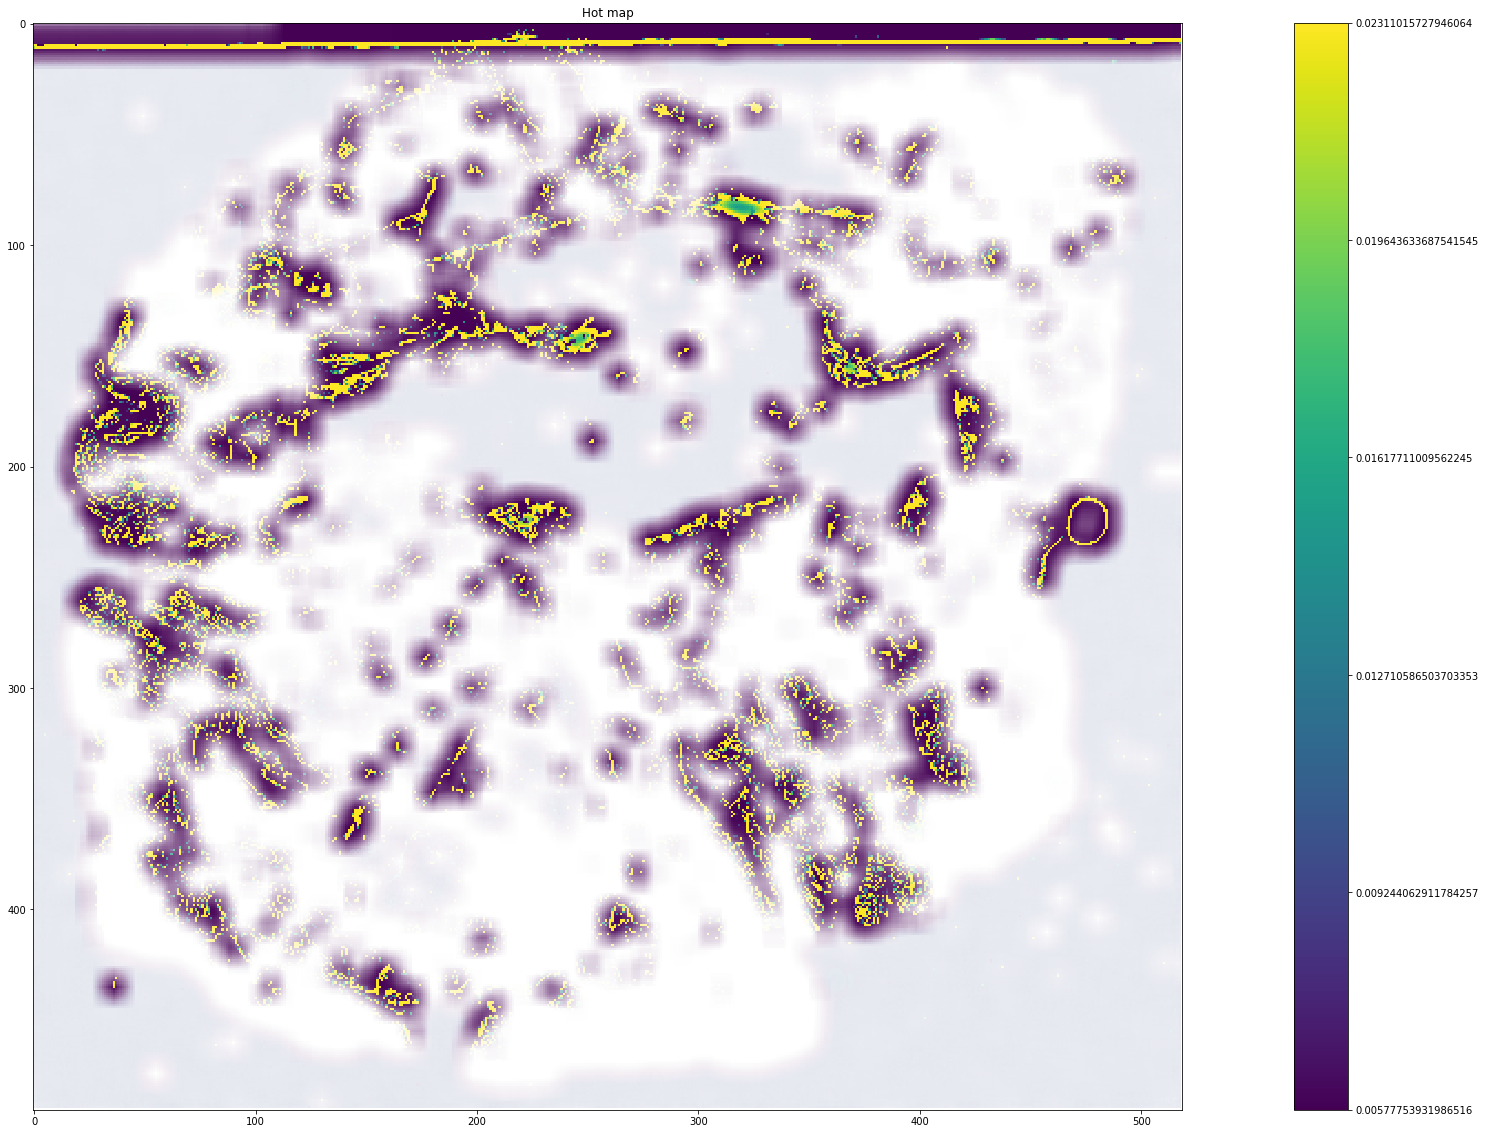

In [5]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
temp = np.mean(hot_map_instance[hot_map_bag>0.5])
vmin = temp*0.5
vmax = temp*2.0
hot_map_instance_01 = (hot_map_instance-vmin)/(vmax-vmin)


cmap = cm.get_cmap()
RGBA = cmap(hot_map_instance_01)
RGBA[...,-1]= hot_map_bag

f,ax = plt.subplots(figsize=(40,20))
h = ax.imshow(RGBA)
cb = plt.colorbar(h)
ticks = cb.get_ticks()
cb.set_ticks(ticks)
cb.set_ticklabels(ticks*(vmax-vmin) + vmin)
ax.set_title("Hot map")
f.show()

In [6]:
def show_bag(bag):
    len_bag = bag.shape[1]
    f, ax = plt.subplots(1, 1, squeeze = False)
    img = bag[0,0,:,:,:].numpy().transpose((1,2,0))
    img = (img - np.min(img))/(np.max(img) - np.min(img))
    ax[0,0].imshow(img)

for bag_idx, (bag, _) in enumerate(apply_loader):
    print(bag.shape)
    #bag = bag.cpu()
    #show_bag(bag)

torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Si

torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Si

torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Si

torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Si

torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Size([1, 100, 3, 92, 92])
torch.Si

### Align WSI and hot map

(490, 519, 3)


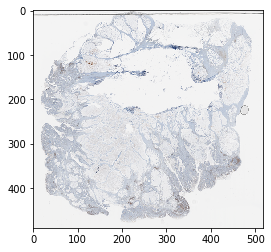

In [6]:
slidedir = 'D:/Ashel-slide/458601.svs'
slide_ob = openslide.OpenSlide(slidedir)
wsi = slide_ob.get_thumbnail((slide_ob.dimensions[0]//92,slide_ob.dimensions[1]//92))
wsi = np.array(wsi)
print(wsi.shape)
plt.imshow(wsi)

In [8]:
def read_annotation(annotdir):
    tree = ET.parse(annotdir)
    root = tree.getroot()
    points_arr_tumor = []
    points_arr_stroma = []
    for r in root.iter('Annotation'):
        if r.attrib['Id']== '1':
            for v in r.iter('Vertex'):
                points_arr_tumor.append((int(v.attrib['X']), int(v.attrib['Y'])))
        if r.attrib['Id']== '2':
            for v in r.iter('Vertex'):
                points_arr_stroma.append((int(v.attrib['X']), int(v.attrib['Y'])))
    return points_arr_tumor, points_arr_stroma

annotdir = 'D:/Ashel-slide/458601.xml'
points_arr_tumor, points_arr_stroma = read_annotation(annotdir)
#print(points_arr_tumor, points_arr_stroma )
tumor_x = [i[0]//92 for i in points_arr_tumor ]
tumor_y = [i[1]//92 for i in points_arr_tumor ]
stroma_x = [i[0]//92 for i in points_arr_stroma ]
stroma_y = [i[1]//92 for i in points_arr_stroma ]

C:\Users\Jasmine\AppData\Local\Continuum\anaconda3\envs\pytorch_gpu\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app
C:\Users\Jasmine\AppData\Local\Continuum\anaconda3\envs\pytorch_gpu\lib\site-packages\ipykernel_launcher.py:35: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


(491, 519, 4)


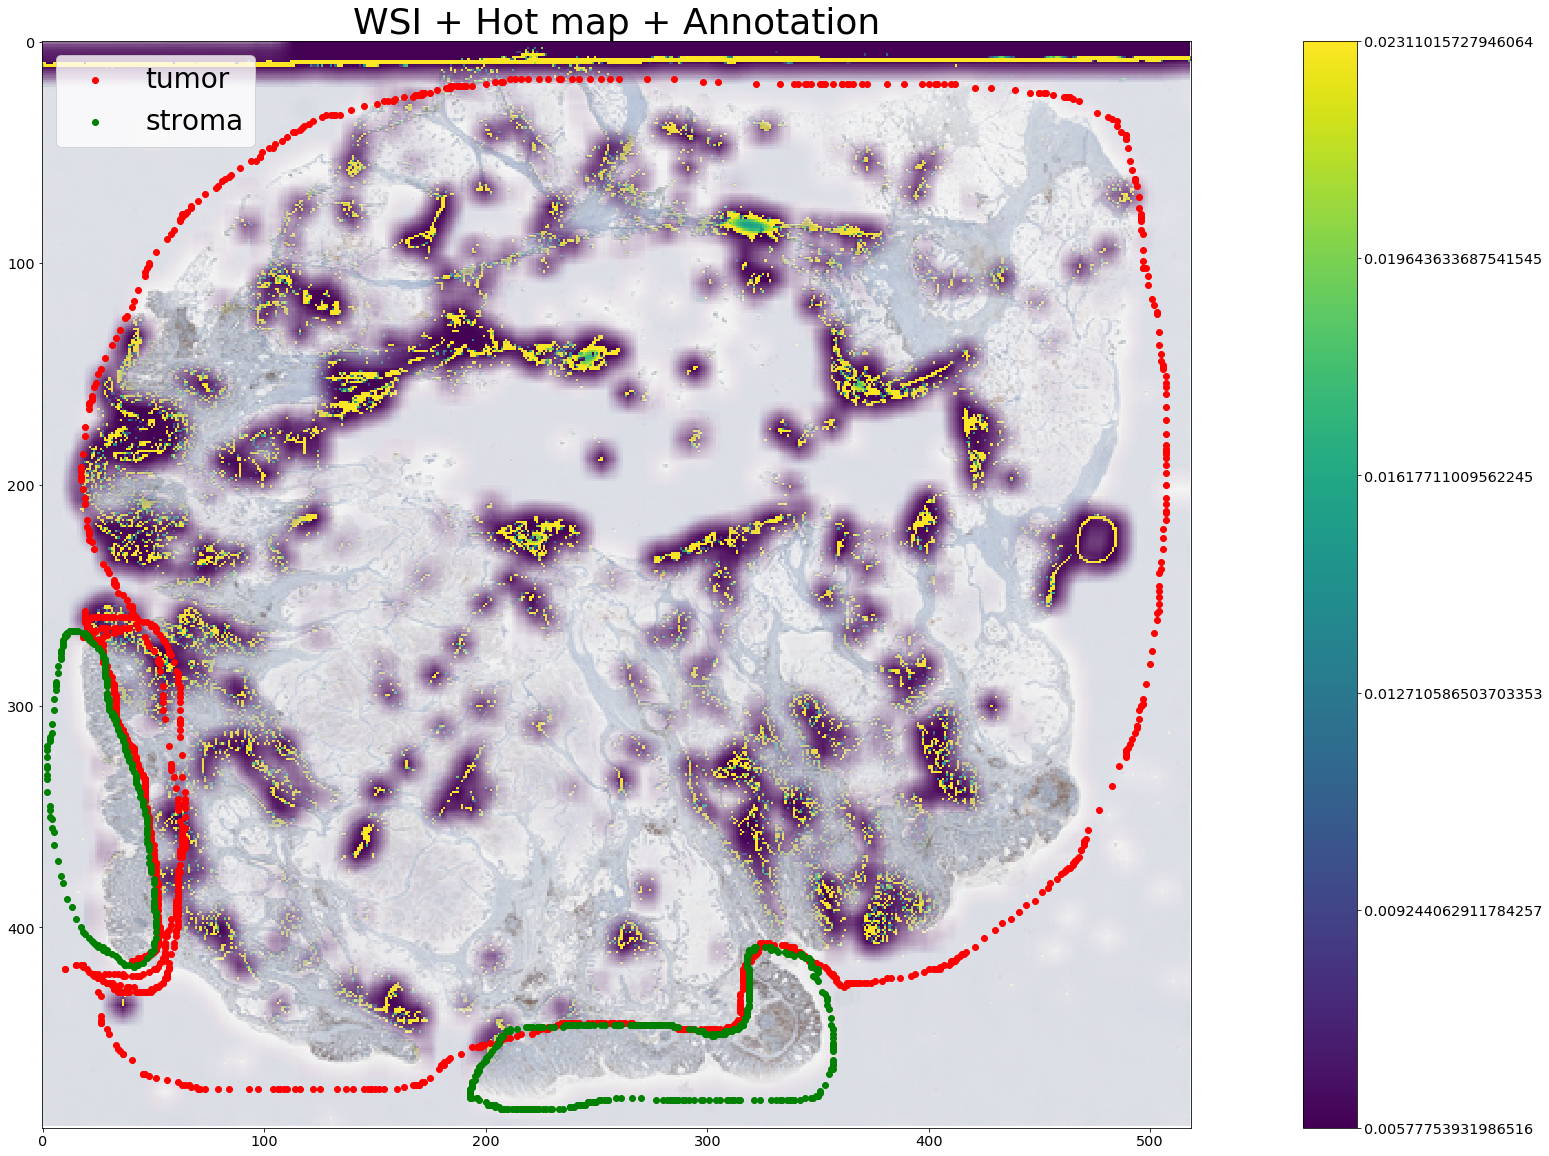

In [10]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 28,
          'figure.figsize': (40, 20),
         'axes.labelsize': 'x-large',
         'axes.titlesize':36,
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

import numpy as np
import matplotlib.cm as cm
hot_map_instance = np.load('hot_map_instance_92_100_601_overlap.npy')
hot_map_bag = np.load('hot_map_bag_92_100_601_overlap.npy')

temp = np.mean(hot_map_instance[hot_map_bag>0.5])
vmin = temp*0.5
vmax = temp*2.0
hot_map_instance_01 = (hot_map_instance-vmin)/(vmax-vmin)

cmap = cm.get_cmap()
RGBA = cmap(hot_map_instance_01)
RGBA[...,-1]= hot_map_bag

f,ax = plt.subplots(figsize=(40,20))
ax.imshow(wsi)
ax.scatter(tumor_x,tumor_y, c='r',label = 'tumor')
ax.scatter(stroma_x,stroma_y, c='g',label = 'stroma')
ax.legend()
h = ax.imshow(RGBA)
cb = plt.colorbar(h)
ticks = cb.get_ticks()
cb.set_ticks(ticks)
cb.set_ticklabels(ticks*(vmax-vmin) + vmin)
ax.set_title("WSI + Hot map + Annotation")
f.show()
print(RGBA.shape)

### Original WSI for comparsion

C:\Users\Jasmine\AppData\Local\Continuum\anaconda3\envs\pytorch_gpu\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


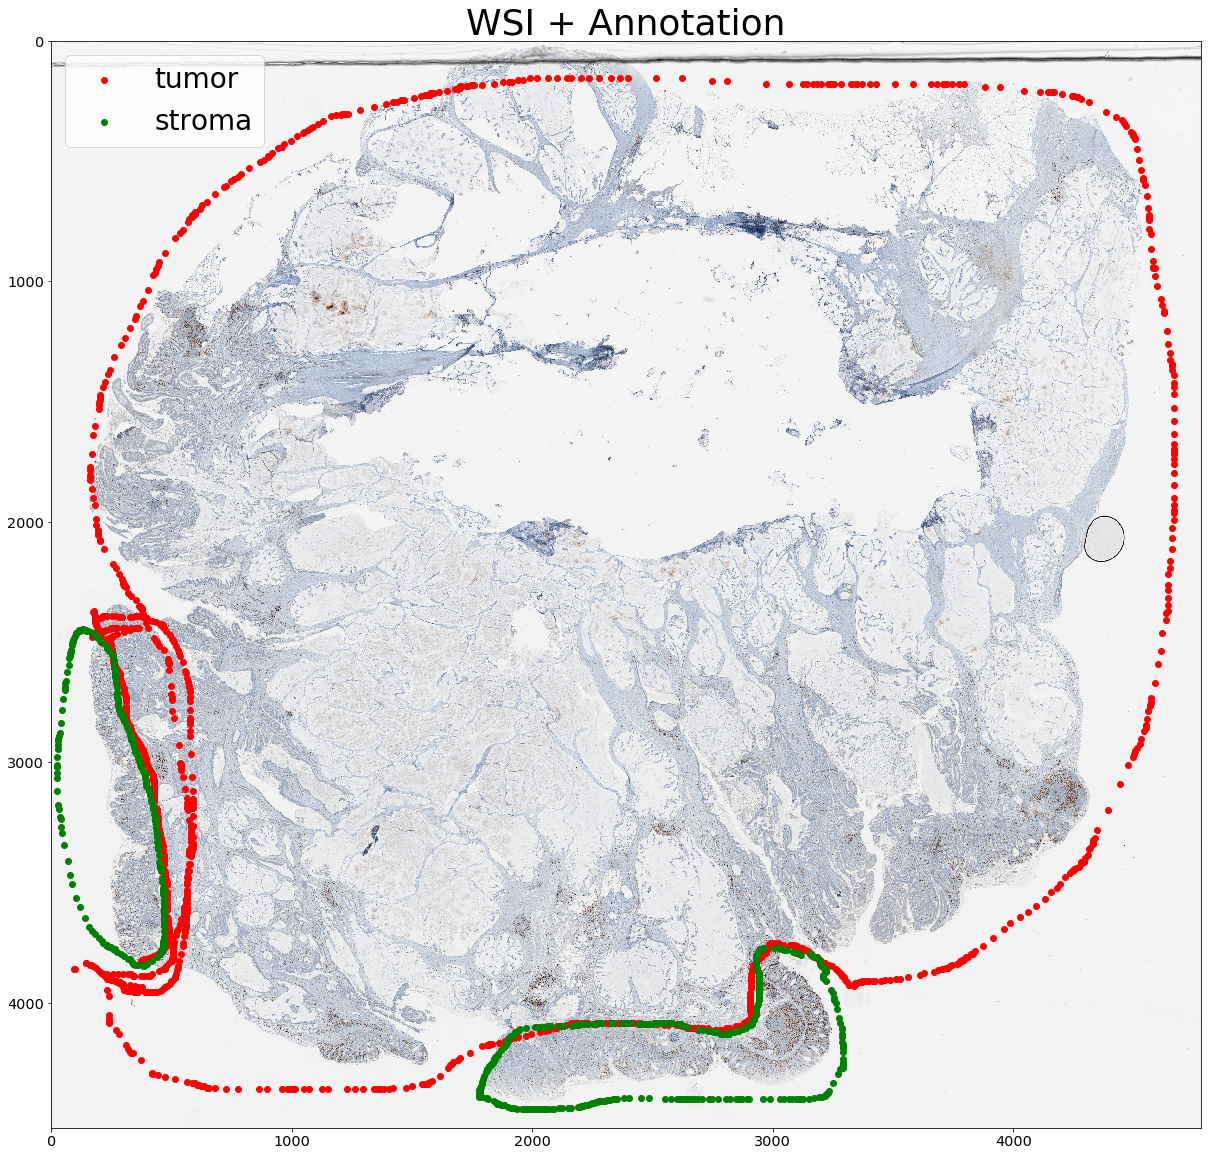

In [11]:
wsi_hr = slide_ob.get_thumbnail((slide_ob.dimensions[0]//10,slide_ob.dimensions[1]//10))
wsi_hr = np.array(wsi_hr)

tumor_x_hr = [i[0]//10 for i in points_arr_tumor ]
tumor_y_hr = [i[1]//10 for i in points_arr_tumor ]
stroma_x_hr = [i[0]//10 for i in points_arr_stroma ]
stroma_y_hr = [i[1]//10 for i in points_arr_stroma ]

f,ax = plt.subplots(figsize=(40,20))
ax.imshow(wsi_hr)
ax.scatter(tumor_x_hr,tumor_y_hr, c='r',label = 'tumor')
ax.scatter(stroma_x_hr,stroma_y_hr, c='g',label = 'stroma')
ax.legend()
ax.set_title("WSI + Annotation")
f.show()